In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

/home/milk/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
2024-02-16 20:31:53.054005: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-16 20:31:53.054042: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-16 20:31:53.055295: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-16 20:31:53.061887: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instruc

In [2]:
import gc
gc.collect()

47

In [3]:
# 사용할 GPU 번호 지정
os.environ["CUDA_VISIBLE_DEVICES"] = "1"  

In [4]:
# train, val, tset dataset load
train_data = 'copy/Fruits_Vegetables_plus/train'
val_data = 'copy/Fruits_Vegetables_plus/validation'
test_data = 'copy/Fruits_Vegetables_plus/test'

In [5]:
# img size
img_width = 180
img_height =180 

In [6]:
# 고급 Keras 사전 처리 유틸리티 : tf.keras.utils.image_dataset_from_directory
# https://www.tensorflow.org/tutorials/load_data/images?hl=ko
# train dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_data,
    shuffle=True,
    image_size=(img_width, img_height),
    batch_size=32,
    validation_split=False
)

Found 6707 files belonging to 37 classes.


2024-02-16 20:32:00.901415: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10058 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:b3:00.0, compute capability: 8.6


In [7]:
# 데이터셋 클래스 이름 확인
data_class_name = train_ds.class_names

In [8]:
data_class_name

['apple',
 'asparagus',
 'banana',
 'beans',
 'beansprouts',
 'beetroot',
 'broccoli',
 'cabbage',
 'capsicum',
 'carrot',
 'cauliflower',
 'chicken',
 'corn',
 'cucumber',
 'egg',
 'eggplant',
 'ginger',
 'grapes',
 'kiwi',
 'lemon',
 'lettuce',
 'mango',
 'onion',
 'orange',
 'paprika',
 'pineapple',
 'pomegranate',
 'pork',
 'potato',
 'pumpkin',
 'raddish',
 'salmon',
 'spinach',
 'sweetpotato',
 'tofu',
 'tomato',
 'watermelon']

In [9]:
# validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    val_data,                                                     
    image_size=(img_height,img_width),                                                  
    batch_size=32,                                                      
    shuffle=False,                                                    
    validation_split=False
)

Found 736 files belonging to 37 classes.


In [10]:
# test dataset
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_data,
    image_size=(img_height,img_width),
    shuffle=False,
    batch_size=32,
    validation_split=False
)

Found 740 files belonging to 37 classes.


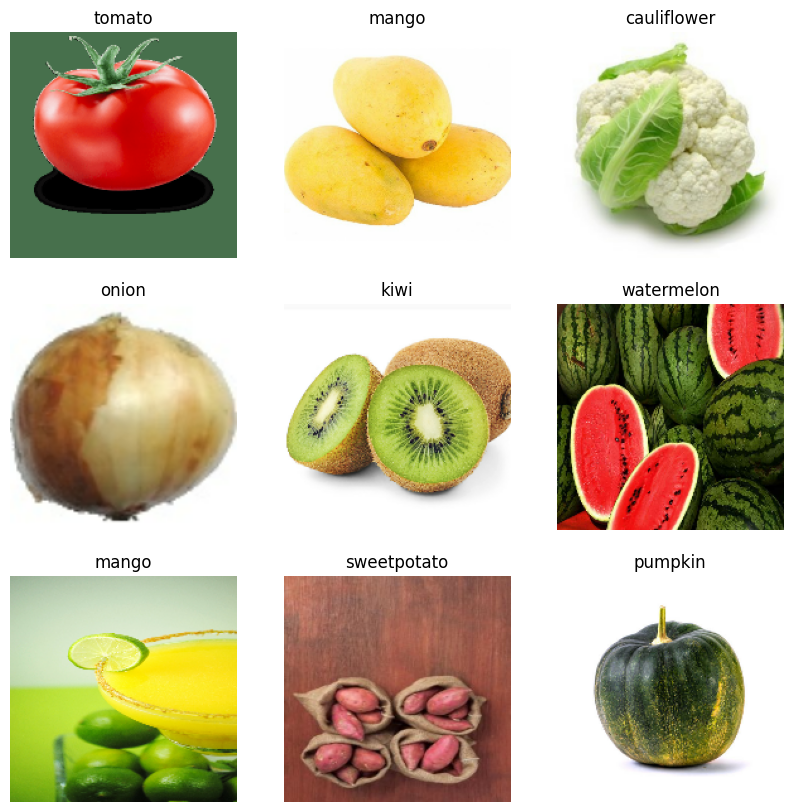

In [11]:
plt.figure(figsize=(10,10))
for image, labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(image[i].numpy().astype('uint8'))
        plt.title(data_class_name[labels[i]])
        plt.axis('off')

In [12]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [46]:
# RGB 채널 값 = [0, 255] 범위 -> 신경망에 이상적이지 않다. 일반적으로 입력 값을 작게 만든다
# tf.keras.layers.Rescaling : [0, 1] 범위로 데이터 표준화

# 모델 정의
model = Sequential([
    layers.Rescaling(1./255),
    layers.Conv2D(32, 3, padding='same', activation='relu'),  
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),                                
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(1024, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(len(data_class_name), activation='softmax')
])

In [47]:
model.compile(
    optimizer='adam', 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    metrics=['accuracy']
)

In [48]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(f'./check_model.h5',save_best_only=True)

In [49]:
epochs_size = 200
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs_size, callbacks=[checkpoint_cb])

Epoch 1/200
 10/210 [>.............................] - ETA: 14s - loss: 4.2821 - accuracy: 0.0531

2024-02-19 12:35:43.583029: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 20s - loss: 3.7719 - accuracy: 0.1141

2024-02-19 12:35:45.346817: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/210 [===>..........................] - ETA: 19s - loss: 3.7049 - accuracy: 0.1250

2024-02-19 12:35:46.022614: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 22s - loss: 3.4887 - accuracy: 0.1522

2024-02-19 12:35:48.958380: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 20s - loss: 3.4281 - accuracy: 0.1587

2024-02-19 12:35:49.528972: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 19s - loss: 3.3851 - accuracy: 0.1639

2024-02-19 12:35:50.165087: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 19s - loss: 3.3618 - accuracy: 0.1655

2024-02-19 12:35:50.633684: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 18s - loss: 3.3472 - accuracy: 0.1673

2024-02-19 12:35:50.854296: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 17s - loss: 3.3389 - accuracy: 0.1703

2024-02-19 12:35:51.239321: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/210 [==========>...................] - ETA: 16s - loss: 3.2818 - accuracy: 0.1786

2024-02-19 12:35:52.339773: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 3.1964 - accuracy: 0.1896

2024-02-19 12:35:54.008940: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 13s - loss: 3.1365 - accuracy: 0.2013

2024-02-19 12:35:55.008485: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 3.0756 - accuracy: 0.2125

2024-02-19 12:35:57.891975: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 12:35:58.057042: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 3.0071 - accuracy: 0.2214

2024-02-19 12:35:59.450350: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 2.8544 - accuracy: 0.2485

2024-02-19 12:36:03.576021: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 2.7886 - accuracy: 0.2594

2024-02-19 12:36:06.790223: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 2.7754 - accuracy: 0.2635

2024-02-19 12:36:07.131968: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 2.7432 - accuracy: 0.2685

2024-02-19 12:36:09.277396: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 12:36:09.680103: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 35s 149ms/step - loss: 2.7418 - accuracy: 0.2688 - val_loss: 7.0458 - val_accuracy: 0.0367
Epoch 2/200
 10/210 [>.............................] - ETA: 19s - loss: 2.1533 - accuracy: 0.3375

2024-02-19 12:36:15.640472: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 23s - loss: 2.0483 - accuracy: 0.3981

2024-02-19 12:36:17.511517: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/210 [===>..........................] - ETA: 22s - loss: 2.0430 - accuracy: 0.4083

2024-02-19 12:36:18.223181: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 23s - loss: 2.0286 - accuracy: 0.4130

2024-02-19 12:36:21.108765: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 2.0435 - accuracy: 0.4135

2024-02-19 12:36:21.622772: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 2.0436 - accuracy: 0.4178

2024-02-19 12:36:22.270493: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 20s - loss: 2.0445 - accuracy: 0.4185

2024-02-19 12:36:22.768205: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 19s - loss: 2.0430 - accuracy: 0.4216

2024-02-19 12:36:22.985040: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 18s - loss: 2.0411 - accuracy: 0.4226

2024-02-19 12:36:23.342416: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 2.0471 - accuracy: 0.4191

2024-02-19 12:36:24.478341: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 2.0490 - accuracy: 0.4156

2024-02-19 12:36:26.146112: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 13s - loss: 2.0379 - accuracy: 0.4172

2024-02-19 12:36:27.110748: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 2.0028 - accuracy: 0.4231

2024-02-19 12:36:30.054531: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 12:36:30.241080: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 1.9734 - accuracy: 0.4321

2024-02-19 12:36:31.613954: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 1.9449 - accuracy: 0.4392

2024-02-19 12:36:35.689977: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 1.9268 - accuracy: 0.4416

2024-02-19 12:36:38.878001: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 1.9226 - accuracy: 0.4420

2024-02-19 12:36:39.236662: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 1.9090 - accuracy: 0.4444

2024-02-19 12:36:41.166091: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 12:36:41.564348: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 32s 150ms/step - loss: 1.9089 - accuracy: 0.4443 - val_loss: 3.5347 - val_accuracy: 0.1739
Epoch 3/200
 10/210 [>.............................] - ETA: 19s - loss: 1.6865 - accuracy: 0.4938

2024-02-19 12:36:47.508650: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/210 [==>...........................] - ETA: 22s - loss: 1.5731 - accuracy: 0.5312

2024-02-19 12:36:49.297748: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/210 [===>..........................] - ETA: 21s - loss: 1.5793 - accuracy: 0.5271

2024-02-19 12:36:49.951755: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 22s - loss: 1.6192 - accuracy: 0.5211

2024-02-19 12:36:52.783483: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 20s - loss: 1.6318 - accuracy: 0.5180

2024-02-19 12:36:53.309024: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 19s - loss: 1.6523 - accuracy: 0.5110

2024-02-19 12:36:53.964888: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/210 [=======>......................] - ETA: 19s - loss: 1.6452 - accuracy: 0.5146

2024-02-19 12:36:54.500760: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 18s - loss: 1.6713 - accuracy: 0.5087

2024-02-19 12:36:54.717241: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 17s - loss: 1.6773 - accuracy: 0.5068

2024-02-19 12:36:55.086036: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/210 [==========>...................] - ETA: 16s - loss: 1.6895 - accuracy: 0.5041

2024-02-19 12:36:56.240269: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 1.6911 - accuracy: 0.4993

2024-02-19 12:36:57.921498: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/210 [=============>................] - ETA: 13s - loss: 1.6596 - accuracy: 0.5031

2024-02-19 12:36:58.967187: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 1.6430 - accuracy: 0.5060

2024-02-19 12:37:01.832806: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 12:37:02.014401: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 1.6340 - accuracy: 0.5083

2024-02-19 12:37:03.410733: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 1.6090 - accuracy: 0.5157

2024-02-19 12:37:07.393505: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 1.6017 - accuracy: 0.5179

2024-02-19 12:37:10.536073: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 1.6026 - accuracy: 0.5171

2024-02-19 12:37:10.848421: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 1.5996 - accuracy: 0.5197

2024-02-19 12:37:12.797450: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 12:37:13.225429: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 32s 148ms/step - loss: 1.6038 - accuracy: 0.5190 - val_loss: 1.6127 - val_accuracy: 0.5245
Epoch 4/200
 10/210 [>.............................] - ETA: 21s - loss: 1.3242 - accuracy: 0.5844

2024-02-19 12:37:19.190482: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 23s - loss: 1.3215 - accuracy: 0.5992

2024-02-19 12:37:21.027244: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/210 [===>..........................] - ETA: 22s - loss: 1.3434 - accuracy: 0.5916

2024-02-19 12:37:21.740061: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 23s - loss: 1.3554 - accuracy: 0.5924

2024-02-19 12:37:24.570988: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 1.3458 - accuracy: 0.5919

2024-02-19 12:37:25.097765: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 1.3474 - accuracy: 0.5932

2024-02-19 12:37:25.751967: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/210 [=======>......................] - ETA: 20s - loss: 1.3670 - accuracy: 0.5885

2024-02-19 12:37:26.242869: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 64/210 [========>.....................] - ETA: 19s - loss: 1.3728 - accuracy: 0.5840

2024-02-19 12:37:26.452999: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 18s - loss: 1.4110 - accuracy: 0.5756

2024-02-19 12:37:26.851993: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 1.4116 - accuracy: 0.5761

2024-02-19 12:37:27.984811: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 1.3962 - accuracy: 0.5809

2024-02-19 12:37:29.679479: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 13s - loss: 1.3828 - accuracy: 0.5828

2024-02-19 12:37:30.708540: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 1.3889 - accuracy: 0.5774

2024-02-19 12:37:33.722119: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 12:37:33.845479: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 11s - loss: 1.3701 - accuracy: 0.5830

2024-02-19 12:37:35.230423: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 1.3475 - accuracy: 0.5941

2024-02-19 12:37:39.367793: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 1.3332 - accuracy: 0.5972

2024-02-19 12:37:42.570747: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 1.3325 - accuracy: 0.5968

2024-02-19 12:37:42.885419: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 1.3200 - accuracy: 0.6002

2024-02-19 12:37:44.781688: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 12:37:45.204268: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 32s 150ms/step - loss: 1.3189 - accuracy: 0.6004 - val_loss: 1.3792 - val_accuracy: 0.6114
Epoch 5/200
 10/210 [>.............................] - ETA: 20s - loss: 1.0298 - accuracy: 0.6812

2024-02-19 12:37:51.117459: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/210 [==>...........................] - ETA: 23s - loss: 1.0663 - accuracy: 0.6693

2024-02-19 12:37:52.934377: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/210 [===>..........................] - ETA: 22s - loss: 1.0923 - accuracy: 0.6646

2024-02-19 12:37:53.610690: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 22s - loss: 1.1186 - accuracy: 0.6549

2024-02-19 12:37:56.468807: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 1.1136 - accuracy: 0.6556

2024-02-19 12:37:57.012184: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 1.1057 - accuracy: 0.6601

2024-02-19 12:37:57.625941: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/210 [=======>......................] - ETA: 20s - loss: 1.1153 - accuracy: 0.6578

2024-02-19 12:37:58.109849: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 64/210 [========>.....................] - ETA: 19s - loss: 1.1072 - accuracy: 0.6602

2024-02-19 12:37:58.341463: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 17s - loss: 1.1127 - accuracy: 0.6599

2024-02-19 12:37:58.718981: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 1.1063 - accuracy: 0.6639

2024-02-19 12:37:59.826496: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 1.1119 - accuracy: 0.6642

2024-02-19 12:38:01.469569: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 13s - loss: 1.1059 - accuracy: 0.6631

2024-02-19 12:38:02.482501: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 1.0939 - accuracy: 0.6649

2024-02-19 12:38:05.461276: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 12:38:05.611612: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 1.0913 - accuracy: 0.6636

2024-02-19 12:38:07.011814: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 1.0869 - accuracy: 0.6647

2024-02-19 12:38:11.042017: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 1.0781 - accuracy: 0.6675

2024-02-19 12:38:14.190805: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 1.0789 - accuracy: 0.6668

2024-02-19 12:38:14.532174: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 1.0693 - accuracy: 0.6688

2024-02-19 12:38:16.454338: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 12:38:16.864586: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 135ms/step - loss: 1.0679 - accuracy: 0.6692 - val_loss: 2.1986 - val_accuracy: 0.4144
Epoch 6/200
 10/210 [>.............................] - ETA: 19s - loss: 0.8337 - accuracy: 0.7656

2024-02-19 12:38:19.942401: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 23s - loss: 0.9121 - accuracy: 0.7296

2024-02-19 12:38:21.758636: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/210 [===>..........................] - ETA: 22s - loss: 0.9095 - accuracy: 0.7281

2024-02-19 12:38:22.438461: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 22s - loss: 0.9193 - accuracy: 0.7235

2024-02-19 12:38:25.277547: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.9153 - accuracy: 0.7224

2024-02-19 12:38:25.822169: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.9361 - accuracy: 0.7171

2024-02-19 12:38:26.481717: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/210 [=======>......................] - ETA: 20s - loss: 0.9442 - accuracy: 0.7135

2024-02-19 12:38:26.962142: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 18s - loss: 0.9382 - accuracy: 0.7183

2024-02-19 12:38:27.179391: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 17s - loss: 0.9451 - accuracy: 0.7174

2024-02-19 12:38:27.537616: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/210 [==========>...................] - ETA: 16s - loss: 0.9496 - accuracy: 0.7127

2024-02-19 12:38:28.604616: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.9450 - accuracy: 0.7132

2024-02-19 12:38:30.281210: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 13s - loss: 0.9245 - accuracy: 0.7194

2024-02-19 12:38:31.352393: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.9076 - accuracy: 0.7250

2024-02-19 12:38:34.323165: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 12:38:34.494676: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 0.8987 - accuracy: 0.7266

2024-02-19 12:38:35.900743: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.8836 - accuracy: 0.7289

2024-02-19 12:38:40.076428: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.8614 - accuracy: 0.7363

2024-02-19 12:38:43.123962: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.8614 - accuracy: 0.7369

2024-02-19 12:38:43.450167: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.8591 - accuracy: 0.7377

2024-02-19 12:38:45.373274: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 12:38:45.777968: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 135ms/step - loss: 0.8603 - accuracy: 0.7370 - val_loss: 1.7551 - val_accuracy: 0.5367
Epoch 7/200
 10/210 [>.............................] - ETA: 20s - loss: 0.7468 - accuracy: 0.7719

2024-02-19 12:38:48.796385: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/210 [==>...........................] - ETA: 22s - loss: 0.7759 - accuracy: 0.7617

2024-02-19 12:38:50.576960: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/210 [===>..........................] - ETA: 21s - loss: 0.7815 - accuracy: 0.7629

2024-02-19 12:38:51.205925: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 22s - loss: 0.7930 - accuracy: 0.7643

2024-02-19 12:38:54.001093: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 20s - loss: 0.7808 - accuracy: 0.7662

2024-02-19 12:38:54.526642: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 19s - loss: 0.7774 - accuracy: 0.7670

2024-02-19 12:38:55.190975: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 19s - loss: 0.7787 - accuracy: 0.7669

2024-02-19 12:38:55.709988: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 63/210 [========>.....................] - ETA: 19s - loss: 0.7749 - accuracy: 0.7693

2024-02-19 12:38:55.929170: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 17s - loss: 0.7592 - accuracy: 0.7726

2024-02-19 12:38:56.357066: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/210 [==========>...................] - ETA: 16s - loss: 0.7713 - accuracy: 0.7654

2024-02-19 12:38:57.485273: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.7494 - accuracy: 0.7722

2024-02-19 12:38:59.177142: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 13s - loss: 0.7374 - accuracy: 0.7775

2024-02-19 12:39:00.183467: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.7271 - accuracy: 0.7823

2024-02-19 12:39:03.190815: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 12:39:03.333907: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 0.7048 - accuracy: 0.7881

2024-02-19 12:39:04.740343: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.6890 - accuracy: 0.7917

2024-02-19 12:39:08.834193: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.6777 - accuracy: 0.7952

2024-02-19 12:39:12.016138: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.6745 - accuracy: 0.7958

2024-02-19 12:39:12.385931: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.6799 - accuracy: 0.7952

2024-02-19 12:39:14.270169: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 12:39:14.711830: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 136ms/step - loss: 0.6807 - accuracy: 0.7948 - val_loss: 1.4109 - val_accuracy: 0.6291
Epoch 8/200
 10/210 [>.............................] - ETA: 20s - loss: 0.4462 - accuracy: 0.8687

2024-02-19 12:39:17.763627: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 23s - loss: 0.5029 - accuracy: 0.8519

2024-02-19 12:39:19.595989: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/210 [===>..........................] - ETA: 22s - loss: 0.5350 - accuracy: 0.8427

2024-02-19 12:39:20.283159: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 22s - loss: 0.5550 - accuracy: 0.8336

2024-02-19 12:39:23.102179: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.5646 - accuracy: 0.8281

2024-02-19 12:39:23.630383: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.5611 - accuracy: 0.8279

2024-02-19 12:39:24.273687: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 20s - loss: 0.5615 - accuracy: 0.8253

2024-02-19 12:39:24.764389: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 18s - loss: 0.5615 - accuracy: 0.8255

2024-02-19 12:39:24.973755: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 17s - loss: 0.5691 - accuracy: 0.8211

2024-02-19 12:39:25.362452: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.5862 - accuracy: 0.8149

2024-02-19 12:39:26.466562: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.5880 - accuracy: 0.8149

2024-02-19 12:39:28.099738: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/210 [=============>................] - ETA: 13s - loss: 0.5818 - accuracy: 0.8165

2024-02-19 12:39:29.136024: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.5854 - accuracy: 0.8158

2024-02-19 12:39:31.983593: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 12:39:32.132577: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 0.5846 - accuracy: 0.8149

2024-02-19 12:39:33.521825: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.5711 - accuracy: 0.8213

2024-02-19 12:39:37.626393: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.5456 - accuracy: 0.8301

2024-02-19 12:39:40.846609: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.5440 - accuracy: 0.8311

2024-02-19 12:39:41.201715: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.5354 - accuracy: 0.8337

2024-02-19 12:39:43.212644: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 12:39:43.643201: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 32s 149ms/step - loss: 0.5356 - accuracy: 0.8338 - val_loss: 1.2361 - val_accuracy: 0.7011
Epoch 9/200
 10/210 [>.............................] - ETA: 19s - loss: 0.3576 - accuracy: 0.8813

2024-02-19 12:39:49.505993: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 23s - loss: 0.3564 - accuracy: 0.8804

2024-02-19 12:39:51.346230: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/210 [===>..........................] - ETA: 22s - loss: 0.3440 - accuracy: 0.8901

2024-02-19 12:39:52.052918: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 22s - loss: 0.3419 - accuracy: 0.8906

2024-02-19 12:39:54.905562: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.3448 - accuracy: 0.8894

2024-02-19 12:39:55.460483: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.3412 - accuracy: 0.8914

2024-02-19 12:39:56.098800: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/210 [=======>......................] - ETA: 20s - loss: 0.3414 - accuracy: 0.8927

2024-02-19 12:39:56.581389: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 18s - loss: 0.3324 - accuracy: 0.8962

2024-02-19 12:39:56.788307: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 17s - loss: 0.3309 - accuracy: 0.8967

2024-02-19 12:39:57.146955: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.3291 - accuracy: 0.8986

2024-02-19 12:39:58.268379: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.3221 - accuracy: 0.9010

2024-02-19 12:39:59.936753: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 13s - loss: 0.3114 - accuracy: 0.9041

2024-02-19 12:40:00.977104: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.3033 - accuracy: 0.9052

2024-02-19 12:40:03.953377: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 12:40:04.095769: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 0.2996 - accuracy: 0.9075

2024-02-19 12:40:05.466771: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.2979 - accuracy: 0.9089

2024-02-19 12:40:09.539893: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.2998 - accuracy: 0.9085

2024-02-19 12:40:12.697391: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.2990 - accuracy: 0.9088

2024-02-19 12:40:13.064607: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.2994 - accuracy: 0.9086

2024-02-19 12:40:14.969121: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 12:40:15.386795: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 136ms/step - loss: 0.2993 - accuracy: 0.9088 - val_loss: 1.3573 - val_accuracy: 0.6698
Epoch 10/200
 10/210 [>.............................] - ETA: 20s - loss: 0.2957 - accuracy: 0.9000

2024-02-19 12:40:18.486936: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 22s - loss: 0.2638 - accuracy: 0.9212

2024-02-19 12:40:20.268539: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/210 [===>..........................] - ETA: 22s - loss: 0.2748 - accuracy: 0.9177

2024-02-19 12:40:20.991648: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 23s - loss: 0.3027 - accuracy: 0.9069

2024-02-19 12:40:23.961215: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.3042 - accuracy: 0.9056

2024-02-19 12:40:24.519033: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.3025 - accuracy: 0.9068

2024-02-19 12:40:25.197168: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/210 [=======>......................] - ETA: 20s - loss: 0.3011 - accuracy: 0.9073

2024-02-19 12:40:25.693494: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 19s - loss: 0.3041 - accuracy: 0.9067

2024-02-19 12:40:25.899611: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 18s - loss: 0.3048 - accuracy: 0.9058

2024-02-19 12:40:26.287793: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.3115 - accuracy: 0.9026

2024-02-19 12:40:27.448559: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.3230 - accuracy: 0.8997

2024-02-19 12:40:29.128135: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/210 [=============>................] - ETA: 13s - loss: 0.3222 - accuracy: 0.8991

2024-02-19 12:40:30.164918: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.3312 - accuracy: 0.8948

2024-02-19 12:40:33.045814: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 12:40:33.198420: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 11s - loss: 0.3312 - accuracy: 0.8958

2024-02-19 12:40:34.590613: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.3163 - accuracy: 0.9003

2024-02-19 12:40:38.611496: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.3083 - accuracy: 0.9012

2024-02-19 12:40:41.764606: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.3080 - accuracy: 0.9013

2024-02-19 12:40:42.140880: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.3049 - accuracy: 0.9025

2024-02-19 12:40:44.049780: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 12:40:44.473989: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 136ms/step - loss: 0.3044 - accuracy: 0.9026 - val_loss: 1.6625 - val_accuracy: 0.6209
Epoch 11/200
 10/210 [>.............................] - ETA: 19s - loss: 0.2135 - accuracy: 0.9344

2024-02-19 12:40:47.551000: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/210 [==>...........................] - ETA: 23s - loss: 0.2428 - accuracy: 0.9245

2024-02-19 12:40:49.371888: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/210 [===>..........................] - ETA: 21s - loss: 0.2333 - accuracy: 0.9278

2024-02-19 12:40:50.048055: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 22s - loss: 0.2326 - accuracy: 0.9246

2024-02-19 12:40:52.830984: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.2298 - accuracy: 0.9261

2024-02-19 12:40:53.398331: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.2339 - accuracy: 0.9232

2024-02-19 12:40:54.028982: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/210 [=======>......................] - ETA: 19s - loss: 0.2320 - accuracy: 0.9234

2024-02-19 12:40:54.512292: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 18s - loss: 0.2408 - accuracy: 0.9231

2024-02-19 12:40:54.729933: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 17s - loss: 0.2407 - accuracy: 0.9226

2024-02-19 12:40:55.121935: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.2401 - accuracy: 0.9239

2024-02-19 12:40:56.272599: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.2409 - accuracy: 0.9215

2024-02-19 12:40:57.956168: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/210 [=============>................] - ETA: 13s - loss: 0.2358 - accuracy: 0.9226

2024-02-19 12:40:58.982490: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.2423 - accuracy: 0.9204

2024-02-19 12:41:01.862543: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 12:41:02.031052: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 0.2499 - accuracy: 0.9194

2024-02-19 12:41:03.357135: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.2694 - accuracy: 0.9137

2024-02-19 12:41:07.559104: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.2810 - accuracy: 0.9110

2024-02-19 12:41:10.813672: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.2825 - accuracy: 0.9104

2024-02-19 12:41:11.148802: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.2828 - accuracy: 0.9110

2024-02-19 12:41:13.058365: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 12:41:13.487354: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 136ms/step - loss: 0.2826 - accuracy: 0.9111 - val_loss: 1.8327 - val_accuracy: 0.6168
Epoch 12/200
 10/210 [>.............................] - ETA: 20s - loss: 0.3448 - accuracy: 0.8969

2024-02-19 12:41:16.579284: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 23s - loss: 0.3281 - accuracy: 0.9022

2024-02-19 12:41:18.393224: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/210 [===>..........................] - ETA: 21s - loss: 0.3075 - accuracy: 0.9062

2024-02-19 12:41:19.058326: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 22s - loss: 0.2914 - accuracy: 0.9110

2024-02-19 12:41:21.858057: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.2803 - accuracy: 0.9135

2024-02-19 12:41:22.431872: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.2820 - accuracy: 0.9150

2024-02-19 12:41:23.100308: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/210 [=======>......................] - ETA: 20s - loss: 0.2831 - accuracy: 0.9151

2024-02-19 12:41:23.584408: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 63/210 [========>.....................] - ETA: 19s - loss: 0.2783 - accuracy: 0.9157

2024-02-19 12:41:23.802700: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 18s - loss: 0.2741 - accuracy: 0.9171

2024-02-19 12:41:24.202421: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/210 [==========>...................] - ETA: 16s - loss: 0.2704 - accuracy: 0.9184

2024-02-19 12:41:25.346439: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.2570 - accuracy: 0.9212

2024-02-19 12:41:27.045407: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 13s - loss: 0.2521 - accuracy: 0.9219

2024-02-19 12:41:28.028730: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.2521 - accuracy: 0.9215

2024-02-19 12:41:30.933645: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 12:41:31.107193: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 0.2436 - accuracy: 0.9248

2024-02-19 12:41:32.474547: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.2252 - accuracy: 0.9302

2024-02-19 12:41:36.599058: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.2165 - accuracy: 0.9318

2024-02-19 12:41:39.796432: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.2146 - accuracy: 0.9322

2024-02-19 12:41:40.114795: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.2084 - accuracy: 0.9345

2024-02-19 12:41:42.032598: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 12:41:42.447640: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 136ms/step - loss: 0.2082 - accuracy: 0.9345 - val_loss: 1.5971 - val_accuracy: 0.6481
Epoch 13/200
 10/210 [>.............................] - ETA: 19s - loss: 0.1403 - accuracy: 0.9531

2024-02-19 12:41:45.502213: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/210 [==>...........................] - ETA: 23s - loss: 0.1861 - accuracy: 0.9349

2024-02-19 12:41:47.301312: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/210 [===>..........................] - ETA: 21s - loss: 0.1852 - accuracy: 0.9385

2024-02-19 12:41:47.987012: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 22s - loss: 0.1833 - accuracy: 0.9402

2024-02-19 12:41:50.859631: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.1779 - accuracy: 0.9429

2024-02-19 12:41:51.439801: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.1755 - accuracy: 0.9435

2024-02-19 12:41:52.084827: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/210 [=======>......................] - ETA: 20s - loss: 0.1750 - accuracy: 0.9438

2024-02-19 12:41:52.551514: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 18s - loss: 0.1751 - accuracy: 0.9442

2024-02-19 12:41:52.768670: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 68/210 [========>.....................] - ETA: 18s - loss: 0.1753 - accuracy: 0.9439

2024-02-19 12:41:53.130189: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.1766 - accuracy: 0.9435

2024-02-19 12:41:54.374178: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.1723 - accuracy: 0.9441

2024-02-19 12:41:56.010639: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/210 [=============>................] - ETA: 13s - loss: 0.1693 - accuracy: 0.9440

2024-02-19 12:41:57.062687: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.1634 - accuracy: 0.9476

2024-02-19 12:41:59.991548: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 12:42:00.117359: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 0.1602 - accuracy: 0.9482

2024-02-19 12:42:01.503181: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.1510 - accuracy: 0.9512

2024-02-19 12:42:05.629156: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.1472 - accuracy: 0.9525

2024-02-19 12:42:08.815843: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.1476 - accuracy: 0.9522

2024-02-19 12:42:09.189474: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.1485 - accuracy: 0.9520

2024-02-19 12:42:11.103052: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 12:42:11.516898: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 32s 150ms/step - loss: 0.1483 - accuracy: 0.9520 - val_loss: 1.0685 - val_accuracy: 0.7609
Epoch 14/200
 10/210 [>.............................] - ETA: 19s - loss: 0.1207 - accuracy: 0.9625

2024-02-19 12:42:17.460241: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 23s - loss: 0.1286 - accuracy: 0.9620

2024-02-19 12:42:19.306388: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/210 [===>..........................] - ETA: 22s - loss: 0.1312 - accuracy: 0.9594

2024-02-19 12:42:20.000098: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 23s - loss: 0.1148 - accuracy: 0.9633

2024-02-19 12:42:22.950610: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.1114 - accuracy: 0.9645

2024-02-19 12:42:23.493524: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.1127 - accuracy: 0.9627

2024-02-19 12:42:24.166813: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 20s - loss: 0.1151 - accuracy: 0.9616

2024-02-19 12:42:24.649507: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 63/210 [========>.....................] - ETA: 19s - loss: 0.1147 - accuracy: 0.9618

2024-02-19 12:42:24.872847: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 18s - loss: 0.1141 - accuracy: 0.9620

2024-02-19 12:42:25.335221: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.1168 - accuracy: 0.9607

2024-02-19 12:42:26.434774: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.1259 - accuracy: 0.9601

2024-02-19 12:42:28.090296: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 14s - loss: 0.1263 - accuracy: 0.9597

2024-02-19 12:42:29.108077: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.1256 - accuracy: 0.9592

2024-02-19 12:42:32.058572: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 12:42:32.200425: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 11s - loss: 0.1238 - accuracy: 0.9602

2024-02-19 12:42:33.602834: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.1241 - accuracy: 0.9611

2024-02-19 12:42:37.614882: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.1310 - accuracy: 0.9588

2024-02-19 12:42:40.835579: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.1314 - accuracy: 0.9588

2024-02-19 12:42:41.183180: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.1327 - accuracy: 0.9586

2024-02-19 12:42:43.101891: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 12:42:43.521872: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 137ms/step - loss: 0.1326 - accuracy: 0.9587 - val_loss: 1.3224 - val_accuracy: 0.6984
Epoch 15/200
 10/210 [>.............................] - ETA: 19s - loss: 0.1942 - accuracy: 0.9500

2024-02-19 12:42:46.688279: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 22s - loss: 0.1874 - accuracy: 0.9457

2024-02-19 12:42:48.479718: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/210 [===>..........................] - ETA: 22s - loss: 0.1732 - accuracy: 0.9458

2024-02-19 12:42:49.204801: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 22s - loss: 0.1771 - accuracy: 0.9443

2024-02-19 12:42:51.949708: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.1734 - accuracy: 0.9465

2024-02-19 12:42:52.516066: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.1687 - accuracy: 0.9474

2024-02-19 12:42:53.199994: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/210 [=======>......................] - ETA: 20s - loss: 0.1700 - accuracy: 0.9448

2024-02-19 12:42:53.686420: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 18s - loss: 0.1794 - accuracy: 0.9442

2024-02-19 12:42:53.902758: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 68/210 [========>.....................] - ETA: 18s - loss: 0.1798 - accuracy: 0.9439

2024-02-19 12:42:54.266288: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.1781 - accuracy: 0.9415

2024-02-19 12:42:55.461020: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.1835 - accuracy: 0.9406

2024-02-19 12:42:57.074437: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/210 [=============>................] - ETA: 13s - loss: 0.1816 - accuracy: 0.9425

2024-02-19 12:42:58.054699: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.1741 - accuracy: 0.9443

2024-02-19 12:43:00.945432: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 12:43:01.072710: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 0.1777 - accuracy: 0.9424

2024-02-19 12:43:02.448512: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.1964 - accuracy: 0.9369

2024-02-19 12:43:06.654766: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.1931 - accuracy: 0.9378

2024-02-19 12:43:09.807734: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.1930 - accuracy: 0.9380

2024-02-19 12:43:10.174164: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.1947 - accuracy: 0.9378

2024-02-19 12:43:12.210365: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 12:43:12.636632: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 136ms/step - loss: 0.1945 - accuracy: 0.9378 - val_loss: 1.6314 - val_accuracy: 0.6739
Epoch 16/200
 10/210 [>.............................] - ETA: 19s - loss: 0.1917 - accuracy: 0.9250

2024-02-19 12:43:15.768292: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 23s - loss: 0.1806 - accuracy: 0.9361

2024-02-19 12:43:17.647238: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/210 [===>..........................] - ETA: 22s - loss: 0.1682 - accuracy: 0.9418

2024-02-19 12:43:18.306139: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 23s - loss: 0.1874 - accuracy: 0.9395

2024-02-19 12:43:21.222479: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.1814 - accuracy: 0.9405

2024-02-19 12:43:21.782978: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.1810 - accuracy: 0.9408

2024-02-19 12:43:22.395576: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 20s - loss: 0.1781 - accuracy: 0.9426

2024-02-19 12:43:22.874220: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 18s - loss: 0.1767 - accuracy: 0.9433

2024-02-19 12:43:23.075862: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 68/210 [========>.....................] - ETA: 18s - loss: 0.1789 - accuracy: 0.9426

2024-02-19 12:43:23.473193: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/210 [==========>...................] - ETA: 16s - loss: 0.1800 - accuracy: 0.9432

2024-02-19 12:43:24.638495: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.1728 - accuracy: 0.9455

2024-02-19 12:43:26.245783: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/210 [=============>................] - ETA: 13s - loss: 0.1698 - accuracy: 0.9465

2024-02-19 12:43:27.236137: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.1658 - accuracy: 0.9478

2024-02-19 12:43:30.124661: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 12:43:30.284693: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 0.1626 - accuracy: 0.9495

2024-02-19 12:43:31.681806: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.1571 - accuracy: 0.9508

2024-02-19 12:43:35.869215: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.1573 - accuracy: 0.9504

2024-02-19 12:43:39.017964: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.1556 - accuracy: 0.9510

2024-02-19 12:43:39.345472: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.1531 - accuracy: 0.9519

2024-02-19 12:43:41.337442: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 12:43:41.725257: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 136ms/step - loss: 0.1529 - accuracy: 0.9520 - val_loss: 1.7159 - val_accuracy: 0.6535
Epoch 17/200
 10/210 [>.............................] - ETA: 21s - loss: 0.1425 - accuracy: 0.9531

2024-02-19 12:43:44.830983: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 23s - loss: 0.1174 - accuracy: 0.9647

2024-02-19 12:43:46.666814: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/210 [===>..........................] - ETA: 22s - loss: 0.1155 - accuracy: 0.9634

2024-02-19 12:43:47.364315: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 23s - loss: 0.1312 - accuracy: 0.9579

2024-02-19 12:43:50.277928: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.1439 - accuracy: 0.9555

2024-02-19 12:43:50.809449: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.1600 - accuracy: 0.9529

2024-02-19 12:43:51.494277: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 20s - loss: 0.1637 - accuracy: 0.9524

2024-02-19 12:43:51.991827: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 63/210 [========>.....................] - ETA: 19s - loss: 0.1685 - accuracy: 0.9499

2024-02-19 12:43:52.206967: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 18s - loss: 0.1672 - accuracy: 0.9493

2024-02-19 12:43:52.650411: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/210 [==========>...................] - ETA: 17s - loss: 0.1678 - accuracy: 0.9497

2024-02-19 12:43:53.767635: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.1718 - accuracy: 0.9462

2024-02-19 12:43:55.430257: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 14s - loss: 0.1707 - accuracy: 0.9466

2024-02-19 12:43:56.455369: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.1722 - accuracy: 0.9465

2024-02-19 12:43:59.392105: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 12:43:59.533940: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 11s - loss: 0.1667 - accuracy: 0.9482

2024-02-19 12:44:00.960094: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.1804 - accuracy: 0.9427

2024-02-19 12:44:05.030446: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.1910 - accuracy: 0.9393

2024-02-19 12:44:08.125418: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.1920 - accuracy: 0.9386

2024-02-19 12:44:08.449063: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.1913 - accuracy: 0.9394

2024-02-19 12:44:10.437941: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 12:44:10.820226: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 136ms/step - loss: 0.1912 - accuracy: 0.9395 - val_loss: 1.8333 - val_accuracy: 0.6522
Epoch 18/200
 10/210 [>.............................] - ETA: 20s - loss: 0.1881 - accuracy: 0.9312

2024-02-19 12:44:13.825334: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 23s - loss: 0.1924 - accuracy: 0.9375

2024-02-19 12:44:15.667281: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/210 [===>..........................] - ETA: 22s - loss: 0.1973 - accuracy: 0.9343

2024-02-19 12:44:16.343930: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 23s - loss: 0.1859 - accuracy: 0.9355

2024-02-19 12:44:19.237959: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.1843 - accuracy: 0.9375

2024-02-19 12:44:19.802378: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.1948 - accuracy: 0.9342

2024-02-19 12:44:20.451876: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/210 [=======>......................] - ETA: 20s - loss: 0.1920 - accuracy: 0.9344

2024-02-19 12:44:20.937990: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 19s - loss: 0.1857 - accuracy: 0.9365

2024-02-19 12:44:21.162291: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 68/210 [========>.....................] - ETA: 18s - loss: 0.1872 - accuracy: 0.9347

2024-02-19 12:44:21.560491: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/210 [==========>...................] - ETA: 17s - loss: 0.1788 - accuracy: 0.9395

2024-02-19 12:44:22.802379: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.1771 - accuracy: 0.9399

2024-02-19 12:44:24.509607: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 14s - loss: 0.1786 - accuracy: 0.9406

2024-02-19 12:44:25.553225: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 13s - loss: 0.1695 - accuracy: 0.9427

2024-02-19 12:44:28.555552: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 12:44:28.703754: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 11s - loss: 0.1619 - accuracy: 0.9448

2024-02-19 12:44:30.081221: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.1533 - accuracy: 0.9491

2024-02-19 12:44:34.222657: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.1506 - accuracy: 0.9504

2024-02-19 12:44:37.340920: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.1508 - accuracy: 0.9500

2024-02-19 12:44:37.682452: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.1469 - accuracy: 0.9516

2024-02-19 12:44:39.624388: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 12:44:40.060116: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 137ms/step - loss: 0.1466 - accuracy: 0.9517 - val_loss: 1.2767 - val_accuracy: 0.7242
Epoch 19/200
 10/210 [>.............................] - ETA: 19s - loss: 0.1291 - accuracy: 0.9469

2024-02-19 12:44:43.115720: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/210 [==>...........................] - ETA: 23s - loss: 0.1206 - accuracy: 0.9557

2024-02-19 12:44:44.998911: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/210 [===>..........................] - ETA: 22s - loss: 0.1085 - accuracy: 0.9601

2024-02-19 12:44:45.629274: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 22s - loss: 0.1002 - accuracy: 0.9613

2024-02-19 12:44:48.500648: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.1049 - accuracy: 0.9615

2024-02-19 12:44:49.051437: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.1032 - accuracy: 0.9633

2024-02-19 12:44:49.724285: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 20s - loss: 0.1011 - accuracy: 0.9641

2024-02-19 12:44:50.210152: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 63/210 [========>.....................] - ETA: 19s - loss: 0.1014 - accuracy: 0.9638

2024-02-19 12:44:50.418858: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 18s - loss: 0.1012 - accuracy: 0.9642

2024-02-19 12:44:50.831090: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/210 [==========>...................] - ETA: 16s - loss: 0.0984 - accuracy: 0.9655

2024-02-19 12:44:51.979492: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0992 - accuracy: 0.9649

2024-02-19 12:44:53.661889: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 13s - loss: 0.0977 - accuracy: 0.9656

2024-02-19 12:44:54.670967: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0953 - accuracy: 0.9668

2024-02-19 12:44:57.611437: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 12:44:57.759009: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 11s - loss: 0.0949 - accuracy: 0.9668

2024-02-19 12:44:59.196010: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0955 - accuracy: 0.9676

2024-02-19 12:45:03.416915: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0945 - accuracy: 0.9676

2024-02-19 12:45:06.502137: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0952 - accuracy: 0.9676

2024-02-19 12:45:06.859931: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0940 - accuracy: 0.9682

2024-02-19 12:45:08.799598: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 12:45:09.215021: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 136ms/step - loss: 0.0941 - accuracy: 0.9681 - val_loss: 1.4231 - val_accuracy: 0.7011
Epoch 20/200
 10/210 [>.............................] - ETA: 19s - loss: 0.1247 - accuracy: 0.9688

2024-02-19 12:45:12.295761: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/210 [==>...........................] - ETA: 23s - loss: 0.1154 - accuracy: 0.9701

2024-02-19 12:45:14.205008: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/210 [===>..........................] - ETA: 22s - loss: 0.1098 - accuracy: 0.9698

2024-02-19 12:45:14.903587: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 22s - loss: 0.0909 - accuracy: 0.9735

2024-02-19 12:45:17.681095: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0942 - accuracy: 0.9736

2024-02-19 12:45:18.196742: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0904 - accuracy: 0.9742

2024-02-19 12:45:18.819384: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 20s - loss: 0.0939 - accuracy: 0.9739

2024-02-19 12:45:19.308517: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 64/210 [========>.....................] - ETA: 19s - loss: 0.0925 - accuracy: 0.9741

2024-02-19 12:45:19.524412: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 17s - loss: 0.0964 - accuracy: 0.9724

2024-02-19 12:45:19.931832: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.0967 - accuracy: 0.9712

2024-02-19 12:45:21.136028: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0950 - accuracy: 0.9715

2024-02-19 12:45:22.801222: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 13s - loss: 0.0920 - accuracy: 0.9719

2024-02-19 12:45:23.858797: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0937 - accuracy: 0.9712

2024-02-19 12:45:26.848231: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 12:45:27.022967: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 11s - loss: 0.0906 - accuracy: 0.9722

2024-02-19 12:45:28.370616: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0929 - accuracy: 0.9716

2024-02-19 12:45:32.451999: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0905 - accuracy: 0.9727

2024-02-19 12:45:35.723205: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0906 - accuracy: 0.9724

2024-02-19 12:45:36.036327: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - ETA: 0s - loss: 0.0917 - accuracy: 0.9721

2024-02-19 12:45:37.914896: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 12:45:38.331794: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 136ms/step - loss: 0.0917 - accuracy: 0.9721 - val_loss: 1.6562 - val_accuracy: 0.6698
Epoch 21/200
 10/210 [>.............................] - ETA: 20s - loss: 0.1166 - accuracy: 0.9656

2024-02-19 12:45:41.439755: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 24s - loss: 0.0927 - accuracy: 0.9728

2024-02-19 12:45:43.373823: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/210 [===>..........................] - ETA: 23s - loss: 0.1039 - accuracy: 0.9698

2024-02-19 12:45:44.076979: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 23s - loss: 0.1079 - accuracy: 0.9681

2024-02-19 12:45:46.918311: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.1043 - accuracy: 0.9681

2024-02-19 12:45:47.434114: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.1006 - accuracy: 0.9688

2024-02-19 12:45:48.099529: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 20s - loss: 0.1009 - accuracy: 0.9677

2024-02-19 12:45:48.573809: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 64/210 [========>.....................] - ETA: 19s - loss: 0.0992 - accuracy: 0.9673

2024-02-19 12:45:48.801601: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 68/210 [========>.....................] - ETA: 18s - loss: 0.0986 - accuracy: 0.9669

2024-02-19 12:45:49.187297: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/210 [==========>...................] - ETA: 17s - loss: 0.0955 - accuracy: 0.9683

2024-02-19 12:45:50.375903: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0966 - accuracy: 0.9674

2024-02-19 12:45:52.118042: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/210 [=============>................] - ETA: 13s - loss: 0.0976 - accuracy: 0.9672

2024-02-19 12:45:53.114654: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 13s - loss: 0.0953 - accuracy: 0.9685

2024-02-19 12:45:56.085585: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 12:45:56.241216: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 11s - loss: 0.0988 - accuracy: 0.9675

2024-02-19 12:45:57.708075: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0965 - accuracy: 0.9684

2024-02-19 12:46:01.875118: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0934 - accuracy: 0.9692

2024-02-19 12:46:05.070953: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0933 - accuracy: 0.9692

2024-02-19 12:46:05.389368: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0940 - accuracy: 0.9689

2024-02-19 12:46:07.335569: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 12:46:07.750004: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 137ms/step - loss: 0.0939 - accuracy: 0.9690 - val_loss: 1.4966 - val_accuracy: 0.6902
Epoch 22/200
 10/210 [>.............................] - ETA: 20s - loss: 0.0823 - accuracy: 0.9750

2024-02-19 12:46:10.749067: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/210 [==>...........................] - ETA: 23s - loss: 0.0740 - accuracy: 0.9805

2024-02-19 12:46:12.614907: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/210 [===>..........................] - ETA: 22s - loss: 0.0818 - accuracy: 0.9784

2024-02-19 12:46:13.305837: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 23s - loss: 0.0702 - accuracy: 0.9796

2024-02-19 12:46:16.135994: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0734 - accuracy: 0.9802

2024-02-19 12:46:16.666371: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0741 - accuracy: 0.9792

2024-02-19 12:46:17.303577: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/210 [=======>......................] - ETA: 20s - loss: 0.0726 - accuracy: 0.9797

2024-02-19 12:46:17.777597: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 63/210 [========>.....................] - ETA: 19s - loss: 0.0733 - accuracy: 0.9797

2024-02-19 12:46:18.002008: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 68/210 [========>.....................] - ETA: 18s - loss: 0.0742 - accuracy: 0.9789

2024-02-19 12:46:18.395413: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.0830 - accuracy: 0.9744

2024-02-19 12:46:19.545525: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0808 - accuracy: 0.9753

2024-02-19 12:46:21.142855: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 13s - loss: 0.0802 - accuracy: 0.9750

2024-02-19 12:46:22.128756: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


116/210 [===============>..............] - ETA: 12s - loss: 0.0777 - accuracy: 0.9758

2024-02-19 12:46:25.093562: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 12:46:25.217706: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 0.0814 - accuracy: 0.9746

2024-02-19 12:46:26.608831: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0811 - accuracy: 0.9755

2024-02-19 12:46:30.699251: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0793 - accuracy: 0.9756

2024-02-19 12:46:33.785544: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0789 - accuracy: 0.9755

2024-02-19 12:46:34.139938: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0798 - accuracy: 0.9753

2024-02-19 12:46:36.096539: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 12:46:36.495108: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 135ms/step - loss: 0.0804 - accuracy: 0.9752 - val_loss: 1.3070 - val_accuracy: 0.7296
Epoch 23/200
 10/210 [>.............................] - ETA: 19s - loss: 0.1293 - accuracy: 0.9531

2024-02-19 12:46:39.611632: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 23s - loss: 0.0825 - accuracy: 0.9715

2024-02-19 12:46:41.473673: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/210 [===>..........................] - ETA: 22s - loss: 0.0794 - accuracy: 0.9731

2024-02-19 12:46:42.177806: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 23s - loss: 0.0724 - accuracy: 0.9762

2024-02-19 12:46:45.114776: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0715 - accuracy: 0.9772

2024-02-19 12:46:45.636609: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0727 - accuracy: 0.9781

2024-02-19 12:46:46.291986: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/210 [=======>......................] - ETA: 20s - loss: 0.0721 - accuracy: 0.9786

2024-02-19 12:46:46.788472: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 19s - loss: 0.0728 - accuracy: 0.9774

2024-02-19 12:46:47.001746: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 68/210 [========>.....................] - ETA: 18s - loss: 0.0763 - accuracy: 0.9766

2024-02-19 12:46:47.351852: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/210 [==========>...................] - ETA: 16s - loss: 0.0872 - accuracy: 0.9740

2024-02-19 12:46:48.477404: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0894 - accuracy: 0.9736

2024-02-19 12:46:50.131309: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 13s - loss: 0.0982 - accuracy: 0.9706

2024-02-19 12:46:51.153678: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.1031 - accuracy: 0.9682

2024-02-19 12:46:54.165563: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 12:46:54.319638: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 11s - loss: 0.1017 - accuracy: 0.9685

2024-02-19 12:46:55.759139: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0981 - accuracy: 0.9695

2024-02-19 12:46:59.848647: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0953 - accuracy: 0.9702

2024-02-19 12:47:03.014325: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0949 - accuracy: 0.9702

2024-02-19 12:47:03.341018: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0955 - accuracy: 0.9701

2024-02-19 12:47:05.290874: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 12:47:05.699823: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 136ms/step - loss: 0.0953 - accuracy: 0.9702 - val_loss: 1.3470 - val_accuracy: 0.7120
Epoch 24/200
 10/210 [>.............................] - ETA: 21s - loss: 0.1149 - accuracy: 0.9469

2024-02-19 12:47:08.811926: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 23s - loss: 0.1169 - accuracy: 0.9579

2024-02-19 12:47:10.575628: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/210 [===>..........................] - ETA: 22s - loss: 0.1050 - accuracy: 0.9634

2024-02-19 12:47:11.308032: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 23s - loss: 0.1101 - accuracy: 0.9613

2024-02-19 12:47:14.281082: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.1059 - accuracy: 0.9621

2024-02-19 12:47:14.819455: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.1062 - accuracy: 0.9633

2024-02-19 12:47:15.490512: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/210 [=======>......................] - ETA: 20s - loss: 0.1024 - accuracy: 0.9651

2024-02-19 12:47:15.974470: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 63/210 [========>.....................] - ETA: 19s - loss: 0.1036 - accuracy: 0.9653

2024-02-19 12:47:16.215650: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 18s - loss: 0.1020 - accuracy: 0.9656

2024-02-19 12:47:16.586592: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.0999 - accuracy: 0.9671

2024-02-19 12:47:17.732730: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0993 - accuracy: 0.9681

2024-02-19 12:47:19.408530: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/210 [=============>................] - ETA: 13s - loss: 0.0970 - accuracy: 0.9688

2024-02-19 12:47:20.446910: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 13s - loss: 0.0956 - accuracy: 0.9696

2024-02-19 12:47:23.375692: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 12:47:23.516548: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 11s - loss: 0.0918 - accuracy: 0.9709

2024-02-19 12:47:24.878605: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0891 - accuracy: 0.9701

2024-02-19 12:47:28.943784: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0876 - accuracy: 0.9717

2024-02-19 12:47:32.174648: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0873 - accuracy: 0.9718

2024-02-19 12:47:32.505274: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0865 - accuracy: 0.9723

2024-02-19 12:47:34.429003: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 12:47:34.831484: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 137ms/step - loss: 0.0864 - accuracy: 0.9723 - val_loss: 1.6953 - val_accuracy: 0.6793
Epoch 25/200
 10/210 [>.............................] - ETA: 20s - loss: 0.0687 - accuracy: 0.9781

2024-02-19 12:47:37.912532: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 24s - loss: 0.0645 - accuracy: 0.9796

2024-02-19 12:47:39.852760: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/210 [===>..........................] - ETA: 23s - loss: 0.0704 - accuracy: 0.9763

2024-02-19 12:47:40.570640: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 23s - loss: 0.0763 - accuracy: 0.9755

2024-02-19 12:47:43.464149: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 22s - loss: 0.0850 - accuracy: 0.9742

2024-02-19 12:47:44.047115: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 21s - loss: 0.0790 - accuracy: 0.9764

2024-02-19 12:47:44.743367: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/210 [=======>......................] - ETA: 20s - loss: 0.0790 - accuracy: 0.9755

2024-02-19 12:47:45.236293: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 19s - loss: 0.0786 - accuracy: 0.9750

2024-02-19 12:47:45.465804: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 18s - loss: 0.0763 - accuracy: 0.9751

2024-02-19 12:47:45.821151: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.0749 - accuracy: 0.9752

2024-02-19 12:47:46.944124: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0702 - accuracy: 0.9771

2024-02-19 12:47:48.597953: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 14s - loss: 0.0682 - accuracy: 0.9778

2024-02-19 12:47:49.574974: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 13s - loss: 0.0688 - accuracy: 0.9774

2024-02-19 12:47:52.535243: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 12:47:52.699205: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 11s - loss: 0.0668 - accuracy: 0.9783

2024-02-19 12:47:54.077598: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0717 - accuracy: 0.9770

2024-02-19 12:47:58.161555: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0698 - accuracy: 0.9779

2024-02-19 12:48:01.293439: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0697 - accuracy: 0.9777

2024-02-19 12:48:01.623524: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0718 - accuracy: 0.9770

2024-02-19 12:48:03.585394: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 12:48:03.957048: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 136ms/step - loss: 0.0717 - accuracy: 0.9770 - val_loss: 1.5401 - val_accuracy: 0.7133
Epoch 26/200
 10/210 [>.............................] - ETA: 20s - loss: 0.0480 - accuracy: 0.9781

2024-02-19 12:48:07.004356: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 23s - loss: 0.0571 - accuracy: 0.9796

2024-02-19 12:48:08.861169: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/210 [===>..........................] - ETA: 22s - loss: 0.0529 - accuracy: 0.9817

2024-02-19 12:48:09.575520: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 23s - loss: 0.0624 - accuracy: 0.9803

2024-02-19 12:48:12.490631: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0683 - accuracy: 0.9790

2024-02-19 12:48:13.008422: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0759 - accuracy: 0.9770

2024-02-19 12:48:13.677497: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 20s - loss: 0.0754 - accuracy: 0.9769

2024-02-19 12:48:14.184390: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 19s - loss: 0.0757 - accuracy: 0.9769

2024-02-19 12:48:14.407845: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 68/210 [========>.....................] - ETA: 18s - loss: 0.0778 - accuracy: 0.9766

2024-02-19 12:48:14.819547: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 17s - loss: 0.0787 - accuracy: 0.9768

2024-02-19 12:48:16.030668: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0780 - accuracy: 0.9767

2024-02-19 12:48:17.701512: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 14s - loss: 0.0801 - accuracy: 0.9756

2024-02-19 12:48:18.677012: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0774 - accuracy: 0.9764

2024-02-19 12:48:21.571200: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 12:48:21.754341: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 11s - loss: 0.0807 - accuracy: 0.9744

2024-02-19 12:48:23.136511: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0790 - accuracy: 0.9759

2024-02-19 12:48:27.270533: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0792 - accuracy: 0.9757

2024-02-19 12:48:30.347853: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0785 - accuracy: 0.9760

2024-02-19 12:48:30.682045: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0765 - accuracy: 0.9768

2024-02-19 12:48:32.577183: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 12:48:33.007135: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 136ms/step - loss: 0.0763 - accuracy: 0.9769 - val_loss: 1.4787 - val_accuracy: 0.7188
Epoch 27/200
 10/210 [>.............................] - ETA: 20s - loss: 0.0387 - accuracy: 0.9875

2024-02-19 12:48:36.076856: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 22s - loss: 0.0683 - accuracy: 0.9837

2024-02-19 12:48:37.832378: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/210 [===>..........................] - ETA: 21s - loss: 0.0665 - accuracy: 0.9828

2024-02-19 12:48:38.510165: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 23s - loss: 0.0808 - accuracy: 0.9789

2024-02-19 12:48:41.474038: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0836 - accuracy: 0.9778

2024-02-19 12:48:42.006011: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0808 - accuracy: 0.9781

2024-02-19 12:48:42.608675: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 20s - loss: 0.0775 - accuracy: 0.9790

2024-02-19 12:48:43.123784: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 64/210 [========>.....................] - ETA: 19s - loss: 0.0758 - accuracy: 0.9795

2024-02-19 12:48:43.341425: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 68/210 [========>.....................] - ETA: 18s - loss: 0.0779 - accuracy: 0.9798

2024-02-19 12:48:43.725978: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.0773 - accuracy: 0.9784

2024-02-19 12:48:44.862315: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0784 - accuracy: 0.9774

2024-02-19 12:48:46.515764: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/210 [=============>................] - ETA: 13s - loss: 0.0754 - accuracy: 0.9780

2024-02-19 12:48:47.452016: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0747 - accuracy: 0.9774

2024-02-19 12:48:50.357746: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 12:48:50.502487: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 0.0704 - accuracy: 0.9788

2024-02-19 12:48:51.857690: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0733 - accuracy: 0.9779

2024-02-19 12:48:55.966780: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0709 - accuracy: 0.9787

2024-02-19 12:48:59.133365: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0706 - accuracy: 0.9785

2024-02-19 12:48:59.478537: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0709 - accuracy: 0.9786

2024-02-19 12:49:01.422283: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 12:49:01.819586: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 135ms/step - loss: 0.0717 - accuracy: 0.9784 - val_loss: 1.6519 - val_accuracy: 0.6943
Epoch 28/200
 10/210 [>.............................] - ETA: 21s - loss: 0.0371 - accuracy: 0.9875

2024-02-19 12:49:04.905861: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/210 [==>...........................] - ETA: 23s - loss: 0.0784 - accuracy: 0.9805

2024-02-19 12:49:06.700871: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/210 [===>..........................] - ETA: 21s - loss: 0.1069 - accuracy: 0.9731

2024-02-19 12:49:07.357357: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 22s - loss: 0.1475 - accuracy: 0.9552

2024-02-19 12:49:10.174969: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.1558 - accuracy: 0.9519

2024-02-19 12:49:10.713221: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.1492 - accuracy: 0.9539

2024-02-19 12:49:11.384044: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 20s - loss: 0.1511 - accuracy: 0.9549

2024-02-19 12:49:11.873767: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 18s - loss: 0.1511 - accuracy: 0.9543

2024-02-19 12:49:12.103032: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 17s - loss: 0.1513 - accuracy: 0.9538

2024-02-19 12:49:12.479750: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.1492 - accuracy: 0.9543

2024-02-19 12:49:13.655614: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.1466 - accuracy: 0.9556

2024-02-19 12:49:15.367103: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 13s - loss: 0.1472 - accuracy: 0.9556

2024-02-19 12:49:16.385385: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.1514 - accuracy: 0.9546

2024-02-19 12:49:19.343071: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 12:49:19.494402: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 0.1522 - accuracy: 0.9541

2024-02-19 12:49:20.845266: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.1518 - accuracy: 0.9536

2024-02-19 12:49:24.929983: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.1489 - accuracy: 0.9543

2024-02-19 12:49:28.097782: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.1477 - accuracy: 0.9546

2024-02-19 12:49:28.447370: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.1466 - accuracy: 0.9551

2024-02-19 12:49:30.374684: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 12:49:30.765573: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 136ms/step - loss: 0.1464 - accuracy: 0.9551 - val_loss: 2.2390 - val_accuracy: 0.6155
Epoch 29/200
 10/210 [>.............................] - ETA: 20s - loss: 0.0941 - accuracy: 0.9688

2024-02-19 12:49:33.777851: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/210 [==>...........................] - ETA: 23s - loss: 0.1053 - accuracy: 0.9714

2024-02-19 12:49:35.591960: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/210 [===>..........................] - ETA: 22s - loss: 0.1088 - accuracy: 0.9698

2024-02-19 12:49:36.279216: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 22s - loss: 0.1117 - accuracy: 0.9674

2024-02-19 12:49:39.082183: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.1062 - accuracy: 0.9700

2024-02-19 12:49:39.612799: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.1114 - accuracy: 0.9682

2024-02-19 12:49:40.258700: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 19s - loss: 0.1100 - accuracy: 0.9677

2024-02-19 12:49:40.757540: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 18s - loss: 0.1104 - accuracy: 0.9692

2024-02-19 12:49:40.984280: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 17s - loss: 0.1073 - accuracy: 0.9697

2024-02-19 12:49:41.377672: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/210 [==========>...................] - ETA: 16s - loss: 0.1115 - accuracy: 0.9688

2024-02-19 12:49:42.509120: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.1039 - accuracy: 0.9708

2024-02-19 12:49:44.112670: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 13s - loss: 0.0993 - accuracy: 0.9728

2024-02-19 12:49:45.104125: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0975 - accuracy: 0.9728

2024-02-19 12:49:48.020018: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 12:49:48.140152: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 0.0942 - accuracy: 0.9731

2024-02-19 12:49:49.570930: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0901 - accuracy: 0.9731

2024-02-19 12:49:53.688306: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0921 - accuracy: 0.9723

2024-02-19 12:49:56.835140: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0915 - accuracy: 0.9724

2024-02-19 12:49:57.150441: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0912 - accuracy: 0.9728

2024-02-19 12:49:59.084845: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 12:49:59.512031: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 135ms/step - loss: 0.0912 - accuracy: 0.9727 - val_loss: 1.4613 - val_accuracy: 0.7079
Epoch 30/200
 10/210 [>.............................] - ETA: 19s - loss: 0.0954 - accuracy: 0.9656

2024-02-19 12:50:02.529740: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 22s - loss: 0.1003 - accuracy: 0.9633

2024-02-19 12:50:04.322864: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/210 [===>..........................] - ETA: 21s - loss: 0.0952 - accuracy: 0.9646

2024-02-19 12:50:04.999779: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 22s - loss: 0.0908 - accuracy: 0.9674

2024-02-19 12:50:07.894408: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0926 - accuracy: 0.9669

2024-02-19 12:50:08.434383: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0875 - accuracy: 0.9688

2024-02-19 12:50:09.057062: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 19s - loss: 0.0871 - accuracy: 0.9688

2024-02-19 12:50:09.521858: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 64/210 [========>.....................] - ETA: 18s - loss: 0.0840 - accuracy: 0.9702

2024-02-19 12:50:09.738604: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 17s - loss: 0.0833 - accuracy: 0.9706

2024-02-19 12:50:10.082555: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/210 [==========>...................] - ETA: 16s - loss: 0.0823 - accuracy: 0.9716

2024-02-19 12:50:11.276171: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0785 - accuracy: 0.9719

2024-02-19 12:50:12.965136: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 13s - loss: 0.0787 - accuracy: 0.9719

2024-02-19 12:50:13.946119: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0802 - accuracy: 0.9709

2024-02-19 12:50:16.834863: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 12:50:16.988411: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 0.0820 - accuracy: 0.9717

2024-02-19 12:50:18.370637: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0814 - accuracy: 0.9714

2024-02-19 12:50:22.530689: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0798 - accuracy: 0.9722

2024-02-19 12:50:25.747762: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0790 - accuracy: 0.9724

2024-02-19 12:50:26.109835: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0784 - accuracy: 0.9723

2024-02-19 12:50:28.036023: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 12:50:28.456584: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 136ms/step - loss: 0.0782 - accuracy: 0.9724 - val_loss: 1.5178 - val_accuracy: 0.7228
Epoch 31/200
 10/210 [>.............................] - ETA: 19s - loss: 0.1272 - accuracy: 0.9719

2024-02-19 12:50:31.585093: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 23s - loss: 0.0906 - accuracy: 0.9783

2024-02-19 12:50:33.439981: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/210 [===>..........................] - ETA: 21s - loss: 0.0865 - accuracy: 0.9774

2024-02-19 12:50:34.117867: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 22s - loss: 0.0754 - accuracy: 0.9783

2024-02-19 12:50:36.995107: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0810 - accuracy: 0.9760

2024-02-19 12:50:37.529917: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0786 - accuracy: 0.9764

2024-02-19 12:50:38.196274: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 20s - loss: 0.0746 - accuracy: 0.9775

2024-02-19 12:50:38.661783: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 63/210 [========>.....................] - ETA: 19s - loss: 0.0756 - accuracy: 0.9772

2024-02-19 12:50:38.873279: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 18s - loss: 0.0782 - accuracy: 0.9755

2024-02-19 12:50:39.267900: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.0815 - accuracy: 0.9752

2024-02-19 12:50:40.454208: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0796 - accuracy: 0.9757

2024-02-19 12:50:42.110741: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/210 [=============>................] - ETA: 13s - loss: 0.0797 - accuracy: 0.9749

2024-02-19 12:50:43.112638: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0784 - accuracy: 0.9745

2024-02-19 12:50:46.022275: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 12:50:46.177617: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 0.0756 - accuracy: 0.9751

2024-02-19 12:50:47.596012: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0722 - accuracy: 0.9747

2024-02-19 12:50:51.582842: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0721 - accuracy: 0.9744

2024-02-19 12:50:54.700468: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0710 - accuracy: 0.9748

2024-02-19 12:50:55.040566: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0707 - accuracy: 0.9753

2024-02-19 12:50:56.979025: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 12:50:57.398225: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 135ms/step - loss: 0.0706 - accuracy: 0.9752 - val_loss: 1.4778 - val_accuracy: 0.7215
Epoch 32/200
 10/210 [>.............................] - ETA: 19s - loss: 0.0882 - accuracy: 0.9750

2024-02-19 12:51:00.452661: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/210 [==>...........................] - ETA: 23s - loss: 0.0785 - accuracy: 0.9792

2024-02-19 12:51:02.293843: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/210 [===>..........................] - ETA: 22s - loss: 0.0713 - accuracy: 0.9817

2024-02-19 12:51:03.015486: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 22s - loss: 0.0636 - accuracy: 0.9830

2024-02-19 12:51:05.874149: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0657 - accuracy: 0.9814

2024-02-19 12:51:06.426425: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0628 - accuracy: 0.9819

2024-02-19 12:51:07.035447: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 20s - loss: 0.0678 - accuracy: 0.9795

2024-02-19 12:51:07.499964: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 63/210 [========>.....................] - ETA: 19s - loss: 0.0670 - accuracy: 0.9797

2024-02-19 12:51:07.703626: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 17s - loss: 0.0633 - accuracy: 0.9805

2024-02-19 12:51:08.088090: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.0725 - accuracy: 0.9800

2024-02-19 12:51:09.219170: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0732 - accuracy: 0.9788

2024-02-19 12:51:10.896719: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 13s - loss: 0.0730 - accuracy: 0.9794

2024-02-19 12:51:11.926975: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0716 - accuracy: 0.9793

2024-02-19 12:51:14.928017: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 12:51:15.073730: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 0.0675 - accuracy: 0.9805

2024-02-19 12:51:16.418673: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0684 - accuracy: 0.9794

2024-02-19 12:51:20.552436: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0671 - accuracy: 0.9792

2024-02-19 12:51:23.823291: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0673 - accuracy: 0.9792

2024-02-19 12:51:24.167980: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0674 - accuracy: 0.9791

2024-02-19 12:51:26.101779: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 12:51:26.537092: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 137ms/step - loss: 0.0673 - accuracy: 0.9791 - val_loss: 1.5689 - val_accuracy: 0.7147
Epoch 33/200
 10/210 [>.............................] - ETA: 20s - loss: 0.0216 - accuracy: 0.9906

2024-02-19 12:51:29.677034: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/210 [==>...........................] - ETA: 22s - loss: 0.0483 - accuracy: 0.9896

2024-02-19 12:51:31.456539: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/210 [===>..........................] - ETA: 22s - loss: 0.0483 - accuracy: 0.9875

2024-02-19 12:51:32.154125: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 22s - loss: 0.0445 - accuracy: 0.9878

2024-02-19 12:51:35.024887: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0471 - accuracy: 0.9862

2024-02-19 12:51:35.607350: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0514 - accuracy: 0.9846

2024-02-19 12:51:36.269434: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/210 [=======>......................] - ETA: 20s - loss: 0.0501 - accuracy: 0.9849

2024-02-19 12:51:36.753024: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 63/210 [========>.....................] - ETA: 19s - loss: 0.0482 - accuracy: 0.9856

2024-02-19 12:51:36.982422: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 18s - loss: 0.0543 - accuracy: 0.9828

2024-02-19 12:51:37.357513: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.0525 - accuracy: 0.9828

2024-02-19 12:51:38.464467: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0508 - accuracy: 0.9830

2024-02-19 12:51:40.093670: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 13s - loss: 0.0503 - accuracy: 0.9828

2024-02-19 12:51:41.100395: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0508 - accuracy: 0.9823

2024-02-19 12:51:44.072583: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 12:51:44.224150: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 0.0503 - accuracy: 0.9822

2024-02-19 12:51:45.588689: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


166/210 [======================>.......] - ETA: 5s - loss: 0.0509 - accuracy: 0.9831

2024-02-19 12:51:49.729536: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0533 - accuracy: 0.9819

2024-02-19 12:51:52.866239: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0533 - accuracy: 0.9819

2024-02-19 12:51:53.212191: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0536 - accuracy: 0.9821

2024-02-19 12:51:55.142486: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 12:51:55.561783: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 136ms/step - loss: 0.0540 - accuracy: 0.9820 - val_loss: 1.6169 - val_accuracy: 0.7079
Epoch 34/200
 10/210 [>.............................] - ETA: 19s - loss: 0.0336 - accuracy: 0.9906

2024-02-19 12:51:58.589777: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/210 [==>...........................] - ETA: 23s - loss: 0.0410 - accuracy: 0.9883

2024-02-19 12:52:00.471546: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/210 [===>..........................] - ETA: 22s - loss: 0.0386 - accuracy: 0.9885

2024-02-19 12:52:01.140150: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 22s - loss: 0.0475 - accuracy: 0.9857

2024-02-19 12:52:03.937012: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0475 - accuracy: 0.9862

2024-02-19 12:52:04.461059: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0484 - accuracy: 0.9868

2024-02-19 12:52:05.137526: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 19s - loss: 0.0472 - accuracy: 0.9872

2024-02-19 12:52:05.625968: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 63/210 [========>.....................] - ETA: 19s - loss: 0.0466 - accuracy: 0.9876

2024-02-19 12:52:05.853226: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 17s - loss: 0.0478 - accuracy: 0.9860

2024-02-19 12:52:06.260080: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.0499 - accuracy: 0.9848

2024-02-19 12:52:07.439869: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0473 - accuracy: 0.9851

2024-02-19 12:52:09.116326: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 13s - loss: 0.0476 - accuracy: 0.9850

2024-02-19 12:52:10.100167: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0446 - accuracy: 0.9859

2024-02-19 12:52:12.970921: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 12:52:13.129520: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 0.0514 - accuracy: 0.9844

2024-02-19 12:52:14.472963: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0504 - accuracy: 0.9847

2024-02-19 12:52:18.629904: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0523 - accuracy: 0.9836

2024-02-19 12:52:21.831630: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0531 - accuracy: 0.9832

2024-02-19 12:52:22.163178: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0530 - accuracy: 0.9833

2024-02-19 12:52:24.050093: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 12:52:24.427711: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 135ms/step - loss: 0.0528 - accuracy: 0.9833 - val_loss: 1.5832 - val_accuracy: 0.7269
Epoch 35/200
 10/210 [>.............................] - ETA: 19s - loss: 0.1083 - accuracy: 0.9594

2024-02-19 12:52:27.434716: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 23s - loss: 0.0751 - accuracy: 0.9728

2024-02-19 12:52:29.367067: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/210 [===>..........................] - ETA: 22s - loss: 0.0686 - accuracy: 0.9752

2024-02-19 12:52:30.043432: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 23s - loss: 0.0656 - accuracy: 0.9776

2024-02-19 12:52:32.953883: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0655 - accuracy: 0.9772

2024-02-19 12:52:33.510932: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0640 - accuracy: 0.9775

2024-02-19 12:52:34.141190: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/210 [=======>......................] - ETA: 20s - loss: 0.0672 - accuracy: 0.9776

2024-02-19 12:52:34.620955: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 64/210 [========>.....................] - ETA: 19s - loss: 0.0718 - accuracy: 0.9766

2024-02-19 12:52:34.852887: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 68/210 [========>.....................] - ETA: 18s - loss: 0.0738 - accuracy: 0.9761

2024-02-19 12:52:35.245068: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/210 [==========>...................] - ETA: 17s - loss: 0.0705 - accuracy: 0.9777

2024-02-19 12:52:36.347026: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0729 - accuracy: 0.9771

2024-02-19 12:52:38.021703: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/210 [=============>................] - ETA: 13s - loss: 0.0715 - accuracy: 0.9787

2024-02-19 12:52:39.074465: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0702 - accuracy: 0.9793

2024-02-19 12:52:41.954276: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 12:52:42.094235: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 0.0702 - accuracy: 0.9795

2024-02-19 12:52:43.475959: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0658 - accuracy: 0.9802

2024-02-19 12:52:47.646395: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0668 - accuracy: 0.9797

2024-02-19 12:52:50.736124: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0675 - accuracy: 0.9796

2024-02-19 12:52:51.072261: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0673 - accuracy: 0.9795

2024-02-19 12:52:53.052933: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 12:52:53.443421: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 136ms/step - loss: 0.0671 - accuracy: 0.9796 - val_loss: 1.5832 - val_accuracy: 0.7147
Epoch 36/200
 10/210 [>.............................] - ETA: 19s - loss: 0.0303 - accuracy: 0.9937

2024-02-19 12:52:56.471576: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 23s - loss: 0.0361 - accuracy: 0.9878

2024-02-19 12:52:58.362878: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/210 [===>..........................] - ETA: 22s - loss: 0.0328 - accuracy: 0.9892

2024-02-19 12:52:59.041469: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 22s - loss: 0.0348 - accuracy: 0.9885

2024-02-19 12:53:01.864789: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0438 - accuracy: 0.9856

2024-02-19 12:53:02.414175: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0434 - accuracy: 0.9852

2024-02-19 12:53:03.089314: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/210 [=======>......................] - ETA: 20s - loss: 0.0437 - accuracy: 0.9839

2024-02-19 12:53:03.564244: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 18s - loss: 0.0487 - accuracy: 0.9817

2024-02-19 12:53:03.799620: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 18s - loss: 0.0471 - accuracy: 0.9823

2024-02-19 12:53:04.198132: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.0533 - accuracy: 0.9816

2024-02-19 12:53:05.311698: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0535 - accuracy: 0.9819

2024-02-19 12:53:07.007610: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 14s - loss: 0.0539 - accuracy: 0.9822

2024-02-19 12:53:08.071003: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0531 - accuracy: 0.9821

2024-02-19 12:53:11.051108: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 12:53:11.232008: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 11s - loss: 0.0523 - accuracy: 0.9822

2024-02-19 12:53:12.610011: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0520 - accuracy: 0.9828

2024-02-19 12:53:16.680221: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0543 - accuracy: 0.9821

2024-02-19 12:53:19.971244: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0536 - accuracy: 0.9824

2024-02-19 12:53:20.305824: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0556 - accuracy: 0.9818

2024-02-19 12:53:22.265050: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 12:53:22.692189: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 137ms/step - loss: 0.0560 - accuracy: 0.9815 - val_loss: 2.3834 - val_accuracy: 0.6196
Epoch 37/200
 10/210 [>.............................] - ETA: 19s - loss: 0.0858 - accuracy: 0.9812

2024-02-19 12:53:25.757502: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/210 [==>...........................] - ETA: 23s - loss: 0.0590 - accuracy: 0.9844

2024-02-19 12:53:27.619318: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/210 [===>..........................] - ETA: 22s - loss: 0.0743 - accuracy: 0.9812

2024-02-19 12:53:28.278233: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 23s - loss: 0.0758 - accuracy: 0.9803

2024-02-19 12:53:31.184343: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0750 - accuracy: 0.9796

2024-02-19 12:53:31.711491: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0738 - accuracy: 0.9797

2024-02-19 12:53:32.370260: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 20s - loss: 0.0735 - accuracy: 0.9795

2024-02-19 12:53:32.838696: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 18s - loss: 0.0742 - accuracy: 0.9793

2024-02-19 12:53:33.059071: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 68/210 [========>.....................] - ETA: 18s - loss: 0.0758 - accuracy: 0.9789

2024-02-19 12:53:33.437329: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.0738 - accuracy: 0.9780

2024-02-19 12:53:34.614889: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0758 - accuracy: 0.9771

2024-02-19 12:53:36.246297: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 13s - loss: 0.0766 - accuracy: 0.9775

2024-02-19 12:53:37.256736: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0787 - accuracy: 0.9772

2024-02-19 12:53:40.173261: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 12:53:40.335475: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 0.0779 - accuracy: 0.9773

2024-02-19 12:53:41.725999: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0802 - accuracy: 0.9770

2024-02-19 12:53:45.919575: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0783 - accuracy: 0.9777

2024-02-19 12:53:48.990441: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0791 - accuracy: 0.9776

2024-02-19 12:53:49.283482: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0776 - accuracy: 0.9782

2024-02-19 12:53:51.223581: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 12:53:51.624624: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 136ms/step - loss: 0.0775 - accuracy: 0.9782 - val_loss: 1.6101 - val_accuracy: 0.6889
Epoch 38/200
 10/210 [>.............................] - ETA: 20s - loss: 0.0391 - accuracy: 0.9875

2024-02-19 12:53:54.709812: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/210 [==>...........................] - ETA: 23s - loss: 0.0468 - accuracy: 0.9844

2024-02-19 12:53:56.517673: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/210 [===>..........................] - ETA: 22s - loss: 0.0412 - accuracy: 0.9865

2024-02-19 12:53:57.193108: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 22s - loss: 0.0466 - accuracy: 0.9851

2024-02-19 12:54:00.080970: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0419 - accuracy: 0.9868

2024-02-19 12:54:00.632781: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0465 - accuracy: 0.9846

2024-02-19 12:54:01.287439: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 20s - loss: 0.0445 - accuracy: 0.9857

2024-02-19 12:54:01.754982: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 64/210 [========>.....................] - ETA: 19s - loss: 0.0474 - accuracy: 0.9844

2024-02-19 12:54:01.994013: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 18s - loss: 0.0538 - accuracy: 0.9823

2024-02-19 12:54:02.381114: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.0533 - accuracy: 0.9824

2024-02-19 12:54:03.558822: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0516 - accuracy: 0.9833

2024-02-19 12:54:05.221210: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 13s - loss: 0.0499 - accuracy: 0.9841

2024-02-19 12:54:06.209812: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0543 - accuracy: 0.9832

2024-02-19 12:54:09.175772: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 12:54:09.330872: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 0.0552 - accuracy: 0.9824

2024-02-19 12:54:10.685644: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0619 - accuracy: 0.9809

2024-02-19 12:54:14.786485: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0644 - accuracy: 0.9805

2024-02-19 12:54:18.014576: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0639 - accuracy: 0.9806

2024-02-19 12:54:18.358459: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0644 - accuracy: 0.9803

2024-02-19 12:54:20.277619: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 12:54:20.670958: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 136ms/step - loss: 0.0642 - accuracy: 0.9803 - val_loss: 1.9474 - val_accuracy: 0.6630
Epoch 39/200
 10/210 [>.............................] - ETA: 19s - loss: 0.0535 - accuracy: 0.9844

2024-02-19 12:54:23.799423: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/210 [==>...........................] - ETA: 23s - loss: 0.0578 - accuracy: 0.9805

2024-02-19 12:54:25.620351: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/210 [===>..........................] - ETA: 21s - loss: 0.0509 - accuracy: 0.9828

2024-02-19 12:54:26.276172: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 22s - loss: 0.0455 - accuracy: 0.9851

2024-02-19 12:54:29.087591: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0451 - accuracy: 0.9850

2024-02-19 12:54:29.677294: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0486 - accuracy: 0.9846

2024-02-19 12:54:30.397350: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/210 [=======>......................] - ETA: 20s - loss: 0.0480 - accuracy: 0.9849

2024-02-19 12:54:30.886755: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 18s - loss: 0.0461 - accuracy: 0.9856

2024-02-19 12:54:31.109387: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 18s - loss: 0.0446 - accuracy: 0.9860

2024-02-19 12:54:31.499316: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/210 [==========>...................] - ETA: 16s - loss: 0.0429 - accuracy: 0.9862

2024-02-19 12:54:32.631045: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0432 - accuracy: 0.9861

2024-02-19 12:54:34.382427: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 13s - loss: 0.0418 - accuracy: 0.9866

2024-02-19 12:54:35.411852: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0438 - accuracy: 0.9859

2024-02-19 12:54:38.344878: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 12:54:38.491558: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 11s - loss: 0.0486 - accuracy: 0.9841

2024-02-19 12:54:39.869734: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0466 - accuracy: 0.9845

2024-02-19 12:54:43.950917: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0444 - accuracy: 0.9855

2024-02-19 12:54:47.079133: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0440 - accuracy: 0.9854

2024-02-19 12:54:47.431430: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0455 - accuracy: 0.9852

2024-02-19 12:54:49.343869: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 12:54:49.752073: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 136ms/step - loss: 0.0454 - accuracy: 0.9852 - val_loss: 1.5567 - val_accuracy: 0.7174
Epoch 40/200
 10/210 [>.............................] - ETA: 20s - loss: 0.0675 - accuracy: 0.9750

2024-02-19 12:54:52.841635: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 23s - loss: 0.0539 - accuracy: 0.9837

2024-02-19 12:54:54.643594: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/210 [===>..........................] - ETA: 21s - loss: 0.0573 - accuracy: 0.9817

2024-02-19 12:54:55.325936: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 22s - loss: 0.0510 - accuracy: 0.9837

2024-02-19 12:54:58.219223: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0525 - accuracy: 0.9832

2024-02-19 12:54:58.814841: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0530 - accuracy: 0.9836

2024-02-19 12:54:59.478042: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/210 [=======>......................] - ETA: 20s - loss: 0.0521 - accuracy: 0.9839

2024-02-19 12:54:59.965886: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 19s - loss: 0.0498 - accuracy: 0.9846

2024-02-19 12:55:00.176869: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 18s - loss: 0.0476 - accuracy: 0.9855

2024-02-19 12:55:00.549892: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.0510 - accuracy: 0.9856

2024-02-19 12:55:01.677958: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0496 - accuracy: 0.9858

2024-02-19 12:55:03.368120: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/210 [=============>................] - ETA: 13s - loss: 0.0480 - accuracy: 0.9855

2024-02-19 12:55:04.385047: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0495 - accuracy: 0.9845

2024-02-19 12:55:07.385692: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 12:55:07.563646: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 11s - loss: 0.0491 - accuracy: 0.9851

2024-02-19 12:55:08.975585: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0481 - accuracy: 0.9854

2024-02-19 12:55:13.063721: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0477 - accuracy: 0.9854

2024-02-19 12:55:16.251010: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0471 - accuracy: 0.9856

2024-02-19 12:55:16.592405: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0452 - accuracy: 0.9861

2024-02-19 12:55:18.616593: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 12:55:19.009158: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 137ms/step - loss: 0.0451 - accuracy: 0.9861 - val_loss: 1.7846 - val_accuracy: 0.6902
Epoch 41/200
 10/210 [>.............................] - ETA: 21s - loss: 0.0309 - accuracy: 0.9906

2024-02-19 12:55:22.158349: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/210 [==>...........................] - ETA: 23s - loss: 0.0259 - accuracy: 0.9909

2024-02-19 12:55:23.981406: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/210 [===>..........................] - ETA: 22s - loss: 0.0225 - accuracy: 0.9925

2024-02-19 12:55:24.641369: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 23s - loss: 0.0277 - accuracy: 0.9885

2024-02-19 12:55:27.548626: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0262 - accuracy: 0.9892

2024-02-19 12:55:28.102553: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0243 - accuracy: 0.9901

2024-02-19 12:55:28.764860: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 20s - loss: 0.0301 - accuracy: 0.9892

2024-02-19 12:55:29.252764: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 19s - loss: 0.0306 - accuracy: 0.9889

2024-02-19 12:55:29.469580: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 18s - loss: 0.0304 - accuracy: 0.9891

2024-02-19 12:55:29.838639: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.0340 - accuracy: 0.9876

2024-02-19 12:55:31.030858: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0368 - accuracy: 0.9868

2024-02-19 12:55:32.688102: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/210 [=============>................] - ETA: 13s - loss: 0.0380 - accuracy: 0.9861

2024-02-19 12:55:33.747196: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 13s - loss: 0.0395 - accuracy: 0.9859

2024-02-19 12:55:36.731890: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 12:55:36.878823: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 11s - loss: 0.0406 - accuracy: 0.9849

2024-02-19 12:55:38.266923: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0406 - accuracy: 0.9854

2024-02-19 12:55:42.439804: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0398 - accuracy: 0.9858

2024-02-19 12:55:45.671518: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0393 - accuracy: 0.9861

2024-02-19 12:55:46.023829: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0405 - accuracy: 0.9858

2024-02-19 12:55:47.922911: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 12:55:48.374268: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 137ms/step - loss: 0.0406 - accuracy: 0.9857 - val_loss: 1.4610 - val_accuracy: 0.7283
Epoch 42/200
 10/210 [>.............................] - ETA: 19s - loss: 0.0201 - accuracy: 0.9969

2024-02-19 12:55:51.392164: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/210 [==>...........................] - ETA: 23s - loss: 0.0382 - accuracy: 0.9870

2024-02-19 12:55:53.262173: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/210 [===>..........................] - ETA: 22s - loss: 0.0360 - accuracy: 0.9885

2024-02-19 12:55:53.908208: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 22s - loss: 0.0376 - accuracy: 0.9871

2024-02-19 12:55:56.799261: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0381 - accuracy: 0.9874

2024-02-19 12:55:57.305823: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0363 - accuracy: 0.9874

2024-02-19 12:55:57.986593: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 20s - loss: 0.0358 - accuracy: 0.9877

2024-02-19 12:55:58.491120: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 18s - loss: 0.0373 - accuracy: 0.9870

2024-02-19 12:55:58.703005: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 68/210 [========>.....................] - ETA: 18s - loss: 0.0393 - accuracy: 0.9871

2024-02-19 12:55:59.043865: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/210 [==========>...................] - ETA: 16s - loss: 0.0361 - accuracy: 0.9878

2024-02-19 12:56:00.194246: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0412 - accuracy: 0.9861

2024-02-19 12:56:01.901820: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 13s - loss: 0.0418 - accuracy: 0.9859

2024-02-19 12:56:02.900419: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0411 - accuracy: 0.9861

2024-02-19 12:56:05.869105: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 12:56:06.028035: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 0.0413 - accuracy: 0.9866

2024-02-19 12:56:07.393498: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0380 - accuracy: 0.9876

2024-02-19 12:56:11.462221: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0385 - accuracy: 0.9875

2024-02-19 12:56:14.683879: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0391 - accuracy: 0.9875

2024-02-19 12:56:15.038161: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0395 - accuracy: 0.9873

2024-02-19 12:56:17.030635: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 12:56:17.443918: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 137ms/step - loss: 0.0394 - accuracy: 0.9873 - val_loss: 1.4906 - val_accuracy: 0.7351
Epoch 43/200
 10/210 [>.............................] - ETA: 20s - loss: 0.0158 - accuracy: 0.9937

2024-02-19 12:56:20.534586: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/210 [==>...........................] - ETA: 23s - loss: 0.0306 - accuracy: 0.9922

2024-02-19 12:56:22.384808: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/210 [===>..........................] - ETA: 21s - loss: 0.0260 - accuracy: 0.9935

2024-02-19 12:56:23.039325: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 22s - loss: 0.0444 - accuracy: 0.9885

2024-02-19 12:56:25.900808: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0423 - accuracy: 0.9886

2024-02-19 12:56:26.438367: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0426 - accuracy: 0.9885

2024-02-19 12:56:27.119884: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 20s - loss: 0.0434 - accuracy: 0.9872

2024-02-19 12:56:27.582446: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 18s - loss: 0.0446 - accuracy: 0.9875

2024-02-19 12:56:27.814997: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 68/210 [========>.....................] - ETA: 18s - loss: 0.0436 - accuracy: 0.9876

2024-02-19 12:56:28.201028: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.0409 - accuracy: 0.9888

2024-02-19 12:56:29.367468: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0412 - accuracy: 0.9882

2024-02-19 12:56:30.988462: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/210 [=============>................] - ETA: 13s - loss: 0.0438 - accuracy: 0.9879

2024-02-19 12:56:32.021614: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0438 - accuracy: 0.9875

2024-02-19 12:56:34.930930: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 12:56:35.082060: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 0.0438 - accuracy: 0.9868

2024-02-19 12:56:36.499285: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0484 - accuracy: 0.9848

2024-02-19 12:56:40.593903: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0469 - accuracy: 0.9854

2024-02-19 12:56:43.763883: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0464 - accuracy: 0.9856

2024-02-19 12:56:44.097274: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0476 - accuracy: 0.9850

2024-02-19 12:56:46.070614: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 12:56:46.479186: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 136ms/step - loss: 0.0475 - accuracy: 0.9851 - val_loss: 1.5368 - val_accuracy: 0.7079
Epoch 44/200
 10/210 [>.............................] - ETA: 18s - loss: 0.1128 - accuracy: 0.9625

2024-02-19 12:56:49.542431: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 22s - loss: 0.0751 - accuracy: 0.9769

2024-02-19 12:56:51.376242: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/210 [===>..........................] - ETA: 21s - loss: 0.0868 - accuracy: 0.9729

2024-02-19 12:56:52.076327: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 22s - loss: 0.0785 - accuracy: 0.9735

2024-02-19 12:56:54.956449: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0805 - accuracy: 0.9736

2024-02-19 12:56:55.514713: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0761 - accuracy: 0.9753

2024-02-19 12:56:56.155683: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 20s - loss: 0.0745 - accuracy: 0.9754

2024-02-19 12:56:56.617273: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 18s - loss: 0.0799 - accuracy: 0.9721

2024-02-19 12:56:56.823030: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 17s - loss: 0.0783 - accuracy: 0.9728

2024-02-19 12:56:57.192197: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.0762 - accuracy: 0.9740

2024-02-19 12:56:58.353350: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0747 - accuracy: 0.9733

2024-02-19 12:57:00.068316: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/210 [=============>................] - ETA: 13s - loss: 0.0788 - accuracy: 0.9728

2024-02-19 12:57:01.090896: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0764 - accuracy: 0.9742

2024-02-19 12:57:04.014738: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 12:57:04.167843: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 0.0757 - accuracy: 0.9751

2024-02-19 12:57:05.590692: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0714 - accuracy: 0.9766

2024-02-19 12:57:09.778171: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0705 - accuracy: 0.9774

2024-02-19 12:57:12.993321: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0723 - accuracy: 0.9769

2024-02-19 12:57:13.349059: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0753 - accuracy: 0.9767

2024-02-19 12:57:15.240190: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 12:57:15.680290: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 137ms/step - loss: 0.0751 - accuracy: 0.9767 - val_loss: 2.9623 - val_accuracy: 0.5000
Epoch 45/200
 10/210 [>.............................] - ETA: 20s - loss: 0.0930 - accuracy: 0.9719

2024-02-19 12:57:18.841029: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/210 [==>...........................] - ETA: 23s - loss: 0.1145 - accuracy: 0.9648

2024-02-19 12:57:20.626825: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/210 [===>..........................] - ETA: 22s - loss: 0.1142 - accuracy: 0.9667

2024-02-19 12:57:21.331939: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 22s - loss: 0.0924 - accuracy: 0.9728

2024-02-19 12:57:24.177654: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0882 - accuracy: 0.9736

2024-02-19 12:57:24.691032: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0933 - accuracy: 0.9720

2024-02-19 12:57:25.310874: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 19s - loss: 0.0958 - accuracy: 0.9713

2024-02-19 12:57:25.807046: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 64/210 [========>.....................] - ETA: 18s - loss: 0.0946 - accuracy: 0.9717

2024-02-19 12:57:26.024582: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 17s - loss: 0.0926 - accuracy: 0.9724

2024-02-19 12:57:26.403855: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.0891 - accuracy: 0.9732

2024-02-19 12:57:27.562003: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0850 - accuracy: 0.9736

2024-02-19 12:57:29.244111: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 13s - loss: 0.0814 - accuracy: 0.9741

2024-02-19 12:57:30.293594: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0770 - accuracy: 0.9761

2024-02-19 12:57:33.192348: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 12:57:33.355306: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 0.0771 - accuracy: 0.9758

2024-02-19 12:57:34.724461: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0739 - accuracy: 0.9766

2024-02-19 12:57:38.773596: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0706 - accuracy: 0.9774

2024-02-19 12:57:42.030853: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0704 - accuracy: 0.9774

2024-02-19 12:57:42.418558: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0702 - accuracy: 0.9779

2024-02-19 12:57:44.329770: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 12:57:44.759679: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 136ms/step - loss: 0.0700 - accuracy: 0.9779 - val_loss: 2.1374 - val_accuracy: 0.6549
Epoch 46/200
 10/210 [>.............................] - ETA: 20s - loss: 0.0173 - accuracy: 0.9937

2024-02-19 12:57:47.840952: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 23s - loss: 0.0564 - accuracy: 0.9851

2024-02-19 12:57:49.658628: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/210 [===>..........................] - ETA: 22s - loss: 0.0501 - accuracy: 0.9849

2024-02-19 12:57:50.359402: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 23s - loss: 0.0500 - accuracy: 0.9837

2024-02-19 12:57:53.262995: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0514 - accuracy: 0.9832

2024-02-19 12:57:53.811130: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0504 - accuracy: 0.9825

2024-02-19 12:57:54.509946: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 20s - loss: 0.0567 - accuracy: 0.9805

2024-02-19 12:57:54.982830: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 19s - loss: 0.0562 - accuracy: 0.9808

2024-02-19 12:57:55.204809: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 18s - loss: 0.0579 - accuracy: 0.9805

2024-02-19 12:57:55.599482: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.0565 - accuracy: 0.9820

2024-02-19 12:57:56.773949: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0561 - accuracy: 0.9809

2024-02-19 12:57:58.441701: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 14s - loss: 0.0587 - accuracy: 0.9806

2024-02-19 12:57:59.474667: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0582 - accuracy: 0.9807

2024-02-19 12:58:02.382412: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 12:58:02.528958: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 11s - loss: 0.0556 - accuracy: 0.9817

2024-02-19 12:58:03.890201: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0527 - accuracy: 0.9818

2024-02-19 12:58:08.063085: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0533 - accuracy: 0.9824

2024-02-19 12:58:11.276924: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0526 - accuracy: 0.9827

2024-02-19 12:58:11.581813: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0514 - accuracy: 0.9831

2024-02-19 12:58:13.477431: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 12:58:13.865874: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 136ms/step - loss: 0.0515 - accuracy: 0.9832 - val_loss: 1.7241 - val_accuracy: 0.7160
Epoch 47/200
 10/210 [>.............................] - ETA: 20s - loss: 0.0620 - accuracy: 0.9812

2024-02-19 12:58:16.970404: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/210 [==>...........................] - ETA: 23s - loss: 0.0473 - accuracy: 0.9857

2024-02-19 12:58:18.795162: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/210 [===>..........................] - ETA: 21s - loss: 0.0401 - accuracy: 0.9881

2024-02-19 12:58:19.453025: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 22s - loss: 0.0400 - accuracy: 0.9871

2024-02-19 12:58:22.329361: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0374 - accuracy: 0.9874

2024-02-19 12:58:22.901406: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0355 - accuracy: 0.9885

2024-02-19 12:58:23.566173: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 20s - loss: 0.0418 - accuracy: 0.9877

2024-02-19 12:58:24.042972: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 18s - loss: 0.0400 - accuracy: 0.9880

2024-02-19 12:58:24.253232: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 18s - loss: 0.0408 - accuracy: 0.9869

2024-02-19 12:58:24.626003: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.0426 - accuracy: 0.9860

2024-02-19 12:58:25.826540: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0428 - accuracy: 0.9868

2024-02-19 12:58:27.448924: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 13s - loss: 0.0434 - accuracy: 0.9869

2024-02-19 12:58:28.442578: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0392 - accuracy: 0.9883

2024-02-19 12:58:31.365611: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 12:58:31.518941: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 0.0399 - accuracy: 0.9880

2024-02-19 12:58:32.872028: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0451 - accuracy: 0.9863

2024-02-19 12:58:37.043113: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0431 - accuracy: 0.9868

2024-02-19 12:58:40.152832: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0440 - accuracy: 0.9867

2024-02-19 12:58:40.502294: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0453 - accuracy: 0.9867

2024-02-19 12:58:42.446112: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 12:58:42.890736: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 136ms/step - loss: 0.0452 - accuracy: 0.9867 - val_loss: 1.7275 - val_accuracy: 0.6821
Epoch 48/200
 10/210 [>.............................] - ETA: 19s - loss: 0.0552 - accuracy: 0.9781

2024-02-19 12:58:45.925498: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 22s - loss: 0.0408 - accuracy: 0.9823

2024-02-19 12:58:47.707826: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/210 [===>..........................] - ETA: 21s - loss: 0.0554 - accuracy: 0.9806

2024-02-19 12:58:48.409681: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 22s - loss: 0.0551 - accuracy: 0.9830

2024-02-19 12:58:51.277250: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0564 - accuracy: 0.9814

2024-02-19 12:58:51.823549: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0563 - accuracy: 0.9808

2024-02-19 12:58:52.512438: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 20s - loss: 0.0551 - accuracy: 0.9810

2024-02-19 12:58:53.021839: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 18s - loss: 0.0572 - accuracy: 0.9808

2024-02-19 12:58:53.238874: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 18s - loss: 0.0542 - accuracy: 0.9819

2024-02-19 12:58:53.628952: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/210 [==========>...................] - ETA: 16s - loss: 0.0547 - accuracy: 0.9817

2024-02-19 12:58:54.776300: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0528 - accuracy: 0.9819

2024-02-19 12:58:56.442088: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 13s - loss: 0.0494 - accuracy: 0.9831

2024-02-19 12:58:57.410775: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0475 - accuracy: 0.9829

2024-02-19 12:59:00.399820: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 12:59:00.564000: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 0.0518 - accuracy: 0.9827

2024-02-19 12:59:01.921172: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0520 - accuracy: 0.9822

2024-02-19 12:59:05.958149: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0518 - accuracy: 0.9826

2024-02-19 12:59:09.128342: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0511 - accuracy: 0.9829

2024-02-19 12:59:09.480825: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0503 - accuracy: 0.9828

2024-02-19 12:59:11.413076: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 12:59:11.806778: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 136ms/step - loss: 0.0502 - accuracy: 0.9829 - val_loss: 1.5484 - val_accuracy: 0.7242
Epoch 49/200
 10/210 [>.............................] - ETA: 20s - loss: 0.0691 - accuracy: 0.9812

2024-02-19 12:59:14.866909: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 23s - loss: 0.0514 - accuracy: 0.9837

2024-02-19 12:59:16.672478: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/210 [===>..........................] - ETA: 21s - loss: 0.0464 - accuracy: 0.9838

2024-02-19 12:59:17.335941: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 23s - loss: 0.0426 - accuracy: 0.9851

2024-02-19 12:59:20.314924: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0400 - accuracy: 0.9862

2024-02-19 12:59:20.864085: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0394 - accuracy: 0.9863

2024-02-19 12:59:21.514646: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/210 [=======>......................] - ETA: 20s - loss: 0.0375 - accuracy: 0.9870

2024-02-19 12:59:21.996719: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 19s - loss: 0.0399 - accuracy: 0.9865

2024-02-19 12:59:22.232766: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 18s - loss: 0.0430 - accuracy: 0.9860

2024-02-19 12:59:22.586521: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/210 [==========>...................] - ETA: 16s - loss: 0.0490 - accuracy: 0.9846

2024-02-19 12:59:23.711671: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0480 - accuracy: 0.9847

2024-02-19 12:59:25.322679: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 13s - loss: 0.0481 - accuracy: 0.9841

2024-02-19 12:59:26.345258: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0434 - accuracy: 0.9856

2024-02-19 12:59:29.314864: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 12:59:29.450629: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 0.0472 - accuracy: 0.9851

2024-02-19 12:59:30.868501: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0431 - accuracy: 0.9858

2024-02-19 12:59:35.015528: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0430 - accuracy: 0.9855

2024-02-19 12:59:38.105764: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0431 - accuracy: 0.9854

2024-02-19 12:59:38.447235: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0418 - accuracy: 0.9858

2024-02-19 12:59:40.467799: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 12:59:40.890698: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 136ms/step - loss: 0.0430 - accuracy: 0.9855 - val_loss: 1.7884 - val_accuracy: 0.6916
Epoch 50/200
 10/210 [>.............................] - ETA: 20s - loss: 0.0546 - accuracy: 0.9750

2024-02-19 12:59:43.966675: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/210 [==>...........................] - ETA: 23s - loss: 0.0505 - accuracy: 0.9805

2024-02-19 12:59:45.837377: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/210 [===>..........................] - ETA: 22s - loss: 0.0600 - accuracy: 0.9792

2024-02-19 12:59:46.500109: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 23s - loss: 0.0647 - accuracy: 0.9776

2024-02-19 12:59:49.339080: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0613 - accuracy: 0.9784

2024-02-19 12:59:49.885446: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0586 - accuracy: 0.9792

2024-02-19 12:59:50.530032: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/210 [=======>......................] - ETA: 20s - loss: 0.0570 - accuracy: 0.9797

2024-02-19 12:59:51.005206: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 18s - loss: 0.0541 - accuracy: 0.9803

2024-02-19 12:59:51.240959: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 18s - loss: 0.0517 - accuracy: 0.9814

2024-02-19 12:59:51.619518: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.0494 - accuracy: 0.9824

2024-02-19 12:59:52.751019: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0467 - accuracy: 0.9840

2024-02-19 12:59:54.395897: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/210 [=============>................] - ETA: 13s - loss: 0.0466 - accuracy: 0.9842

2024-02-19 12:59:55.367891: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0441 - accuracy: 0.9853

2024-02-19 12:59:58.216295: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 12:59:58.361532: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 0.0418 - accuracy: 0.9858

2024-02-19 12:59:59.708810: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0430 - accuracy: 0.9862

2024-02-19 13:00:03.805714: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0466 - accuracy: 0.9855

2024-02-19 13:00:06.920164: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0466 - accuracy: 0.9854

2024-02-19 13:00:07.251751: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0488 - accuracy: 0.9846

2024-02-19 13:00:09.175042: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:00:09.566778: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 134ms/step - loss: 0.0488 - accuracy: 0.9846 - val_loss: 2.5156 - val_accuracy: 0.6060
Epoch 51/200
 10/210 [>.............................] - ETA: 19s - loss: 0.0727 - accuracy: 0.9719

2024-02-19 13:00:12.577915: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/210 [==>...........................] - ETA: 23s - loss: 0.0811 - accuracy: 0.9753

2024-02-19 13:00:14.382508: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/210 [===>..........................] - ETA: 21s - loss: 0.0754 - accuracy: 0.9760

2024-02-19 13:00:15.014844: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 22s - loss: 0.0711 - accuracy: 0.9769

2024-02-19 13:00:17.865247: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0738 - accuracy: 0.9766

2024-02-19 13:00:18.424675: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0709 - accuracy: 0.9770

2024-02-19 13:00:19.082363: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/210 [=======>......................] - ETA: 19s - loss: 0.0675 - accuracy: 0.9781

2024-02-19 13:00:19.556672: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 18s - loss: 0.0626 - accuracy: 0.9798

2024-02-19 13:00:19.776143: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 17s - loss: 0.0600 - accuracy: 0.9805

2024-02-19 13:00:20.140215: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/210 [==========>...................] - ETA: 16s - loss: 0.0563 - accuracy: 0.9813

2024-02-19 13:00:21.236096: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0572 - accuracy: 0.9816

2024-02-19 13:00:22.855255: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/210 [=============>................] - ETA: 13s - loss: 0.0561 - accuracy: 0.9814

2024-02-19 13:00:23.872046: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0514 - accuracy: 0.9829

2024-02-19 13:00:26.760204: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:00:26.904961: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 0.0512 - accuracy: 0.9834

2024-02-19 13:00:28.298614: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0495 - accuracy: 0.9845

2024-02-19 13:00:32.422006: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0462 - accuracy: 0.9858

2024-02-19 13:00:35.522467: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0457 - accuracy: 0.9857

2024-02-19 13:00:35.881398: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0452 - accuracy: 0.9862

2024-02-19 13:00:37.825231: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:00:38.188497: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 134ms/step - loss: 0.0451 - accuracy: 0.9863 - val_loss: 1.6613 - val_accuracy: 0.7201
Epoch 52/200
 10/210 [>.............................] - ETA: 20s - loss: 0.0157 - accuracy: 0.9937

2024-02-19 13:00:41.223571: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 23s - loss: 0.0211 - accuracy: 0.9946

2024-02-19 13:00:43.014308: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/210 [===>..........................] - ETA: 22s - loss: 0.0286 - accuracy: 0.9914

2024-02-19 13:00:43.733972: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 22s - loss: 0.0309 - accuracy: 0.9912

2024-02-19 13:00:46.580650: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0331 - accuracy: 0.9910

2024-02-19 13:00:47.138162: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0323 - accuracy: 0.9912

2024-02-19 13:00:47.769509: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/210 [=======>......................] - ETA: 20s - loss: 0.0315 - accuracy: 0.9917

2024-02-19 13:00:48.250653: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 18s - loss: 0.0301 - accuracy: 0.9923

2024-02-19 13:00:48.470904: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 18s - loss: 0.0306 - accuracy: 0.9914

2024-02-19 13:00:48.842117: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.0332 - accuracy: 0.9912

2024-02-19 13:00:50.010990: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0343 - accuracy: 0.9906

2024-02-19 13:00:51.743170: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 13s - loss: 0.0374 - accuracy: 0.9894

2024-02-19 13:00:52.741436: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0410 - accuracy: 0.9886

2024-02-19 13:00:55.693931: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:00:55.845835: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 11s - loss: 0.0396 - accuracy: 0.9883

2024-02-19 13:00:57.335302: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0399 - accuracy: 0.9869

2024-02-19 13:01:01.531445: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0418 - accuracy: 0.9865

2024-02-19 13:01:04.723684: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0430 - accuracy: 0.9861

2024-02-19 13:01:05.089468: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0427 - accuracy: 0.9862

2024-02-19 13:01:07.091062: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:01:07.477672: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 137ms/step - loss: 0.0426 - accuracy: 0.9863 - val_loss: 1.6282 - val_accuracy: 0.7147
Epoch 53/200
 10/210 [>.............................] - ETA: 19s - loss: 0.0445 - accuracy: 0.9875

2024-02-19 13:01:10.530238: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/210 [==>...........................] - ETA: 23s - loss: 0.0475 - accuracy: 0.9896

2024-02-19 13:01:12.420480: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/210 [===>..........................] - ETA: 22s - loss: 0.0444 - accuracy: 0.9896

2024-02-19 13:01:13.088327: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 23s - loss: 0.0504 - accuracy: 0.9851

2024-02-19 13:01:16.021771: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0510 - accuracy: 0.9844

2024-02-19 13:01:16.539233: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0487 - accuracy: 0.9852

2024-02-19 13:01:17.185287: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 20s - loss: 0.0461 - accuracy: 0.9857

2024-02-19 13:01:17.710778: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 19s - loss: 0.0436 - accuracy: 0.9865

2024-02-19 13:01:17.921083: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 18s - loss: 0.0469 - accuracy: 0.9855

2024-02-19 13:01:18.293323: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/210 [==========>...................] - ETA: 17s - loss: 0.0471 - accuracy: 0.9862

2024-02-19 13:01:19.432356: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0509 - accuracy: 0.9847

2024-02-19 13:01:21.047764: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/210 [=============>................] - ETA: 13s - loss: 0.0499 - accuracy: 0.9855

2024-02-19 13:01:22.085864: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0462 - accuracy: 0.9867

2024-02-19 13:01:25.097049: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:01:25.227190: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 11s - loss: 0.0447 - accuracy: 0.9863

2024-02-19 13:01:26.619299: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0472 - accuracy: 0.9860

2024-02-19 13:01:30.689725: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0470 - accuracy: 0.9854

2024-02-19 13:01:33.827124: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0465 - accuracy: 0.9854

2024-02-19 13:01:34.183258: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0456 - accuracy: 0.9855

2024-02-19 13:01:36.099787: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:01:36.475097: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 136ms/step - loss: 0.0457 - accuracy: 0.9854 - val_loss: 1.7607 - val_accuracy: 0.7079
Epoch 54/200
 10/210 [>.............................] - ETA: 19s - loss: 0.0418 - accuracy: 0.9844

2024-02-19 13:01:39.609812: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/210 [==>...........................] - ETA: 23s - loss: 0.0386 - accuracy: 0.9844

2024-02-19 13:01:41.506230: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/210 [===>..........................] - ETA: 22s - loss: 0.0320 - accuracy: 0.9875

2024-02-19 13:01:42.184619: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 23s - loss: 0.0363 - accuracy: 0.9871

2024-02-19 13:01:45.075632: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0351 - accuracy: 0.9874

2024-02-19 13:01:45.626658: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0342 - accuracy: 0.9874

2024-02-19 13:01:46.257108: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 20s - loss: 0.0342 - accuracy: 0.9872

2024-02-19 13:01:46.740863: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 19s - loss: 0.0326 - accuracy: 0.9880

2024-02-19 13:01:46.961127: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 18s - loss: 0.0323 - accuracy: 0.9878

2024-02-19 13:01:47.315581: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/210 [==========>...................] - ETA: 16s - loss: 0.0304 - accuracy: 0.9882

2024-02-19 13:01:48.443681: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0276 - accuracy: 0.9892

2024-02-19 13:01:50.109785: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 13s - loss: 0.0305 - accuracy: 0.9887

2024-02-19 13:01:51.135660: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0285 - accuracy: 0.9894

2024-02-19 13:01:54.037941: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:01:54.185854: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 0.0276 - accuracy: 0.9900

2024-02-19 13:01:55.652869: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0326 - accuracy: 0.9886

2024-02-19 13:01:59.780868: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0318 - accuracy: 0.9893

2024-02-19 13:02:02.861661: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0332 - accuracy: 0.9891

2024-02-19 13:02:03.223487: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - ETA: 0s - loss: 0.0338 - accuracy: 0.9888

2024-02-19 13:02:05.110359: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:02:05.534666: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 136ms/step - loss: 0.0338 - accuracy: 0.9888 - val_loss: 1.6633 - val_accuracy: 0.7269
Epoch 55/200
 10/210 [>.............................] - ETA: 20s - loss: 0.0127 - accuracy: 0.9937

2024-02-19 13:02:08.612624: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 23s - loss: 0.0191 - accuracy: 0.9918

2024-02-19 13:02:10.451343: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/210 [===>..........................] - ETA: 22s - loss: 0.0199 - accuracy: 0.9906

2024-02-19 13:02:11.167734: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 23s - loss: 0.0287 - accuracy: 0.9912

2024-02-19 13:02:14.046671: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0310 - accuracy: 0.9898

2024-02-19 13:02:14.590978: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0293 - accuracy: 0.9901

2024-02-19 13:02:15.246704: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/210 [=======>......................] - ETA: 20s - loss: 0.0331 - accuracy: 0.9891

2024-02-19 13:02:15.744193: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 64/210 [========>.....................] - ETA: 19s - loss: 0.0376 - accuracy: 0.9883

2024-02-19 13:02:15.972956: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 18s - loss: 0.0355 - accuracy: 0.9891

2024-02-19 13:02:16.323510: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/210 [==========>...................] - ETA: 17s - loss: 0.0351 - accuracy: 0.9890

2024-02-19 13:02:17.467722: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0372 - accuracy: 0.9885

2024-02-19 13:02:19.068582: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/210 [=============>................] - ETA: 13s - loss: 0.0390 - accuracy: 0.9886

2024-02-19 13:02:20.089963: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0409 - accuracy: 0.9872

2024-02-19 13:02:23.046427: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:02:23.216673: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 11s - loss: 0.0424 - accuracy: 0.9866

2024-02-19 13:02:24.619910: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0431 - accuracy: 0.9860

2024-02-19 13:02:28.759110: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0432 - accuracy: 0.9865

2024-02-19 13:02:31.937736: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0436 - accuracy: 0.9864

2024-02-19 13:02:32.273257: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0422 - accuracy: 0.9867

2024-02-19 13:02:34.242772: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:02:34.625965: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 136ms/step - loss: 0.0422 - accuracy: 0.9867 - val_loss: 1.7808 - val_accuracy: 0.7079
Epoch 56/200
 10/210 [>.............................] - ETA: 20s - loss: 0.1142 - accuracy: 0.9750

2024-02-19 13:02:37.706509: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/210 [==>...........................] - ETA: 23s - loss: 0.1142 - accuracy: 0.9740

2024-02-19 13:02:39.509721: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/210 [===>..........................] - ETA: 21s - loss: 0.1020 - accuracy: 0.9752

2024-02-19 13:02:40.169634: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 22s - loss: 0.0759 - accuracy: 0.9817

2024-02-19 13:02:43.041319: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0739 - accuracy: 0.9832

2024-02-19 13:02:43.607033: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0741 - accuracy: 0.9825

2024-02-19 13:02:44.305970: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 20s - loss: 0.0699 - accuracy: 0.9836

2024-02-19 13:02:44.778369: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 63/210 [========>.....................] - ETA: 19s - loss: 0.0678 - accuracy: 0.9841

2024-02-19 13:02:45.005903: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 18s - loss: 0.0648 - accuracy: 0.9837

2024-02-19 13:02:45.397505: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/210 [==========>...................] - ETA: 16s - loss: 0.0662 - accuracy: 0.9834

2024-02-19 13:02:46.567664: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0624 - accuracy: 0.9844

2024-02-19 13:02:48.260525: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 13s - loss: 0.0602 - accuracy: 0.9847

2024-02-19 13:02:49.278565: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0584 - accuracy: 0.9851

2024-02-19 13:02:52.211441: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:02:52.389798: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 0.0575 - accuracy: 0.9849

2024-02-19 13:02:53.715059: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0504 - accuracy: 0.9862

2024-02-19 13:02:57.769977: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0495 - accuracy: 0.9855

2024-02-19 13:03:00.970792: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0495 - accuracy: 0.9854

2024-02-19 13:03:01.315413: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0478 - accuracy: 0.9859

2024-02-19 13:03:03.239575: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:03:03.603921: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 136ms/step - loss: 0.0477 - accuracy: 0.9860 - val_loss: 1.6852 - val_accuracy: 0.7052
Epoch 57/200
 10/210 [>.............................] - ETA: 19s - loss: 0.0137 - accuracy: 0.9937

2024-02-19 13:03:06.641266: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 23s - loss: 0.0508 - accuracy: 0.9837

2024-02-19 13:03:08.534050: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/210 [===>..........................] - ETA: 22s - loss: 0.0578 - accuracy: 0.9817

2024-02-19 13:03:09.199663: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 22s - loss: 0.0498 - accuracy: 0.9837

2024-02-19 13:03:11.996866: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0465 - accuracy: 0.9850

2024-02-19 13:03:12.541949: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0440 - accuracy: 0.9857

2024-02-19 13:03:13.180663: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/210 [=======>......................] - ETA: 20s - loss: 0.0426 - accuracy: 0.9865

2024-02-19 13:03:13.664139: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 18s - loss: 0.0446 - accuracy: 0.9856

2024-02-19 13:03:13.887270: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 18s - loss: 0.0460 - accuracy: 0.9851

2024-02-19 13:03:14.315174: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.0432 - accuracy: 0.9860

2024-02-19 13:03:15.503724: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0439 - accuracy: 0.9858

2024-02-19 13:03:17.183067: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/210 [=============>................] - ETA: 13s - loss: 0.0449 - accuracy: 0.9855

2024-02-19 13:03:18.211082: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0451 - accuracy: 0.9848

2024-02-19 13:03:21.152660: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:03:21.292926: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 11s - loss: 0.0456 - accuracy: 0.9846

2024-02-19 13:03:22.717847: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0445 - accuracy: 0.9847

2024-02-19 13:03:26.780102: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0466 - accuracy: 0.9842

2024-02-19 13:03:29.923046: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0463 - accuracy: 0.9843

2024-02-19 13:03:30.253467: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0477 - accuracy: 0.9839

2024-02-19 13:03:32.220471: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:03:32.638896: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 136ms/step - loss: 0.0478 - accuracy: 0.9837 - val_loss: 1.9176 - val_accuracy: 0.6834
Epoch 58/200
 10/210 [>.............................] - ETA: 21s - loss: 0.0237 - accuracy: 0.9906

2024-02-19 13:03:35.818800: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/210 [==>...........................] - ETA: 23s - loss: 0.0350 - accuracy: 0.9883

2024-02-19 13:03:37.605349: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/210 [===>..........................] - ETA: 22s - loss: 0.0315 - accuracy: 0.9892

2024-02-19 13:03:38.289382: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 23s - loss: 0.0297 - accuracy: 0.9905

2024-02-19 13:03:41.231473: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0286 - accuracy: 0.9904

2024-02-19 13:03:41.787454: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0303 - accuracy: 0.9907

2024-02-19 13:03:42.408075: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 20s - loss: 0.0307 - accuracy: 0.9903

2024-02-19 13:03:42.885923: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 19s - loss: 0.0295 - accuracy: 0.9904

2024-02-19 13:03:43.096128: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 18s - loss: 0.0297 - accuracy: 0.9900

2024-02-19 13:03:43.463057: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.0313 - accuracy: 0.9900

2024-02-19 13:03:44.612265: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0336 - accuracy: 0.9896

2024-02-19 13:03:46.311468: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/210 [=============>................] - ETA: 13s - loss: 0.0316 - accuracy: 0.9901

2024-02-19 13:03:47.355258: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0331 - accuracy: 0.9894

2024-02-19 13:03:50.313303: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:03:50.455083: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 11s - loss: 0.0372 - accuracy: 0.9888

2024-02-19 13:03:51.872453: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0331 - accuracy: 0.9901

2024-02-19 13:03:56.020179: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0342 - accuracy: 0.9896

2024-02-19 13:03:59.253024: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0342 - accuracy: 0.9896

2024-02-19 13:03:59.626087: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0343 - accuracy: 0.9894

2024-02-19 13:04:01.579082: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:04:01.968528: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 137ms/step - loss: 0.0343 - accuracy: 0.9894 - val_loss: 2.0248 - val_accuracy: 0.6997
Epoch 59/200
 10/210 [>.............................] - ETA: 18s - loss: 0.0246 - accuracy: 0.9906

2024-02-19 13:04:04.957950: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 22s - loss: 0.0152 - accuracy: 0.9959

2024-02-19 13:04:06.813468: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/210 [===>..........................] - ETA: 21s - loss: 0.0198 - accuracy: 0.9957

2024-02-19 13:04:07.496277: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 22s - loss: 0.0330 - accuracy: 0.9918

2024-02-19 13:04:10.359910: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0311 - accuracy: 0.9922

2024-02-19 13:04:10.937248: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0303 - accuracy: 0.9918

2024-02-19 13:04:11.618059: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/210 [=======>......................] - ETA: 20s - loss: 0.0302 - accuracy: 0.9917

2024-02-19 13:04:12.109495: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 18s - loss: 0.0287 - accuracy: 0.9923

2024-02-19 13:04:12.326368: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 18s - loss: 0.0326 - accuracy: 0.9914

2024-02-19 13:04:12.708522: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/210 [==========>...................] - ETA: 16s - loss: 0.0335 - accuracy: 0.9915

2024-02-19 13:04:13.827570: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0378 - accuracy: 0.9899

2024-02-19 13:04:15.486009: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 13s - loss: 0.0396 - accuracy: 0.9887

2024-02-19 13:04:16.483733: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0431 - accuracy: 0.9883

2024-02-19 13:04:19.441133: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:04:19.581246: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 0.0408 - accuracy: 0.9885

2024-02-19 13:04:20.923636: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0432 - accuracy: 0.9876

2024-02-19 13:04:24.919212: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0429 - accuracy: 0.9876

2024-02-19 13:04:28.103138: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0424 - accuracy: 0.9878

2024-02-19 13:04:28.440087: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0415 - accuracy: 0.9880

2024-02-19 13:04:30.356419: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:04:30.749924: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 135ms/step - loss: 0.0417 - accuracy: 0.9879 - val_loss: 1.9755 - val_accuracy: 0.6753
Epoch 60/200
 10/210 [>.............................] - ETA: 19s - loss: 0.0129 - accuracy: 0.9969

2024-02-19 13:04:33.818203: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 23s - loss: 0.0386 - accuracy: 0.9891

2024-02-19 13:04:35.709616: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/210 [===>..........................] - ETA: 22s - loss: 0.0492 - accuracy: 0.9881

2024-02-19 13:04:36.405168: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 23s - loss: 0.0402 - accuracy: 0.9891

2024-02-19 13:04:39.270637: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0407 - accuracy: 0.9886

2024-02-19 13:04:39.807277: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0398 - accuracy: 0.9885

2024-02-19 13:04:40.450781: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/210 [=======>......................] - ETA: 20s - loss: 0.0391 - accuracy: 0.9880

2024-02-19 13:04:41.000298: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 63/210 [========>.....................] - ETA: 19s - loss: 0.0378 - accuracy: 0.9886

2024-02-19 13:04:41.212204: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 18s - loss: 0.0358 - accuracy: 0.9891

2024-02-19 13:04:41.593741: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/210 [==========>...................] - ETA: 16s - loss: 0.0343 - accuracy: 0.9886

2024-02-19 13:04:42.730229: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0323 - accuracy: 0.9892

2024-02-19 13:04:44.380918: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 13s - loss: 0.0322 - accuracy: 0.9891

2024-02-19 13:04:45.418499: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0338 - accuracy: 0.9883

2024-02-19 13:04:48.346436: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:04:48.499425: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 11s - loss: 0.0355 - accuracy: 0.9878

2024-02-19 13:04:50.000924: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0345 - accuracy: 0.9886

2024-02-19 13:04:54.033694: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0325 - accuracy: 0.9894

2024-02-19 13:04:57.171842: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0327 - accuracy: 0.9894

2024-02-19 13:04:57.524037: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0330 - accuracy: 0.9892

2024-02-19 13:04:59.453526: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:04:59.857508: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 136ms/step - loss: 0.0330 - accuracy: 0.9893 - val_loss: 1.7940 - val_accuracy: 0.6875
Epoch 61/200
 10/210 [>.............................] - ETA: 19s - loss: 0.0200 - accuracy: 0.9906

2024-02-19 13:05:02.790577: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 23s - loss: 0.0240 - accuracy: 0.9905

2024-02-19 13:05:04.674793: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/210 [===>..........................] - ETA: 22s - loss: 0.0196 - accuracy: 0.9925

2024-02-19 13:05:05.388149: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 23s - loss: 0.0246 - accuracy: 0.9918

2024-02-19 13:05:08.246866: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0241 - accuracy: 0.9916

2024-02-19 13:05:08.771666: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0241 - accuracy: 0.9912

2024-02-19 13:05:09.437778: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/210 [=======>......................] - ETA: 20s - loss: 0.0262 - accuracy: 0.9906

2024-02-19 13:05:09.941660: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 18s - loss: 0.0249 - accuracy: 0.9913

2024-02-19 13:05:10.151908: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 18s - loss: 0.0253 - accuracy: 0.9909

2024-02-19 13:05:10.542810: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.0245 - accuracy: 0.9912

2024-02-19 13:05:11.694786: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0243 - accuracy: 0.9913

2024-02-19 13:05:13.364994: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 13s - loss: 0.0232 - accuracy: 0.9922

2024-02-19 13:05:14.391800: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0241 - accuracy: 0.9921

2024-02-19 13:05:17.342395: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:05:17.505037: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 11s - loss: 0.0246 - accuracy: 0.9919

2024-02-19 13:05:18.891330: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0271 - accuracy: 0.9920

2024-02-19 13:05:22.986453: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0298 - accuracy: 0.9904

2024-02-19 13:05:26.164570: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0303 - accuracy: 0.9904

2024-02-19 13:05:26.476863: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0316 - accuracy: 0.9901

2024-02-19 13:05:28.440427: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:05:28.872179: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 136ms/step - loss: 0.0316 - accuracy: 0.9902 - val_loss: 1.9330 - val_accuracy: 0.6943
Epoch 62/200
 10/210 [>.............................] - ETA: 20s - loss: 0.0143 - accuracy: 0.9937

2024-02-19 13:05:31.970356: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 22s - loss: 0.0322 - accuracy: 0.9864

2024-02-19 13:05:33.699826: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/210 [===>..........................] - ETA: 21s - loss: 0.0376 - accuracy: 0.9854

2024-02-19 13:05:34.352986: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 22s - loss: 0.0381 - accuracy: 0.9857

2024-02-19 13:05:37.266465: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0398 - accuracy: 0.9838

2024-02-19 13:05:37.849403: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0424 - accuracy: 0.9836

2024-02-19 13:05:38.541589: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 20s - loss: 0.0429 - accuracy: 0.9836

2024-02-19 13:05:39.031599: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 18s - loss: 0.0418 - accuracy: 0.9841

2024-02-19 13:05:39.243724: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 18s - loss: 0.0405 - accuracy: 0.9846

2024-02-19 13:05:39.629960: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.0410 - accuracy: 0.9848

2024-02-19 13:05:40.712911: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0386 - accuracy: 0.9854

2024-02-19 13:05:42.366433: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/210 [=============>................] - ETA: 13s - loss: 0.0381 - accuracy: 0.9864

2024-02-19 13:05:43.370664: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0373 - accuracy: 0.9872

2024-02-19 13:05:46.361844: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:05:46.529848: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 0.0358 - accuracy: 0.9875

2024-02-19 13:05:47.909092: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0360 - accuracy: 0.9876

2024-02-19 13:05:51.990407: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0349 - accuracy: 0.9876

2024-02-19 13:05:55.143792: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0348 - accuracy: 0.9877

2024-02-19 13:05:55.478732: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0349 - accuracy: 0.9874

2024-02-19 13:05:57.405920: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:05:57.809836: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 136ms/step - loss: 0.0348 - accuracy: 0.9875 - val_loss: 1.6316 - val_accuracy: 0.7160
Epoch 63/200
 10/210 [>.............................] - ETA: 20s - loss: 0.0130 - accuracy: 0.9937

2024-02-19 13:06:00.934797: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 23s - loss: 0.0196 - accuracy: 0.9905

2024-02-19 13:06:02.751947: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/210 [===>..........................] - ETA: 22s - loss: 0.0203 - accuracy: 0.9892

2024-02-19 13:06:03.455520: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 23s - loss: 0.0210 - accuracy: 0.9905

2024-02-19 13:06:06.343733: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0190 - accuracy: 0.9916

2024-02-19 13:06:06.905191: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0177 - accuracy: 0.9923

2024-02-19 13:06:07.583793: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/210 [=======>......................] - ETA: 20s - loss: 0.0201 - accuracy: 0.9917

2024-02-19 13:06:08.100897: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 19s - loss: 0.0242 - accuracy: 0.9904

2024-02-19 13:06:08.319946: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 18s - loss: 0.0230 - accuracy: 0.9909

2024-02-19 13:06:08.677716: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.0234 - accuracy: 0.9908

2024-02-19 13:06:09.852285: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0248 - accuracy: 0.9910

2024-02-19 13:06:11.506823: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 14s - loss: 0.0244 - accuracy: 0.9916

2024-02-19 13:06:12.518871: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0253 - accuracy: 0.9913

2024-02-19 13:06:15.448337: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:06:15.599171: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 11s - loss: 0.0248 - accuracy: 0.9915

2024-02-19 13:06:16.995099: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0223 - accuracy: 0.9923

2024-02-19 13:06:21.074463: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0223 - accuracy: 0.9924

2024-02-19 13:06:24.319977: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0221 - accuracy: 0.9923

2024-02-19 13:06:24.696175: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0215 - accuracy: 0.9925

2024-02-19 13:06:26.624505: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:06:27.030477: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 136ms/step - loss: 0.0216 - accuracy: 0.9924 - val_loss: 1.5660 - val_accuracy: 0.7554
Epoch 64/200
 10/210 [>.............................] - ETA: 22s - loss: 0.0033 - accuracy: 1.0000

2024-02-19 13:06:30.181201: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 24s - loss: 0.0041 - accuracy: 0.9986

2024-02-19 13:06:32.006264: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/210 [===>..........................] - ETA: 22s - loss: 0.0063 - accuracy: 0.9978

2024-02-19 13:06:32.737635: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 23s - loss: 0.0120 - accuracy: 0.9939

2024-02-19 13:06:35.613772: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0115 - accuracy: 0.9940

2024-02-19 13:06:36.140960: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0125 - accuracy: 0.9934

2024-02-19 13:06:36.794666: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/210 [=======>......................] - ETA: 20s - loss: 0.0127 - accuracy: 0.9932

2024-02-19 13:06:37.284007: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 19s - loss: 0.0128 - accuracy: 0.9933

2024-02-19 13:06:37.505561: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 18s - loss: 0.0135 - accuracy: 0.9932

2024-02-19 13:06:37.892734: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/210 [==========>...................] - ETA: 17s - loss: 0.0128 - accuracy: 0.9939

2024-02-19 13:06:39.061592: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0157 - accuracy: 0.9934

2024-02-19 13:06:40.703021: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 13s - loss: 0.0164 - accuracy: 0.9931

2024-02-19 13:06:41.675913: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0182 - accuracy: 0.9924

2024-02-19 13:06:44.596605: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:06:44.755246: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 11s - loss: 0.0214 - accuracy: 0.9915

2024-02-19 13:06:46.188023: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0213 - accuracy: 0.9912

2024-02-19 13:06:50.366907: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0248 - accuracy: 0.9906

2024-02-19 13:06:53.621774: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0245 - accuracy: 0.9907

2024-02-19 13:06:54.004340: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0256 - accuracy: 0.9906

2024-02-19 13:06:55.932274: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:06:56.299615: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 137ms/step - loss: 0.0255 - accuracy: 0.9906 - val_loss: 2.0744 - val_accuracy: 0.6399
Epoch 65/200
 10/210 [>.............................] - ETA: 20s - loss: 0.0160 - accuracy: 0.9906

2024-02-19 13:06:59.340010: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/210 [==>...........................] - ETA: 23s - loss: 0.0127 - accuracy: 0.9935

2024-02-19 13:07:01.199388: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/210 [===>..........................] - ETA: 22s - loss: 0.0126 - accuracy: 0.9935

2024-02-19 13:07:01.879180: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 23s - loss: 0.0217 - accuracy: 0.9912

2024-02-19 13:07:04.764199: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0197 - accuracy: 0.9922

2024-02-19 13:07:05.314921: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0229 - accuracy: 0.9918

2024-02-19 13:07:05.992398: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 20s - loss: 0.0218 - accuracy: 0.9923

2024-02-19 13:07:06.485983: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 19s - loss: 0.0288 - accuracy: 0.9913

2024-02-19 13:07:06.691854: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 18s - loss: 0.0283 - accuracy: 0.9914

2024-02-19 13:07:07.019639: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/210 [==========>...................] - ETA: 16s - loss: 0.0299 - accuracy: 0.9907

2024-02-19 13:07:08.179883: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0309 - accuracy: 0.9899

2024-02-19 13:07:09.810715: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 13s - loss: 0.0312 - accuracy: 0.9903

2024-02-19 13:07:10.815949: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0334 - accuracy: 0.9897

2024-02-19 13:07:13.745678: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:07:13.896062: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 0.0315 - accuracy: 0.9900

2024-02-19 13:07:15.323660: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0323 - accuracy: 0.9903

2024-02-19 13:07:19.549589: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0315 - accuracy: 0.9904

2024-02-19 13:07:22.742753: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0317 - accuracy: 0.9904

2024-02-19 13:07:23.092723: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - ETA: 0s - loss: 0.0317 - accuracy: 0.9908

2024-02-19 13:07:25.035195: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:07:25.460983: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 137ms/step - loss: 0.0317 - accuracy: 0.9908 - val_loss: 1.6686 - val_accuracy: 0.7106
Epoch 66/200
 10/210 [>.............................] - ETA: 20s - loss: 0.0432 - accuracy: 0.9844

2024-02-19 13:07:28.465608: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 23s - loss: 0.0465 - accuracy: 0.9864

2024-02-19 13:07:30.295991: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/210 [===>..........................] - ETA: 22s - loss: 0.0387 - accuracy: 0.9885

2024-02-19 13:07:30.997522: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 23s - loss: 0.0339 - accuracy: 0.9898

2024-02-19 13:07:33.854831: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0324 - accuracy: 0.9898

2024-02-19 13:07:34.409799: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0302 - accuracy: 0.9901

2024-02-19 13:07:35.055754: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 20s - loss: 0.0343 - accuracy: 0.9892

2024-02-19 13:07:35.537592: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 64/210 [========>.....................] - ETA: 19s - loss: 0.0343 - accuracy: 0.9893

2024-02-19 13:07:35.750734: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 18s - loss: 0.0332 - accuracy: 0.9896

2024-02-19 13:07:36.148667: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/210 [==========>...................] - ETA: 16s - loss: 0.0327 - accuracy: 0.9894

2024-02-19 13:07:37.300744: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0318 - accuracy: 0.9896

2024-02-19 13:07:38.947095: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 13s - loss: 0.0300 - accuracy: 0.9900

2024-02-19 13:07:39.981990: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0283 - accuracy: 0.9908

2024-02-19 13:07:42.940565: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:07:43.123422: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 11s - loss: 0.0292 - accuracy: 0.9902

2024-02-19 13:07:44.496008: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0298 - accuracy: 0.9901

2024-02-19 13:07:48.601725: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0318 - accuracy: 0.9899

2024-02-19 13:07:51.713820: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0317 - accuracy: 0.9899

2024-02-19 13:07:52.078317: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0331 - accuracy: 0.9894

2024-02-19 13:07:54.051994: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:07:54.511030: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 137ms/step - loss: 0.0331 - accuracy: 0.9894 - val_loss: 2.1852 - val_accuracy: 0.6427
Epoch 67/200
 10/210 [>.............................] - ETA: 20s - loss: 0.0216 - accuracy: 0.9937

2024-02-19 13:07:57.627531: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/210 [==>...........................] - ETA: 23s - loss: 0.0312 - accuracy: 0.9896

2024-02-19 13:07:59.431505: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/210 [===>..........................] - ETA: 22s - loss: 0.0433 - accuracy: 0.9849

2024-02-19 13:08:00.141491: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 22s - loss: 0.0421 - accuracy: 0.9837

2024-02-19 13:08:02.997962: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0410 - accuracy: 0.9838

2024-02-19 13:08:03.563452: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0420 - accuracy: 0.9836

2024-02-19 13:08:04.214650: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 20s - loss: 0.0405 - accuracy: 0.9841

2024-02-19 13:08:04.698971: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 18s - loss: 0.0398 - accuracy: 0.9846

2024-02-19 13:08:04.924438: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 18s - loss: 0.0428 - accuracy: 0.9841

2024-02-19 13:08:05.303116: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.0458 - accuracy: 0.9840

2024-02-19 13:08:06.421562: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0462 - accuracy: 0.9840

2024-02-19 13:08:08.068075: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/210 [=============>................] - ETA: 13s - loss: 0.0444 - accuracy: 0.9848

2024-02-19 13:08:09.096829: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0426 - accuracy: 0.9859

2024-02-19 13:08:12.044061: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:08:12.202608: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 11s - loss: 0.0403 - accuracy: 0.9871

2024-02-19 13:08:13.627085: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0384 - accuracy: 0.9875

2024-02-19 13:08:17.685133: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0381 - accuracy: 0.9875

2024-02-19 13:08:20.837052: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0378 - accuracy: 0.9875

2024-02-19 13:08:21.195819: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0378 - accuracy: 0.9877

2024-02-19 13:08:23.134545: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:08:23.518577: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 136ms/step - loss: 0.0377 - accuracy: 0.9878 - val_loss: 1.8600 - val_accuracy: 0.7092
Epoch 68/200
 10/210 [>.............................] - ETA: 20s - loss: 0.0224 - accuracy: 0.9906

2024-02-19 13:08:26.645750: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/210 [==>...........................] - ETA: 23s - loss: 0.0231 - accuracy: 0.9909

2024-02-19 13:08:28.426911: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/210 [===>..........................] - ETA: 22s - loss: 0.0258 - accuracy: 0.9892

2024-02-19 13:08:29.141169: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 23s - loss: 0.0282 - accuracy: 0.9898

2024-02-19 13:08:32.036566: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0282 - accuracy: 0.9898

2024-02-19 13:08:32.615092: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0270 - accuracy: 0.9901

2024-02-19 13:08:33.245610: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/210 [=======>......................] - ETA: 20s - loss: 0.0261 - accuracy: 0.9906

2024-02-19 13:08:33.727176: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 19s - loss: 0.0244 - accuracy: 0.9913

2024-02-19 13:08:33.965846: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 68/210 [========>.....................] - ETA: 18s - loss: 0.0234 - accuracy: 0.9917

2024-02-19 13:08:34.339946: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/210 [==========>...................] - ETA: 17s - loss: 0.0287 - accuracy: 0.9907

2024-02-19 13:08:35.546932: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0322 - accuracy: 0.9896

2024-02-19 13:08:37.218206: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 13s - loss: 0.0304 - accuracy: 0.9900

2024-02-19 13:08:38.230689: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0309 - accuracy: 0.9897

2024-02-19 13:08:41.179873: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:08:41.335996: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 11s - loss: 0.0285 - accuracy: 0.9905

2024-02-19 13:08:42.678873: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0335 - accuracy: 0.9891

2024-02-19 13:08:46.755924: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0351 - accuracy: 0.9884

2024-02-19 13:08:49.938279: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0352 - accuracy: 0.9885

2024-02-19 13:08:50.292241: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0355 - accuracy: 0.9880

2024-02-19 13:08:52.272553: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:08:52.699786: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 137ms/step - loss: 0.0359 - accuracy: 0.9879 - val_loss: 1.9665 - val_accuracy: 0.6780
Epoch 69/200
 10/210 [>.............................] - ETA: 19s - loss: 0.0323 - accuracy: 0.9875

2024-02-19 13:08:55.751669: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 23s - loss: 0.0275 - accuracy: 0.9905

2024-02-19 13:08:57.618909: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/210 [===>..........................] - ETA: 22s - loss: 0.0338 - accuracy: 0.9906

2024-02-19 13:08:58.288789: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 22s - loss: 0.0460 - accuracy: 0.9871

2024-02-19 13:09:01.130527: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0429 - accuracy: 0.9880

2024-02-19 13:09:01.702831: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0433 - accuracy: 0.9874

2024-02-19 13:09:02.315645: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 20s - loss: 0.0428 - accuracy: 0.9872

2024-02-19 13:09:02.815248: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 64/210 [========>.....................] - ETA: 19s - loss: 0.0411 - accuracy: 0.9878

2024-02-19 13:09:03.028175: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 17s - loss: 0.0448 - accuracy: 0.9873

2024-02-19 13:09:03.413966: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.0447 - accuracy: 0.9872

2024-02-19 13:09:04.553561: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0416 - accuracy: 0.9875

2024-02-19 13:09:06.198309: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/210 [=============>................] - ETA: 13s - loss: 0.0401 - accuracy: 0.9882

2024-02-19 13:09:07.209676: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0392 - accuracy: 0.9883

2024-02-19 13:09:10.161929: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:09:10.286876: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 0.0389 - accuracy: 0.9885

2024-02-19 13:09:11.690517: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0395 - accuracy: 0.9876

2024-02-19 13:09:15.889010: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0398 - accuracy: 0.9873

2024-02-19 13:09:18.974635: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0416 - accuracy: 0.9872

2024-02-19 13:09:19.339817: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0407 - accuracy: 0.9871

2024-02-19 13:09:21.306833: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:09:21.711104: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 136ms/step - loss: 0.0406 - accuracy: 0.9872 - val_loss: 2.4729 - val_accuracy: 0.6264
Epoch 70/200
 10/210 [>.............................] - ETA: 21s - loss: 0.0524 - accuracy: 0.9844

2024-02-19 13:09:24.871931: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/210 [==>...........................] - ETA: 23s - loss: 0.0471 - accuracy: 0.9883

2024-02-19 13:09:26.729170: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/210 [===>..........................] - ETA: 22s - loss: 0.0440 - accuracy: 0.9892

2024-02-19 13:09:27.451619: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 23s - loss: 0.0483 - accuracy: 0.9885

2024-02-19 13:09:30.281368: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0540 - accuracy: 0.9880

2024-02-19 13:09:30.861207: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0531 - accuracy: 0.9885

2024-02-19 13:09:31.482559: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/210 [=======>......................] - ETA: 20s - loss: 0.0612 - accuracy: 0.9870

2024-02-19 13:09:31.967252: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 63/210 [========>.....................] - ETA: 19s - loss: 0.0595 - accuracy: 0.9871

2024-02-19 13:09:32.187610: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 18s - loss: 0.0577 - accuracy: 0.9864

2024-02-19 13:09:32.570713: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.0573 - accuracy: 0.9864

2024-02-19 13:09:33.722546: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0537 - accuracy: 0.9865

2024-02-19 13:09:35.393144: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/210 [=============>................] - ETA: 13s - loss: 0.0514 - accuracy: 0.9867

2024-02-19 13:09:36.427833: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0523 - accuracy: 0.9867

2024-02-19 13:09:39.355298: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:09:39.514933: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 11s - loss: 0.0525 - accuracy: 0.9866

2024-02-19 13:09:40.910369: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0499 - accuracy: 0.9869

2024-02-19 13:09:44.981063: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0492 - accuracy: 0.9867

2024-02-19 13:09:48.115383: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0488 - accuracy: 0.9867

2024-02-19 13:09:48.448478: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0466 - accuracy: 0.9873

2024-02-19 13:09:50.434837: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:09:50.879269: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 136ms/step - loss: 0.0465 - accuracy: 0.9873 - val_loss: 2.0496 - val_accuracy: 0.6726
Epoch 71/200
 10/210 [>.............................] - ETA: 20s - loss: 0.0155 - accuracy: 0.9969

2024-02-19 13:09:53.942720: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 23s - loss: 0.0271 - accuracy: 0.9932

2024-02-19 13:09:55.822671: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/210 [===>..........................] - ETA: 22s - loss: 0.0235 - accuracy: 0.9946

2024-02-19 13:09:56.510240: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 23s - loss: 0.0235 - accuracy: 0.9925

2024-02-19 13:09:59.358818: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0228 - accuracy: 0.9928

2024-02-19 13:09:59.896166: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0221 - accuracy: 0.9929

2024-02-19 13:10:00.549606: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/210 [=======>......................] - ETA: 20s - loss: 0.0263 - accuracy: 0.9911

2024-02-19 13:10:01.054602: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 18s - loss: 0.0277 - accuracy: 0.9904

2024-02-19 13:10:01.278003: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 18s - loss: 0.0294 - accuracy: 0.9900

2024-02-19 13:10:01.659857: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.0285 - accuracy: 0.9900

2024-02-19 13:10:02.786371: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0308 - accuracy: 0.9899

2024-02-19 13:10:04.514209: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/210 [=============>................] - ETA: 13s - loss: 0.0330 - accuracy: 0.9895

2024-02-19 13:10:05.522498: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0357 - accuracy: 0.9894

2024-02-19 13:10:08.462985: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:10:08.589891: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 11s - loss: 0.0342 - accuracy: 0.9900

2024-02-19 13:10:10.066857: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0361 - accuracy: 0.9895

2024-02-19 13:10:14.094711: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0364 - accuracy: 0.9893

2024-02-19 13:10:17.256862: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0364 - accuracy: 0.9891

2024-02-19 13:10:17.595598: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0375 - accuracy: 0.9889

2024-02-19 13:10:19.598406: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:10:20.014065: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 136ms/step - loss: 0.0374 - accuracy: 0.9890 - val_loss: 1.7309 - val_accuracy: 0.7024
Epoch 72/200
 10/210 [>.............................] - ETA: 20s - loss: 0.0394 - accuracy: 0.9844

2024-02-19 13:10:23.099984: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 23s - loss: 0.0330 - accuracy: 0.9891

2024-02-19 13:10:24.986034: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/210 [===>..........................] - ETA: 22s - loss: 0.0274 - accuracy: 0.9914

2024-02-19 13:10:25.666106: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 23s - loss: 0.0279 - accuracy: 0.9912

2024-02-19 13:10:28.554409: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0337 - accuracy: 0.9904

2024-02-19 13:10:29.106540: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0322 - accuracy: 0.9907

2024-02-19 13:10:29.765629: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 20s - loss: 0.0328 - accuracy: 0.9903

2024-02-19 13:10:30.272519: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 19s - loss: 0.0326 - accuracy: 0.9899

2024-02-19 13:10:30.504374: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 18s - loss: 0.0313 - accuracy: 0.9900

2024-02-19 13:10:30.869804: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.0300 - accuracy: 0.9908

2024-02-19 13:10:32.016164: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0295 - accuracy: 0.9906

2024-02-19 13:10:33.663420: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 14s - loss: 0.0291 - accuracy: 0.9909

2024-02-19 13:10:34.667791: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0283 - accuracy: 0.9913

2024-02-19 13:10:37.658526: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:10:37.812598: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 11s - loss: 0.0290 - accuracy: 0.9912

2024-02-19 13:10:39.240306: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0302 - accuracy: 0.9908

2024-02-19 13:10:43.336239: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0300 - accuracy: 0.9906

2024-02-19 13:10:46.505851: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0308 - accuracy: 0.9901

2024-02-19 13:10:46.863220: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0304 - accuracy: 0.9901

2024-02-19 13:10:48.725672: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:10:49.129174: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 136ms/step - loss: 0.0304 - accuracy: 0.9902 - val_loss: 1.8206 - val_accuracy: 0.6698
Epoch 73/200
 10/210 [>.............................] - ETA: 20s - loss: 0.0372 - accuracy: 0.9906

2024-02-19 13:10:52.240059: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 23s - loss: 0.0398 - accuracy: 0.9891

2024-02-19 13:10:54.017512: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/210 [===>..........................] - ETA: 22s - loss: 0.0363 - accuracy: 0.9892

2024-02-19 13:10:54.711971: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 22s - loss: 0.0345 - accuracy: 0.9905

2024-02-19 13:10:57.556903: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0384 - accuracy: 0.9898

2024-02-19 13:10:58.092235: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0394 - accuracy: 0.9896

2024-02-19 13:10:58.727992: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 19s - loss: 0.0378 - accuracy: 0.9898

2024-02-19 13:10:59.193410: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 18s - loss: 0.0405 - accuracy: 0.9894

2024-02-19 13:10:59.398971: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 17s - loss: 0.0409 - accuracy: 0.9891

2024-02-19 13:10:59.763807: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.0402 - accuracy: 0.9896

2024-02-19 13:11:00.887442: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0399 - accuracy: 0.9903

2024-02-19 13:11:02.548169: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/210 [=============>................] - ETA: 13s - loss: 0.0388 - accuracy: 0.9901

2024-02-19 13:11:03.576992: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0363 - accuracy: 0.9902

2024-02-19 13:11:06.490475: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:11:06.660372: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 0.0347 - accuracy: 0.9907

2024-02-19 13:11:08.077849: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0333 - accuracy: 0.9908

2024-02-19 13:11:12.227364: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0328 - accuracy: 0.9907

2024-02-19 13:11:15.435199: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0324 - accuracy: 0.9907

2024-02-19 13:11:15.779596: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0318 - accuracy: 0.9906

2024-02-19 13:11:17.696512: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:11:18.121667: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 136ms/step - loss: 0.0321 - accuracy: 0.9903 - val_loss: 2.1451 - val_accuracy: 0.6440
Epoch 74/200
 10/210 [>.............................] - ETA: 20s - loss: 0.0126 - accuracy: 0.9937

2024-02-19 13:11:21.198677: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 23s - loss: 0.0337 - accuracy: 0.9891

2024-02-19 13:11:23.096269: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/210 [===>..........................] - ETA: 22s - loss: 0.0333 - accuracy: 0.9896

2024-02-19 13:11:23.792975: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 23s - loss: 0.0328 - accuracy: 0.9891

2024-02-19 13:11:26.675352: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0312 - accuracy: 0.9898

2024-02-19 13:11:27.225605: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0304 - accuracy: 0.9901

2024-02-19 13:11:27.871073: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 20s - loss: 0.0296 - accuracy: 0.9898

2024-02-19 13:11:28.340150: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 64/210 [========>.....................] - ETA: 19s - loss: 0.0313 - accuracy: 0.9893

2024-02-19 13:11:28.554241: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 68/210 [========>.....................] - ETA: 18s - loss: 0.0307 - accuracy: 0.9894

2024-02-19 13:11:28.899141: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.0274 - accuracy: 0.9908

2024-02-19 13:11:30.078580: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0282 - accuracy: 0.9903

2024-02-19 13:11:31.745740: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/210 [=============>................] - ETA: 13s - loss: 0.0269 - accuracy: 0.9907

2024-02-19 13:11:32.841780: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0280 - accuracy: 0.9908

2024-02-19 13:11:35.777010: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:11:35.920973: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 11s - loss: 0.0310 - accuracy: 0.9897

2024-02-19 13:11:37.296748: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0350 - accuracy: 0.9888

2024-02-19 13:11:41.341348: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0341 - accuracy: 0.9888

2024-02-19 13:11:44.597843: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0341 - accuracy: 0.9886

2024-02-19 13:11:44.945402: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0342 - accuracy: 0.9885

2024-02-19 13:11:46.875107: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:11:47.291806: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 136ms/step - loss: 0.0341 - accuracy: 0.9885 - val_loss: 1.6536 - val_accuracy: 0.7310
Epoch 75/200
 10/210 [>.............................] - ETA: 19s - loss: 0.0299 - accuracy: 0.9937

2024-02-19 13:11:50.286279: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 23s - loss: 0.0347 - accuracy: 0.9905

2024-02-19 13:11:52.110367: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/210 [===>..........................] - ETA: 21s - loss: 0.0443 - accuracy: 0.9871

2024-02-19 13:11:52.805473: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 23s - loss: 0.0469 - accuracy: 0.9871

2024-02-19 13:11:55.717525: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0485 - accuracy: 0.9856

2024-02-19 13:11:56.301658: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0488 - accuracy: 0.9846

2024-02-19 13:11:57.002743: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 20s - loss: 0.0483 - accuracy: 0.9841

2024-02-19 13:11:57.517800: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 19s - loss: 0.0494 - accuracy: 0.9841

2024-02-19 13:11:57.728354: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 68/210 [========>.....................] - ETA: 18s - loss: 0.0492 - accuracy: 0.9839

2024-02-19 13:11:58.106526: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.0452 - accuracy: 0.9852

2024-02-19 13:11:59.269088: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0475 - accuracy: 0.9847

2024-02-19 13:12:00.996959: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/210 [=============>................] - ETA: 13s - loss: 0.0459 - accuracy: 0.9858

2024-02-19 13:12:01.984242: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0444 - accuracy: 0.9870

2024-02-19 13:12:04.888739: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:12:05.049877: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 11s - loss: 0.0420 - accuracy: 0.9873

2024-02-19 13:12:06.426306: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0385 - accuracy: 0.9876

2024-02-19 13:12:10.547798: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0453 - accuracy: 0.9860

2024-02-19 13:12:13.764035: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0452 - accuracy: 0.9859

2024-02-19 13:12:14.085035: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0454 - accuracy: 0.9858

2024-02-19 13:12:16.023084: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:12:16.440137: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 137ms/step - loss: 0.0453 - accuracy: 0.9858 - val_loss: 2.3731 - val_accuracy: 0.6386
Epoch 76/200
 10/210 [>.............................] - ETA: 19s - loss: 0.0679 - accuracy: 0.9812

2024-02-19 13:12:19.581177: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/210 [==>...........................] - ETA: 23s - loss: 0.0672 - accuracy: 0.9805

2024-02-19 13:12:21.405855: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/210 [===>..........................] - ETA: 22s - loss: 0.0595 - accuracy: 0.9812

2024-02-19 13:12:22.082238: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 22s - loss: 0.0617 - accuracy: 0.9830

2024-02-19 13:12:24.914545: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0560 - accuracy: 0.9844

2024-02-19 13:12:25.449909: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0524 - accuracy: 0.9852

2024-02-19 13:12:26.101848: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 19s - loss: 0.0510 - accuracy: 0.9851

2024-02-19 13:12:26.586128: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 18s - loss: 0.0483 - accuracy: 0.9861

2024-02-19 13:12:26.813963: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 68/210 [========>.....................] - ETA: 18s - loss: 0.0473 - accuracy: 0.9862

2024-02-19 13:12:27.183243: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.0462 - accuracy: 0.9860

2024-02-19 13:12:28.348225: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0440 - accuracy: 0.9868

2024-02-19 13:12:30.031367: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 13s - loss: 0.0453 - accuracy: 0.9853

2024-02-19 13:12:31.031753: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0441 - accuracy: 0.9856

2024-02-19 13:12:33.947449: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:12:34.091566: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 0.0435 - accuracy: 0.9856

2024-02-19 13:12:35.500934: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0407 - accuracy: 0.9865

2024-02-19 13:12:39.540006: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0384 - accuracy: 0.9875

2024-02-19 13:12:42.686652: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0391 - accuracy: 0.9873

2024-02-19 13:12:43.033688: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0374 - accuracy: 0.9877

2024-02-19 13:12:44.972252: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:12:45.388486: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 135ms/step - loss: 0.0373 - accuracy: 0.9878 - val_loss: 1.7813 - val_accuracy: 0.7106
Epoch 77/200
 10/210 [>.............................] - ETA: 20s - loss: 0.0250 - accuracy: 0.9906

2024-02-19 13:12:48.544764: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 23s - loss: 0.0328 - accuracy: 0.9864

2024-02-19 13:12:50.421657: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/210 [===>..........................] - ETA: 22s - loss: 0.0322 - accuracy: 0.9885

2024-02-19 13:12:51.073330: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 22s - loss: 0.0276 - accuracy: 0.9912

2024-02-19 13:12:53.886025: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0300 - accuracy: 0.9916

2024-02-19 13:12:54.437890: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0287 - accuracy: 0.9912

2024-02-19 13:12:55.104411: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/210 [=======>......................] - ETA: 20s - loss: 0.0285 - accuracy: 0.9911

2024-02-19 13:12:55.583558: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 64/210 [========>.....................] - ETA: 19s - loss: 0.0289 - accuracy: 0.9907

2024-02-19 13:12:55.806364: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 68/210 [========>.....................] - ETA: 18s - loss: 0.0273 - accuracy: 0.9913

2024-02-19 13:12:56.233117: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/210 [==========>...................] - ETA: 16s - loss: 0.0245 - accuracy: 0.9923

2024-02-19 13:12:57.379489: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0254 - accuracy: 0.9924

2024-02-19 13:12:59.030286: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 13s - loss: 0.0239 - accuracy: 0.9928

2024-02-19 13:13:00.027259: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0249 - accuracy: 0.9927

2024-02-19 13:13:03.029799: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:13:03.163581: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 11s - loss: 0.0237 - accuracy: 0.9927

2024-02-19 13:13:04.574687: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0243 - accuracy: 0.9929

2024-02-19 13:13:08.675253: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0245 - accuracy: 0.9932

2024-02-19 13:13:11.856092: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0243 - accuracy: 0.9931

2024-02-19 13:13:12.199659: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0230 - accuracy: 0.9936

2024-02-19 13:13:14.121116: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:13:14.512736: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 136ms/step - loss: 0.0230 - accuracy: 0.9936 - val_loss: 1.5711 - val_accuracy: 0.7405
Epoch 78/200
 10/210 [>.............................] - ETA: 19s - loss: 0.0153 - accuracy: 0.9937

2024-02-19 13:13:17.554750: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 23s - loss: 0.0237 - accuracy: 0.9946

2024-02-19 13:13:19.409492: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/210 [===>..........................] - ETA: 22s - loss: 0.0250 - accuracy: 0.9948

2024-02-19 13:13:20.095058: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 22s - loss: 0.0170 - accuracy: 0.9966

2024-02-19 13:13:22.957462: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0177 - accuracy: 0.9964

2024-02-19 13:13:23.515338: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0164 - accuracy: 0.9967

2024-02-19 13:13:24.184499: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 20s - loss: 0.0174 - accuracy: 0.9964

2024-02-19 13:13:24.690927: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 19s - loss: 0.0184 - accuracy: 0.9957

2024-02-19 13:13:24.891938: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 68/210 [========>.....................] - ETA: 18s - loss: 0.0193 - accuracy: 0.9949

2024-02-19 13:13:25.279511: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.0197 - accuracy: 0.9948

2024-02-19 13:13:26.463341: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0185 - accuracy: 0.9951

2024-02-19 13:13:28.122351: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 13s - loss: 0.0193 - accuracy: 0.9953

2024-02-19 13:13:29.150324: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0199 - accuracy: 0.9946

2024-02-19 13:13:32.087447: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:13:32.261611: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 11s - loss: 0.0224 - accuracy: 0.9937

2024-02-19 13:13:33.685967: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0221 - accuracy: 0.9940

2024-02-19 13:13:37.786811: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0207 - accuracy: 0.9943

2024-02-19 13:13:40.975297: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0207 - accuracy: 0.9942

2024-02-19 13:13:41.321695: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0226 - accuracy: 0.9940

2024-02-19 13:13:43.275277: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:13:43.675641: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 137ms/step - loss: 0.0226 - accuracy: 0.9940 - val_loss: 1.6765 - val_accuracy: 0.7201
Epoch 79/200
 10/210 [>.............................] - ETA: 19s - loss: 0.0218 - accuracy: 0.9906

2024-02-19 13:13:46.727548: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/210 [==>...........................] - ETA: 23s - loss: 0.0206 - accuracy: 0.9896

2024-02-19 13:13:48.538870: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/210 [===>..........................] - ETA: 22s - loss: 0.0269 - accuracy: 0.9885

2024-02-19 13:13:49.255304: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 23s - loss: 0.0259 - accuracy: 0.9912

2024-02-19 13:13:52.140813: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0238 - accuracy: 0.9922

2024-02-19 13:13:52.707541: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0232 - accuracy: 0.9923

2024-02-19 13:13:53.371206: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 20s - loss: 0.0226 - accuracy: 0.9923

2024-02-19 13:13:53.853319: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 18s - loss: 0.0250 - accuracy: 0.9913

2024-02-19 13:13:54.061279: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 68/210 [========>.....................] - ETA: 18s - loss: 0.0246 - accuracy: 0.9913

2024-02-19 13:13:54.441032: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.0297 - accuracy: 0.9900

2024-02-19 13:13:55.577381: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0298 - accuracy: 0.9906

2024-02-19 13:13:57.208216: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 13s - loss: 0.0304 - accuracy: 0.9906

2024-02-19 13:13:58.225748: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0323 - accuracy: 0.9899

2024-02-19 13:14:01.203741: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:14:01.361051: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 11s - loss: 0.0363 - accuracy: 0.9885

2024-02-19 13:14:02.764652: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0406 - accuracy: 0.9869

2024-02-19 13:14:06.855973: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0382 - accuracy: 0.9876

2024-02-19 13:14:10.053395: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0377 - accuracy: 0.9878

2024-02-19 13:14:10.419438: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0364 - accuracy: 0.9882

2024-02-19 13:14:12.371595: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:14:12.791682: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 136ms/step - loss: 0.0362 - accuracy: 0.9882 - val_loss: 1.9248 - val_accuracy: 0.6712
Epoch 80/200
 10/210 [>.............................] - ETA: 21s - loss: 0.0180 - accuracy: 0.9969

2024-02-19 13:14:15.918797: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 23s - loss: 0.0149 - accuracy: 0.9959

2024-02-19 13:14:17.719197: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/210 [===>..........................] - ETA: 21s - loss: 0.0141 - accuracy: 0.9957

2024-02-19 13:14:18.376829: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 22s - loss: 0.0199 - accuracy: 0.9932

2024-02-19 13:14:21.255452: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0248 - accuracy: 0.9928

2024-02-19 13:14:21.786266: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0264 - accuracy: 0.9918

2024-02-19 13:14:22.458651: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 20s - loss: 0.0318 - accuracy: 0.9908

2024-02-19 13:14:22.927177: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 18s - loss: 0.0314 - accuracy: 0.9909

2024-02-19 13:14:23.134247: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 17s - loss: 0.0311 - accuracy: 0.9909

2024-02-19 13:14:23.482570: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/210 [==========>...................] - ETA: 16s - loss: 0.0326 - accuracy: 0.9907

2024-02-19 13:14:24.595363: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0302 - accuracy: 0.9910

2024-02-19 13:14:26.256931: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 13s - loss: 0.0284 - accuracy: 0.9919

2024-02-19 13:14:27.269586: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0277 - accuracy: 0.9921

2024-02-19 13:14:30.207328: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:14:30.350615: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 0.0268 - accuracy: 0.9924

2024-02-19 13:14:31.741231: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0271 - accuracy: 0.9920

2024-02-19 13:14:35.908870: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0279 - accuracy: 0.9920

2024-02-19 13:14:39.051600: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0275 - accuracy: 0.9921

2024-02-19 13:14:39.360879: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0287 - accuracy: 0.9919

2024-02-19 13:14:41.273531: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:14:41.675795: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 135ms/step - loss: 0.0287 - accuracy: 0.9919 - val_loss: 1.8121 - val_accuracy: 0.7215
Epoch 81/200
 10/210 [>.............................] - ETA: 20s - loss: 0.0388 - accuracy: 0.9875

2024-02-19 13:14:44.800132: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 23s - loss: 0.0264 - accuracy: 0.9905

2024-02-19 13:14:46.596437: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/210 [===>..........................] - ETA: 22s - loss: 0.0247 - accuracy: 0.9914

2024-02-19 13:14:47.315683: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 22s - loss: 0.0229 - accuracy: 0.9912

2024-02-19 13:14:50.131200: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0236 - accuracy: 0.9910

2024-02-19 13:14:50.699437: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0261 - accuracy: 0.9901

2024-02-19 13:14:51.438639: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 20s - loss: 0.0261 - accuracy: 0.9898

2024-02-19 13:14:51.927505: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 64/210 [========>.....................] - ETA: 19s - loss: 0.0271 - accuracy: 0.9897

2024-02-19 13:14:52.149174: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 68/210 [========>.....................] - ETA: 18s - loss: 0.0267 - accuracy: 0.9899

2024-02-19 13:14:52.547572: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.0271 - accuracy: 0.9900

2024-02-19 13:14:53.722026: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0313 - accuracy: 0.9882

2024-02-19 13:14:55.365882: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/210 [=============>................] - ETA: 13s - loss: 0.0290 - accuracy: 0.9892

2024-02-19 13:14:56.399242: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0277 - accuracy: 0.9897

2024-02-19 13:14:59.335560: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:14:59.492873: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 11s - loss: 0.0259 - accuracy: 0.9902

2024-02-19 13:15:00.879822: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0267 - accuracy: 0.9903

2024-02-19 13:15:04.946127: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0258 - accuracy: 0.9904

2024-02-19 13:15:08.012031: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0256 - accuracy: 0.9904

2024-02-19 13:15:08.307290: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0248 - accuracy: 0.9907

2024-02-19 13:15:10.212058: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:15:10.644042: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 136ms/step - loss: 0.0250 - accuracy: 0.9908 - val_loss: 1.7326 - val_accuracy: 0.7065
Epoch 82/200
 10/210 [>.............................] - ETA: 20s - loss: 0.0119 - accuracy: 0.9969

2024-02-19 13:15:13.767319: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 23s - loss: 0.0164 - accuracy: 0.9946

2024-02-19 13:15:15.621974: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/210 [===>..........................] - ETA: 22s - loss: 0.0142 - accuracy: 0.9948

2024-02-19 13:15:16.308203: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 23s - loss: 0.0262 - accuracy: 0.9905

2024-02-19 13:15:19.229492: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0235 - accuracy: 0.9916

2024-02-19 13:15:19.793715: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0218 - accuracy: 0.9923

2024-02-19 13:15:20.446443: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 20s - loss: 0.0230 - accuracy: 0.9918

2024-02-19 13:15:20.918036: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 64/210 [========>.....................] - ETA: 19s - loss: 0.0219 - accuracy: 0.9922

2024-02-19 13:15:21.147620: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 18s - loss: 0.0265 - accuracy: 0.9918

2024-02-19 13:15:21.616069: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.0268 - accuracy: 0.9920

2024-02-19 13:15:22.758605: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0238 - accuracy: 0.9931

2024-02-19 13:15:24.411267: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/210 [=============>................] - ETA: 13s - loss: 0.0221 - accuracy: 0.9935

2024-02-19 13:15:25.439952: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 13s - loss: 0.0210 - accuracy: 0.9937

2024-02-19 13:15:28.367166: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:15:28.563243: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 11s - loss: 0.0223 - accuracy: 0.9937

2024-02-19 13:15:29.956659: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0251 - accuracy: 0.9933

2024-02-19 13:15:33.934124: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0239 - accuracy: 0.9932

2024-02-19 13:15:37.118556: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0240 - accuracy: 0.9931

2024-02-19 13:15:37.459190: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0248 - accuracy: 0.9931

2024-02-19 13:15:39.337963: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:15:39.778500: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 136ms/step - loss: 0.0248 - accuracy: 0.9931 - val_loss: 1.7632 - val_accuracy: 0.7065
Epoch 83/200
 10/210 [>.............................] - ETA: 20s - loss: 0.0191 - accuracy: 0.9937

2024-02-19 13:15:42.794581: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/210 [==>...........................] - ETA: 22s - loss: 0.0140 - accuracy: 0.9961

2024-02-19 13:15:44.553582: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/210 [===>..........................] - ETA: 21s - loss: 0.0128 - accuracy: 0.9968

2024-02-19 13:15:45.275237: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 22s - loss: 0.0229 - accuracy: 0.9918

2024-02-19 13:15:48.090695: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0241 - accuracy: 0.9910

2024-02-19 13:15:48.630242: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0228 - accuracy: 0.9912

2024-02-19 13:15:49.267996: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 19s - loss: 0.0223 - accuracy: 0.9913

2024-02-19 13:15:49.771663: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 18s - loss: 0.0229 - accuracy: 0.9909

2024-02-19 13:15:49.997475: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 17s - loss: 0.0230 - accuracy: 0.9909

2024-02-19 13:15:50.375651: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.0213 - accuracy: 0.9916

2024-02-19 13:15:51.564236: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0209 - accuracy: 0.9917

2024-02-19 13:15:53.235916: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 13s - loss: 0.0209 - accuracy: 0.9916

2024-02-19 13:15:54.277496: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0197 - accuracy: 0.9918

2024-02-19 13:15:57.212683: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:15:57.346639: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 0.0223 - accuracy: 0.9915

2024-02-19 13:15:58.734739: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0225 - accuracy: 0.9916

2024-02-19 13:16:02.833544: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0227 - accuracy: 0.9919

2024-02-19 13:16:06.173395: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0227 - accuracy: 0.9918

2024-02-19 13:16:06.487435: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0222 - accuracy: 0.9921

2024-02-19 13:16:08.465015: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:16:08.829973: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 136ms/step - loss: 0.0221 - accuracy: 0.9921 - val_loss: 2.0754 - val_accuracy: 0.6943
Epoch 84/200
 10/210 [>.............................] - ETA: 20s - loss: 0.0161 - accuracy: 0.9937

2024-02-19 13:16:11.864170: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 24s - loss: 0.0213 - accuracy: 0.9918

2024-02-19 13:16:13.806916: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/210 [===>..........................] - ETA: 22s - loss: 0.0180 - accuracy: 0.9935

2024-02-19 13:16:14.492825: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 23s - loss: 0.0162 - accuracy: 0.9939

2024-02-19 13:16:17.372601: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0176 - accuracy: 0.9940

2024-02-19 13:16:17.928497: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0170 - accuracy: 0.9940

2024-02-19 13:16:18.598017: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 20s - loss: 0.0224 - accuracy: 0.9933

2024-02-19 13:16:19.068788: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 19s - loss: 0.0212 - accuracy: 0.9937

2024-02-19 13:16:19.296211: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 18s - loss: 0.0239 - accuracy: 0.9932

2024-02-19 13:16:19.695089: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/210 [==========>...................] - ETA: 17s - loss: 0.0276 - accuracy: 0.9923

2024-02-19 13:16:20.845751: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0285 - accuracy: 0.9920

2024-02-19 13:16:22.509356: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 14s - loss: 0.0273 - accuracy: 0.9922

2024-02-19 13:16:23.541888: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0286 - accuracy: 0.9913

2024-02-19 13:16:26.445113: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:16:26.591303: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 11s - loss: 0.0279 - accuracy: 0.9919

2024-02-19 13:16:28.006585: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0259 - accuracy: 0.9921

2024-02-19 13:16:32.064182: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0251 - accuracy: 0.9919

2024-02-19 13:16:35.271060: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0248 - accuracy: 0.9920

2024-02-19 13:16:35.645647: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0263 - accuracy: 0.9916

2024-02-19 13:16:37.597777: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:16:37.985591: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 137ms/step - loss: 0.0262 - accuracy: 0.9917 - val_loss: 1.6533 - val_accuracy: 0.6997
Epoch 85/200
 10/210 [>.............................] - ETA: 20s - loss: 0.0317 - accuracy: 0.9844

2024-02-19 13:16:41.122035: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 23s - loss: 0.0361 - accuracy: 0.9864

2024-02-19 13:16:42.909122: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/210 [===>..........................] - ETA: 22s - loss: 0.0296 - accuracy: 0.9896

2024-02-19 13:16:43.611998: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 22s - loss: 0.0286 - accuracy: 0.9898

2024-02-19 13:16:46.380112: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0299 - accuracy: 0.9898

2024-02-19 13:16:46.960866: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0292 - accuracy: 0.9901

2024-02-19 13:16:47.609945: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/210 [=======>......................] - ETA: 20s - loss: 0.0293 - accuracy: 0.9901

2024-02-19 13:16:48.094241: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 18s - loss: 0.0289 - accuracy: 0.9899

2024-02-19 13:16:48.319890: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 17s - loss: 0.0277 - accuracy: 0.9905

2024-02-19 13:16:48.693096: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/210 [==========>...................] - ETA: 16s - loss: 0.0288 - accuracy: 0.9903

2024-02-19 13:16:49.829956: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0269 - accuracy: 0.9913

2024-02-19 13:16:51.477220: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/210 [=============>................] - ETA: 13s - loss: 0.0249 - accuracy: 0.9920

2024-02-19 13:16:52.504291: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0235 - accuracy: 0.9924

2024-02-19 13:16:55.346588: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:16:55.504426: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 0.0239 - accuracy: 0.9922

2024-02-19 13:16:56.932156: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0292 - accuracy: 0.9914

2024-02-19 13:17:01.036518: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0302 - accuracy: 0.9910

2024-02-19 13:17:04.297946: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0299 - accuracy: 0.9910

2024-02-19 13:17:04.615498: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0294 - accuracy: 0.9910

2024-02-19 13:17:06.501511: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:17:06.915442: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 136ms/step - loss: 0.0293 - accuracy: 0.9911 - val_loss: 1.9372 - val_accuracy: 0.6766
Epoch 86/200
 10/210 [>.............................] - ETA: 19s - loss: 0.0104 - accuracy: 0.9969

2024-02-19 13:17:10.030607: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 23s - loss: 0.0134 - accuracy: 0.9959

2024-02-19 13:17:11.877659: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/210 [===>..........................] - ETA: 22s - loss: 0.0262 - accuracy: 0.9927

2024-02-19 13:17:12.598054: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 23s - loss: 0.0220 - accuracy: 0.9932

2024-02-19 13:17:15.460250: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0211 - accuracy: 0.9934

2024-02-19 13:17:16.010221: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0201 - accuracy: 0.9934

2024-02-19 13:17:16.656631: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/210 [=======>......................] - ETA: 20s - loss: 0.0192 - accuracy: 0.9937

2024-02-19 13:17:17.132849: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 19s - loss: 0.0185 - accuracy: 0.9937

2024-02-19 13:17:17.363744: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 68/210 [========>.....................] - ETA: 18s - loss: 0.0181 - accuracy: 0.9940

2024-02-19 13:17:17.740153: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.0183 - accuracy: 0.9940

2024-02-19 13:17:18.909834: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0171 - accuracy: 0.9941

2024-02-19 13:17:20.624889: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 14s - loss: 0.0172 - accuracy: 0.9941

2024-02-19 13:17:21.683173: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 13s - loss: 0.0176 - accuracy: 0.9940

2024-02-19 13:17:24.655353: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:17:24.827195: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 11s - loss: 0.0194 - accuracy: 0.9939

2024-02-19 13:17:26.239467: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0192 - accuracy: 0.9936

2024-02-19 13:17:30.296259: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0203 - accuracy: 0.9928

2024-02-19 13:17:33.387703: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0201 - accuracy: 0.9929

2024-02-19 13:17:33.753285: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0216 - accuracy: 0.9928

2024-02-19 13:17:35.688415: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:17:36.109875: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 136ms/step - loss: 0.0215 - accuracy: 0.9928 - val_loss: 1.9388 - val_accuracy: 0.6644
Epoch 87/200
 10/210 [>.............................] - ETA: 20s - loss: 0.0228 - accuracy: 0.9937

2024-02-19 13:17:39.149559: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/210 [==>...........................] - ETA: 23s - loss: 0.0220 - accuracy: 0.9948

2024-02-19 13:17:40.935985: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/210 [===>..........................] - ETA: 21s - loss: 0.0224 - accuracy: 0.9937

2024-02-19 13:17:41.603871: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 22s - loss: 0.0230 - accuracy: 0.9912

2024-02-19 13:17:44.453247: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0262 - accuracy: 0.9910

2024-02-19 13:17:45.014394: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0297 - accuracy: 0.9896

2024-02-19 13:17:45.671490: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 20s - loss: 0.0288 - accuracy: 0.9898

2024-02-19 13:17:46.169311: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 18s - loss: 0.0279 - accuracy: 0.9904

2024-02-19 13:17:46.405185: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 68/210 [========>.....................] - ETA: 18s - loss: 0.0269 - accuracy: 0.9908

2024-02-19 13:17:46.776266: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.0243 - accuracy: 0.9920

2024-02-19 13:17:47.922030: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0239 - accuracy: 0.9913

2024-02-19 13:17:49.546889: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/210 [=============>................] - ETA: 13s - loss: 0.0249 - accuracy: 0.9910

2024-02-19 13:17:50.579168: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0230 - accuracy: 0.9918

2024-02-19 13:17:53.464575: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:17:53.618396: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 0.0231 - accuracy: 0.9919

2024-02-19 13:17:55.011088: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0219 - accuracy: 0.9925

2024-02-19 13:17:59.086996: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


191/210 [==========================>...] - ETA: 2s - loss: 0.0219 - accuracy: 0.9926

2024-02-19 13:18:02.174325: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0227 - accuracy: 0.9923

2024-02-19 13:18:02.545908: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0228 - accuracy: 0.9925

2024-02-19 13:18:04.489482: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:18:04.900964: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 135ms/step - loss: 0.0230 - accuracy: 0.9924 - val_loss: 1.6563 - val_accuracy: 0.7106
Epoch 88/200
 10/210 [>.............................] - ETA: 20s - loss: 0.0210 - accuracy: 0.9937

2024-02-19 13:18:07.984363: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 23s - loss: 0.0158 - accuracy: 0.9946

2024-02-19 13:18:09.781398: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/210 [===>..........................] - ETA: 21s - loss: 0.0143 - accuracy: 0.9957

2024-02-19 13:18:10.452864: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 22s - loss: 0.0211 - accuracy: 0.9925

2024-02-19 13:18:13.348068: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0191 - accuracy: 0.9934

2024-02-19 13:18:13.912230: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0188 - accuracy: 0.9934

2024-02-19 13:18:14.563508: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/210 [=======>......................] - ETA: 20s - loss: 0.0199 - accuracy: 0.9932

2024-02-19 13:18:15.049312: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 18s - loss: 0.0195 - accuracy: 0.9933

2024-02-19 13:18:15.261707: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 18s - loss: 0.0187 - accuracy: 0.9937

2024-02-19 13:18:15.644823: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.0212 - accuracy: 0.9932

2024-02-19 13:18:16.792308: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0261 - accuracy: 0.9920

2024-02-19 13:18:18.455216: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 13s - loss: 0.0255 - accuracy: 0.9925

2024-02-19 13:18:19.417498: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0254 - accuracy: 0.9929

2024-02-19 13:18:22.337676: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:18:22.483060: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 0.0260 - accuracy: 0.9927

2024-02-19 13:18:23.872756: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0244 - accuracy: 0.9931

2024-02-19 13:18:28.061064: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0226 - accuracy: 0.9933

2024-02-19 13:18:31.319758: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0233 - accuracy: 0.9933

2024-02-19 13:18:31.679465: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0236 - accuracy: 0.9931

2024-02-19 13:18:33.694063: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:18:34.140132: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 137ms/step - loss: 0.0236 - accuracy: 0.9931 - val_loss: 1.7011 - val_accuracy: 0.7133
Epoch 89/200
 10/210 [>.............................] - ETA: 18s - loss: 0.0168 - accuracy: 0.9937

2024-02-19 13:18:37.125681: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 22s - loss: 0.0176 - accuracy: 0.9946

2024-02-19 13:18:38.899455: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/210 [===>..........................] - ETA: 21s - loss: 0.0157 - accuracy: 0.9948

2024-02-19 13:18:39.607744: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 22s - loss: 0.0164 - accuracy: 0.9952

2024-02-19 13:18:42.432047: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0154 - accuracy: 0.9958

2024-02-19 13:18:42.969224: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 19s - loss: 0.0153 - accuracy: 0.9956

2024-02-19 13:18:43.572408: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 19s - loss: 0.0146 - accuracy: 0.9959

2024-02-19 13:18:44.055508: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 63/210 [========>.....................] - ETA: 19s - loss: 0.0142 - accuracy: 0.9960

2024-02-19 13:18:44.266878: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 17s - loss: 0.0131 - accuracy: 0.9964

2024-02-19 13:18:44.664003: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/210 [==========>...................] - ETA: 16s - loss: 0.0124 - accuracy: 0.9968

2024-02-19 13:18:45.756068: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0139 - accuracy: 0.9965

2024-02-19 13:18:47.412641: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 13s - loss: 0.0145 - accuracy: 0.9959

2024-02-19 13:18:48.428145: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0162 - accuracy: 0.9954

2024-02-19 13:18:51.359809: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:18:51.487400: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 0.0195 - accuracy: 0.9944

2024-02-19 13:18:52.917776: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0187 - accuracy: 0.9944

2024-02-19 13:18:57.063588: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0198 - accuracy: 0.9941

2024-02-19 13:19:00.182362: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0197 - accuracy: 0.9941

2024-02-19 13:19:00.491053: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - ETA: 0s - loss: 0.0208 - accuracy: 0.9937

2024-02-19 13:19:02.354982: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:19:02.779500: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 134ms/step - loss: 0.0208 - accuracy: 0.9937 - val_loss: 1.9721 - val_accuracy: 0.7024
Epoch 90/200
 10/210 [>.............................] - ETA: 20s - loss: 0.0072 - accuracy: 0.9969

2024-02-19 13:19:05.878899: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 23s - loss: 0.0111 - accuracy: 0.9959

2024-02-19 13:19:07.661760: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/210 [===>..........................] - ETA: 21s - loss: 0.0278 - accuracy: 0.9935

2024-02-19 13:19:08.353759: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 23s - loss: 0.0263 - accuracy: 0.9932

2024-02-19 13:19:11.300036: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0236 - accuracy: 0.9940

2024-02-19 13:19:11.847641: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0227 - accuracy: 0.9940

2024-02-19 13:19:12.524049: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/210 [=======>......................] - ETA: 20s - loss: 0.0270 - accuracy: 0.9937

2024-02-19 13:19:13.019204: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 19s - loss: 0.0252 - accuracy: 0.9942

2024-02-19 13:19:13.251560: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 18s - loss: 0.0240 - accuracy: 0.9946

2024-02-19 13:19:13.646345: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/210 [==========>...................] - ETA: 17s - loss: 0.0260 - accuracy: 0.9935

2024-02-19 13:19:14.786696: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0274 - accuracy: 0.9927

2024-02-19 13:19:16.427517: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 14s - loss: 0.0268 - accuracy: 0.9922

2024-02-19 13:19:17.476692: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0258 - accuracy: 0.9916

2024-02-19 13:19:20.403328: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:19:20.544462: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 0.0267 - accuracy: 0.9917

2024-02-19 13:19:21.880135: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0309 - accuracy: 0.9912

2024-02-19 13:19:25.917229: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0296 - accuracy: 0.9912

2024-02-19 13:19:29.039723: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0303 - accuracy: 0.9910

2024-02-19 13:19:29.421458: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - ETA: 0s - loss: 0.0303 - accuracy: 0.9912

2024-02-19 13:19:31.390680: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:19:31.782350: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 136ms/step - loss: 0.0303 - accuracy: 0.9912 - val_loss: 1.7068 - val_accuracy: 0.7500
Epoch 91/200
 10/210 [>.............................] - ETA: 20s - loss: 0.0081 - accuracy: 0.9969

2024-02-19 13:19:34.915245: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/210 [==>...........................] - ETA: 23s - loss: 0.0210 - accuracy: 0.9935

2024-02-19 13:19:36.754770: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/210 [===>..........................] - ETA: 22s - loss: 0.0256 - accuracy: 0.9927

2024-02-19 13:19:37.460654: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 23s - loss: 0.0235 - accuracy: 0.9932

2024-02-19 13:19:40.306204: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0222 - accuracy: 0.9934

2024-02-19 13:19:40.824671: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0207 - accuracy: 0.9940

2024-02-19 13:19:41.501711: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 20s - loss: 0.0210 - accuracy: 0.9939

2024-02-19 13:19:41.968443: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 18s - loss: 0.0246 - accuracy: 0.9928

2024-02-19 13:19:42.199832: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 18s - loss: 0.0234 - accuracy: 0.9932

2024-02-19 13:19:42.567443: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.0289 - accuracy: 0.9920

2024-02-19 13:19:43.692706: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0277 - accuracy: 0.9920

2024-02-19 13:19:45.285535: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 13s - loss: 0.0263 - accuracy: 0.9922

2024-02-19 13:19:46.307186: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0252 - accuracy: 0.9927

2024-02-19 13:19:49.191702: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:19:49.348028: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 0.0291 - accuracy: 0.9919

2024-02-19 13:19:50.748357: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0282 - accuracy: 0.9916

2024-02-19 13:19:54.841596: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0295 - accuracy: 0.9912

2024-02-19 13:19:58.026740: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0291 - accuracy: 0.9913

2024-02-19 13:19:58.381814: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0303 - accuracy: 0.9903

2024-02-19 13:20:00.273487: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:20:00.692181: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 135ms/step - loss: 0.0302 - accuracy: 0.9903 - val_loss: 1.7879 - val_accuracy: 0.7201
Epoch 92/200
 10/210 [>.............................] - ETA: 19s - loss: 0.0174 - accuracy: 0.9875

2024-02-19 13:20:03.753552: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 22s - loss: 0.0308 - accuracy: 0.9851

2024-02-19 13:20:05.535163: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/210 [===>..........................] - ETA: 22s - loss: 0.0366 - accuracy: 0.9854

2024-02-19 13:20:06.269570: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 22s - loss: 0.0296 - accuracy: 0.9885

2024-02-19 13:20:09.170963: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0274 - accuracy: 0.9892

2024-02-19 13:20:09.693067: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0277 - accuracy: 0.9896

2024-02-19 13:20:10.364321: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 20s - loss: 0.0266 - accuracy: 0.9898

2024-02-19 13:20:10.830781: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 64/210 [========>.....................] - ETA: 19s - loss: 0.0258 - accuracy: 0.9902

2024-02-19 13:20:11.051908: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 18s - loss: 0.0253 - accuracy: 0.9905

2024-02-19 13:20:11.422722: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.0245 - accuracy: 0.9904

2024-02-19 13:20:12.574168: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0226 - accuracy: 0.9913

2024-02-19 13:20:14.248251: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 13s - loss: 0.0208 - accuracy: 0.9922

2024-02-19 13:20:15.263729: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0188 - accuracy: 0.9932

2024-02-19 13:20:18.176296: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:20:18.313799: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 0.0190 - accuracy: 0.9934

2024-02-19 13:20:19.726437: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0181 - accuracy: 0.9942

2024-02-19 13:20:23.802342: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0175 - accuracy: 0.9938

2024-02-19 13:20:26.953540: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0173 - accuracy: 0.9939

2024-02-19 13:20:27.278602: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0179 - accuracy: 0.9939

2024-02-19 13:20:29.270966: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:20:29.682217: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 136ms/step - loss: 0.0179 - accuracy: 0.9939 - val_loss: 1.5273 - val_accuracy: 0.7554
Epoch 93/200
 10/210 [>.............................] - ETA: 20s - loss: 0.0074 - accuracy: 0.9937

2024-02-19 13:20:32.775630: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 23s - loss: 0.0067 - accuracy: 0.9959

2024-02-19 13:20:34.645524: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/210 [===>..........................] - ETA: 22s - loss: 0.0070 - accuracy: 0.9968

2024-02-19 13:20:35.338407: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 22s - loss: 0.0206 - accuracy: 0.9966

2024-02-19 13:20:38.153864: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0191 - accuracy: 0.9970

2024-02-19 13:20:38.735668: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0208 - accuracy: 0.9967

2024-02-19 13:20:39.351405: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 20s - loss: 0.0198 - accuracy: 0.9969

2024-02-19 13:20:39.823027: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 18s - loss: 0.0198 - accuracy: 0.9966

2024-02-19 13:20:40.047976: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 18s - loss: 0.0196 - accuracy: 0.9964

2024-02-19 13:20:40.403349: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.0216 - accuracy: 0.9952

2024-02-19 13:20:41.548482: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0214 - accuracy: 0.9944

2024-02-19 13:20:43.212658: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/210 [=============>................] - ETA: 13s - loss: 0.0211 - accuracy: 0.9941

2024-02-19 13:20:44.228045: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0219 - accuracy: 0.9932

2024-02-19 13:20:47.186768: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:20:47.350341: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 0.0201 - accuracy: 0.9937

2024-02-19 13:20:48.771404: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0185 - accuracy: 0.9942

2024-02-19 13:20:52.915181: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0190 - accuracy: 0.9941

2024-02-19 13:20:56.113835: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0189 - accuracy: 0.9941

2024-02-19 13:20:56.463978: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0187 - accuracy: 0.9940

2024-02-19 13:20:58.364932: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:20:58.805950: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 136ms/step - loss: 0.0187 - accuracy: 0.9940 - val_loss: 1.7067 - val_accuracy: 0.7418
Epoch 94/200
 10/210 [>.............................] - ETA: 19s - loss: 0.0139 - accuracy: 0.9969

2024-02-19 13:21:01.887419: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/210 [==>...........................] - ETA: 22s - loss: 0.0112 - accuracy: 0.9961

2024-02-19 13:21:03.668887: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/210 [===>..........................] - ETA: 21s - loss: 0.0106 - accuracy: 0.9969

2024-02-19 13:21:04.326752: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 22s - loss: 0.0112 - accuracy: 0.9966

2024-02-19 13:21:07.172205: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0102 - accuracy: 0.9970

2024-02-19 13:21:07.725407: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0099 - accuracy: 0.9973

2024-02-19 13:21:08.399175: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 19s - loss: 0.0101 - accuracy: 0.9974

2024-02-19 13:21:08.878825: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 18s - loss: 0.0096 - accuracy: 0.9976

2024-02-19 13:21:09.093534: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 17s - loss: 0.0096 - accuracy: 0.9977

2024-02-19 13:21:09.480191: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.0095 - accuracy: 0.9980

2024-02-19 13:21:10.667248: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0116 - accuracy: 0.9976

2024-02-19 13:21:12.305869: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 13s - loss: 0.0132 - accuracy: 0.9969

2024-02-19 13:21:13.301285: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0156 - accuracy: 0.9965

2024-02-19 13:21:16.181575: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:21:16.324712: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 0.0147 - accuracy: 0.9968

2024-02-19 13:21:17.801383: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0159 - accuracy: 0.9959

2024-02-19 13:21:21.849814: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0167 - accuracy: 0.9954

2024-02-19 13:21:24.977996: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0166 - accuracy: 0.9955

2024-02-19 13:21:25.279864: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0174 - accuracy: 0.9954

2024-02-19 13:21:27.227494: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:21:27.645407: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 135ms/step - loss: 0.0174 - accuracy: 0.9954 - val_loss: 1.7614 - val_accuracy: 0.6970
Epoch 95/200
 10/210 [>.............................] - ETA: 19s - loss: 0.0090 - accuracy: 0.9937

2024-02-19 13:21:30.655621: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 23s - loss: 0.0086 - accuracy: 0.9959

2024-02-19 13:21:32.512341: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/210 [===>..........................] - ETA: 22s - loss: 0.0069 - accuracy: 0.9968

2024-02-19 13:21:33.246864: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 23s - loss: 0.0159 - accuracy: 0.9946

2024-02-19 13:21:36.098303: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0147 - accuracy: 0.9952

2024-02-19 13:21:36.666008: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0141 - accuracy: 0.9956

2024-02-19 13:21:37.327695: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/210 [=======>......................] - ETA: 20s - loss: 0.0144 - accuracy: 0.9953

2024-02-19 13:21:37.825137: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 64/210 [========>.....................] - ETA: 19s - loss: 0.0144 - accuracy: 0.9951

2024-02-19 13:21:38.050803: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 68/210 [========>.....................] - ETA: 18s - loss: 0.0162 - accuracy: 0.9945

2024-02-19 13:21:38.467335: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/210 [==========>...................] - ETA: 17s - loss: 0.0175 - accuracy: 0.9943

2024-02-19 13:21:39.661271: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0172 - accuracy: 0.9941

2024-02-19 13:21:41.348101: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 14s - loss: 0.0160 - accuracy: 0.9947

2024-02-19 13:21:42.376755: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 13s - loss: 0.0158 - accuracy: 0.9948

2024-02-19 13:21:45.347215: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:21:45.490992: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 11s - loss: 0.0169 - accuracy: 0.9946

2024-02-19 13:21:46.891891: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0171 - accuracy: 0.9944

2024-02-19 13:21:51.110584: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0182 - accuracy: 0.9940

2024-02-19 13:21:54.326930: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0180 - accuracy: 0.9941

2024-02-19 13:21:54.652715: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0190 - accuracy: 0.9937

2024-02-19 13:21:56.608983: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:21:57.014640: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 138ms/step - loss: 0.0189 - accuracy: 0.9937 - val_loss: 1.9700 - val_accuracy: 0.6916
Epoch 96/200
 10/210 [>.............................] - ETA: 20s - loss: 0.0132 - accuracy: 0.9937

2024-02-19 13:22:00.052137: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 23s - loss: 0.0158 - accuracy: 0.9932

2024-02-19 13:22:01.905154: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/210 [===>..........................] - ETA: 22s - loss: 0.0126 - accuracy: 0.9948

2024-02-19 13:22:02.632138: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 23s - loss: 0.0098 - accuracy: 0.9966

2024-02-19 13:22:05.498754: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0089 - accuracy: 0.9970

2024-02-19 13:22:06.034238: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0089 - accuracy: 0.9967

2024-02-19 13:22:06.667971: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/210 [=======>......................] - ETA: 20s - loss: 0.0087 - accuracy: 0.9969

2024-02-19 13:22:07.139796: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 18s - loss: 0.0103 - accuracy: 0.9957

2024-02-19 13:22:07.365454: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 18s - loss: 0.0101 - accuracy: 0.9959

2024-02-19 13:22:07.749650: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.0146 - accuracy: 0.9956

2024-02-19 13:22:08.950000: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0132 - accuracy: 0.9962

2024-02-19 13:22:10.596002: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 13s - loss: 0.0123 - accuracy: 0.9966

2024-02-19 13:22:11.606760: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0137 - accuracy: 0.9965

2024-02-19 13:22:14.556488: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:22:14.694272: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 0.0142 - accuracy: 0.9963

2024-02-19 13:22:16.045261: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0153 - accuracy: 0.9957

2024-02-19 13:22:20.251364: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0157 - accuracy: 0.9958

2024-02-19 13:22:23.406450: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0163 - accuracy: 0.9957

2024-02-19 13:22:23.758041: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0160 - accuracy: 0.9955

2024-02-19 13:22:25.697997: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:22:26.102303: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 136ms/step - loss: 0.0160 - accuracy: 0.9955 - val_loss: 1.8000 - val_accuracy: 0.6984
Epoch 97/200
 10/210 [>.............................] - ETA: 20s - loss: 0.0062 - accuracy: 1.0000

2024-02-19 13:22:29.181385: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/210 [==>...........................] - ETA: 23s - loss: 0.0094 - accuracy: 0.9987

2024-02-19 13:22:30.963433: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/210 [===>..........................] - ETA: 21s - loss: 0.0155 - accuracy: 0.9968

2024-02-19 13:22:31.635837: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 22s - loss: 0.0159 - accuracy: 0.9952

2024-02-19 13:22:34.416020: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0161 - accuracy: 0.9952

2024-02-19 13:22:34.957037: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0219 - accuracy: 0.9934

2024-02-19 13:22:35.620228: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 19s - loss: 0.0211 - accuracy: 0.9939

2024-02-19 13:22:36.096470: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 64/210 [========>.....................] - ETA: 18s - loss: 0.0201 - accuracy: 0.9941

2024-02-19 13:22:36.309475: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 17s - loss: 0.0199 - accuracy: 0.9941

2024-02-19 13:22:36.689633: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/210 [==========>...................] - ETA: 16s - loss: 0.0187 - accuracy: 0.9943

2024-02-19 13:22:37.798028: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0207 - accuracy: 0.9941

2024-02-19 13:22:39.408077: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 13s - loss: 0.0220 - accuracy: 0.9937

2024-02-19 13:22:40.442630: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0212 - accuracy: 0.9935

2024-02-19 13:22:43.544358: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:22:43.696899: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 0.0215 - accuracy: 0.9939

2024-02-19 13:22:45.127253: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0207 - accuracy: 0.9938

2024-02-19 13:22:49.239806: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0208 - accuracy: 0.9935

2024-02-19 13:22:52.449086: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0210 - accuracy: 0.9933

2024-02-19 13:22:52.799179: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0226 - accuracy: 0.9928

2024-02-19 13:22:54.708395: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:22:55.138513: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 136ms/step - loss: 0.0248 - accuracy: 0.9927 - val_loss: 1.6792 - val_accuracy: 0.7255
Epoch 98/200
 10/210 [>.............................] - ETA: 20s - loss: 0.0111 - accuracy: 0.9937

2024-02-19 13:22:58.251854: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/210 [==>...........................] - ETA: 23s - loss: 0.0190 - accuracy: 0.9922

2024-02-19 13:23:00.132897: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/210 [===>..........................] - ETA: 22s - loss: 0.0203 - accuracy: 0.9906

2024-02-19 13:23:00.831827: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 23s - loss: 0.0248 - accuracy: 0.9898

2024-02-19 13:23:03.707416: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0233 - accuracy: 0.9904

2024-02-19 13:23:04.272698: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0218 - accuracy: 0.9907

2024-02-19 13:23:04.951180: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/210 [=======>......................] - ETA: 20s - loss: 0.0208 - accuracy: 0.9911

2024-02-19 13:23:05.416357: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 63/210 [========>.....................] - ETA: 19s - loss: 0.0201 - accuracy: 0.9916

2024-02-19 13:23:05.632581: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 68/210 [========>.....................] - ETA: 18s - loss: 0.0190 - accuracy: 0.9922

2024-02-19 13:23:06.022175: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.0170 - accuracy: 0.9932

2024-02-19 13:23:07.198292: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0173 - accuracy: 0.9934

2024-02-19 13:23:08.862049: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 14s - loss: 0.0166 - accuracy: 0.9937

2024-02-19 13:23:09.874624: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0150 - accuracy: 0.9943

2024-02-19 13:23:12.831387: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:23:12.969835: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 11s - loss: 0.0141 - accuracy: 0.9946

2024-02-19 13:23:14.428382: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0169 - accuracy: 0.9936

2024-02-19 13:23:18.596140: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0167 - accuracy: 0.9938

2024-02-19 13:23:21.760337: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0164 - accuracy: 0.9939

2024-02-19 13:23:22.139708: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - ETA: 0s - loss: 0.0167 - accuracy: 0.9940

2024-02-19 13:23:24.095072: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:23:24.504829: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 137ms/step - loss: 0.0167 - accuracy: 0.9940 - val_loss: 1.5700 - val_accuracy: 0.7514
Epoch 99/200
 10/210 [>.............................] - ETA: 20s - loss: 0.0032 - accuracy: 1.0000 

2024-02-19 13:23:27.583121: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/210 [==>...........................] - ETA: 23s - loss: 0.0117 - accuracy: 0.9974

2024-02-19 13:23:29.374994: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/210 [===>..........................] - ETA: 22s - loss: 0.0177 - accuracy: 0.9957

2024-02-19 13:23:30.102036: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 23s - loss: 0.0152 - accuracy: 0.9959

2024-02-19 13:23:32.980902: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0137 - accuracy: 0.9964

2024-02-19 13:23:33.510581: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0126 - accuracy: 0.9967

2024-02-19 13:23:34.161305: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/210 [=======>......................] - ETA: 20s - loss: 0.0165 - accuracy: 0.9964

2024-02-19 13:23:34.635094: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 18s - loss: 0.0177 - accuracy: 0.9962

2024-02-19 13:23:34.857173: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 18s - loss: 0.0168 - accuracy: 0.9964

2024-02-19 13:23:35.216721: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.0173 - accuracy: 0.9956

2024-02-19 13:23:36.393550: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0168 - accuracy: 0.9955

2024-02-19 13:23:38.049206: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 13s - loss: 0.0176 - accuracy: 0.9953

2024-02-19 13:23:39.095061: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0173 - accuracy: 0.9957

2024-02-19 13:23:42.151598: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:23:42.312946: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 11s - loss: 0.0179 - accuracy: 0.9954

2024-02-19 13:23:43.731823: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0219 - accuracy: 0.9946

2024-02-19 13:23:47.841170: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0233 - accuracy: 0.9940

2024-02-19 13:23:50.994917: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0230 - accuracy: 0.9941

2024-02-19 13:23:51.356488: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0222 - accuracy: 0.9942

2024-02-19 13:23:53.300228: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:23:53.707488: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 137ms/step - loss: 0.0222 - accuracy: 0.9942 - val_loss: 1.7598 - val_accuracy: 0.7405
Epoch 100/200
 10/210 [>.............................] - ETA: 19s - loss: 0.0541 - accuracy: 0.9875

2024-02-19 13:23:56.661839: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/210 [==>...........................] - ETA: 23s - loss: 0.0306 - accuracy: 0.9922

2024-02-19 13:23:58.522129: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/210 [===>..........................] - ETA: 22s - loss: 0.0361 - accuracy: 0.9917

2024-02-19 13:23:59.217674: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 22s - loss: 0.0327 - accuracy: 0.9925

2024-02-19 13:24:02.061724: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0309 - accuracy: 0.9928

2024-02-19 13:24:02.653240: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0303 - accuracy: 0.9929

2024-02-19 13:24:03.298162: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 20s - loss: 0.0286 - accuracy: 0.9933

2024-02-19 13:24:03.784884: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 64/210 [========>.....................] - ETA: 19s - loss: 0.0284 - accuracy: 0.9932

2024-02-19 13:24:04.010148: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 18s - loss: 0.0275 - accuracy: 0.9932

2024-02-19 13:24:04.357808: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/210 [==========>...................] - ETA: 16s - loss: 0.0271 - accuracy: 0.9931

2024-02-19 13:24:05.509272: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0266 - accuracy: 0.9931

2024-02-19 13:24:07.182348: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 13s - loss: 0.0254 - accuracy: 0.9934

2024-02-19 13:24:08.227306: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0232 - accuracy: 0.9940

2024-02-19 13:24:11.167594: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:24:11.309432: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 0.0272 - accuracy: 0.9932

2024-02-19 13:24:12.653272: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0269 - accuracy: 0.9935

2024-02-19 13:24:16.675068: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0262 - accuracy: 0.9930

2024-02-19 13:24:19.900802: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0262 - accuracy: 0.9929

2024-02-19 13:24:20.271580: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0285 - accuracy: 0.9922

2024-02-19 13:24:22.175381: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:24:22.605206: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 136ms/step - loss: 0.0285 - accuracy: 0.9922 - val_loss: 2.0475 - val_accuracy: 0.6766
Epoch 101/200
 10/210 [>.............................] - ETA: 19s - loss: 0.0080 - accuracy: 0.9969

2024-02-19 13:24:25.702936: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/210 [==>...........................] - ETA: 23s - loss: 0.0124 - accuracy: 0.9961

2024-02-19 13:24:27.592851: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/210 [===>..........................] - ETA: 22s - loss: 0.0122 - accuracy: 0.9968

2024-02-19 13:24:28.304409: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 23s - loss: 0.0131 - accuracy: 0.9952

2024-02-19 13:24:31.170239: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0132 - accuracy: 0.9952

2024-02-19 13:24:31.745321: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0142 - accuracy: 0.9945

2024-02-19 13:24:32.424811: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 20s - loss: 0.0145 - accuracy: 0.9944

2024-02-19 13:24:32.911387: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 19s - loss: 0.0140 - accuracy: 0.9947

2024-02-19 13:24:33.117082: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 18s - loss: 0.0135 - accuracy: 0.9950

2024-02-19 13:24:33.495024: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.0173 - accuracy: 0.9940

2024-02-19 13:24:34.627387: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0161 - accuracy: 0.9944

2024-02-19 13:24:36.260475: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/210 [=============>................] - ETA: 13s - loss: 0.0185 - accuracy: 0.9941

2024-02-19 13:24:37.341651: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0171 - accuracy: 0.9946

2024-02-19 13:24:40.241543: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:24:40.407157: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 11s - loss: 0.0168 - accuracy: 0.9941

2024-02-19 13:24:41.806564: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0167 - accuracy: 0.9942

2024-02-19 13:24:45.898505: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0176 - accuracy: 0.9940

2024-02-19 13:24:49.078055: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0177 - accuracy: 0.9939

2024-02-19 13:24:49.447598: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0169 - accuracy: 0.9942

2024-02-19 13:24:51.353718: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:24:51.779776: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 137ms/step - loss: 0.0170 - accuracy: 0.9942 - val_loss: 1.8129 - val_accuracy: 0.6929
Epoch 102/200
 10/210 [>.............................] - ETA: 20s - loss: 0.0246 - accuracy: 0.9906

2024-02-19 13:24:54.912550: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/210 [==>...........................] - ETA: 23s - loss: 0.0179 - accuracy: 0.9922

2024-02-19 13:24:56.727749: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/210 [===>..........................] - ETA: 21s - loss: 0.0159 - accuracy: 0.9927

2024-02-19 13:24:57.377935: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 22s - loss: 0.0199 - accuracy: 0.9912

2024-02-19 13:25:00.169997: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0217 - accuracy: 0.9916

2024-02-19 13:25:00.743763: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0217 - accuracy: 0.9918

2024-02-19 13:25:01.400261: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 19s - loss: 0.0203 - accuracy: 0.9923

2024-02-19 13:25:01.886092: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 18s - loss: 0.0233 - accuracy: 0.9923

2024-02-19 13:25:02.111231: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 17s - loss: 0.0226 - accuracy: 0.9923

2024-02-19 13:25:02.486409: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/210 [==========>...................] - ETA: 16s - loss: 0.0210 - accuracy: 0.9927

2024-02-19 13:25:03.667941: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0206 - accuracy: 0.9927

2024-02-19 13:25:05.294366: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 13s - loss: 0.0211 - accuracy: 0.9919

2024-02-19 13:25:06.273155: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0201 - accuracy: 0.9927

2024-02-19 13:25:09.179103: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:25:09.335405: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 0.0187 - accuracy: 0.9932

2024-02-19 13:25:10.699833: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0202 - accuracy: 0.9931

2024-02-19 13:25:14.822860: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0214 - accuracy: 0.9927

2024-02-19 13:25:17.982290: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0211 - accuracy: 0.9928

2024-02-19 13:25:18.291983: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0203 - accuracy: 0.9931

2024-02-19 13:25:20.285134: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:25:20.694210: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 135ms/step - loss: 0.0202 - accuracy: 0.9931 - val_loss: 1.8583 - val_accuracy: 0.7242
Epoch 103/200
 10/210 [>.............................] - ETA: 20s - loss: 0.0216 - accuracy: 0.9906

2024-02-19 13:25:23.786827: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 23s - loss: 0.0315 - accuracy: 0.9905

2024-02-19 13:25:25.661237: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/210 [===>..........................] - ETA: 22s - loss: 0.0313 - accuracy: 0.9906

2024-02-19 13:25:26.355266: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 23s - loss: 0.0256 - accuracy: 0.9918

2024-02-19 13:25:29.252458: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0243 - accuracy: 0.9928

2024-02-19 13:25:29.808401: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0232 - accuracy: 0.9934

2024-02-19 13:25:30.438238: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/210 [=======>......................] - ETA: 20s - loss: 0.0228 - accuracy: 0.9932

2024-02-19 13:25:30.913986: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 19s - loss: 0.0212 - accuracy: 0.9937

2024-02-19 13:25:31.156237: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 18s - loss: 0.0228 - accuracy: 0.9928

2024-02-19 13:25:31.537438: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.0246 - accuracy: 0.9928

2024-02-19 13:25:32.671819: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0245 - accuracy: 0.9920

2024-02-19 13:25:34.337733: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/210 [=============>................] - ETA: 13s - loss: 0.0229 - accuracy: 0.9926

2024-02-19 13:25:35.399640: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0213 - accuracy: 0.9929

2024-02-19 13:25:38.331641: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:25:38.507820: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 11s - loss: 0.0220 - accuracy: 0.9932

2024-02-19 13:25:39.847975: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0208 - accuracy: 0.9938

2024-02-19 13:25:44.010047: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0206 - accuracy: 0.9937

2024-02-19 13:25:47.168516: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0203 - accuracy: 0.9937

2024-02-19 13:25:47.512605: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0222 - accuracy: 0.9934

2024-02-19 13:25:49.463545: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:25:49.890623: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 137ms/step - loss: 0.0232 - accuracy: 0.9933 - val_loss: 2.0000 - val_accuracy: 0.6535
Epoch 104/200
 10/210 [>.............................] - ETA: 20s - loss: 0.0593 - accuracy: 0.9875

2024-02-19 13:25:53.075660: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 23s - loss: 0.0556 - accuracy: 0.9891

2024-02-19 13:25:54.855302: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/210 [===>..........................] - ETA: 22s - loss: 0.0526 - accuracy: 0.9885

2024-02-19 13:25:55.522593: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 22s - loss: 0.0499 - accuracy: 0.9898

2024-02-19 13:25:58.420555: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0476 - accuracy: 0.9892

2024-02-19 13:25:58.999832: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0438 - accuracy: 0.9901

2024-02-19 13:25:59.687626: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 20s - loss: 0.0490 - accuracy: 0.9892

2024-02-19 13:26:00.172923: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 19s - loss: 0.0507 - accuracy: 0.9889

2024-02-19 13:26:00.397877: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 18s - loss: 0.0530 - accuracy: 0.9887

2024-02-19 13:26:00.834364: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.0507 - accuracy: 0.9888

2024-02-19 13:26:01.952238: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0534 - accuracy: 0.9885

2024-02-19 13:26:03.570866: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 13s - loss: 0.0549 - accuracy: 0.9884

2024-02-19 13:26:04.609012: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0508 - accuracy: 0.9889

2024-02-19 13:26:07.457816: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:26:07.607866: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 0.0493 - accuracy: 0.9888

2024-02-19 13:26:09.023776: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


166/210 [======================>.......] - ETA: 5s - loss: 0.0418 - accuracy: 0.9900

2024-02-19 13:26:13.007258: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0391 - accuracy: 0.9899

2024-02-19 13:26:16.200565: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0386 - accuracy: 0.9901

2024-02-19 13:26:16.560918: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0368 - accuracy: 0.9904

2024-02-19 13:26:18.470699: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:26:18.891985: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 135ms/step - loss: 0.0368 - accuracy: 0.9905 - val_loss: 1.9386 - val_accuracy: 0.6997
Epoch 105/200
 10/210 [>.............................] - ETA: 21s - loss: 0.0166 - accuracy: 0.9937

2024-02-19 13:26:21.971523: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 23s - loss: 0.0151 - accuracy: 0.9959

2024-02-19 13:26:23.771668: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/210 [===>..........................] - ETA: 22s - loss: 0.0120 - accuracy: 0.9969

2024-02-19 13:26:24.478264: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 22s - loss: 0.0122 - accuracy: 0.9973

2024-02-19 13:26:27.308129: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0110 - accuracy: 0.9976

2024-02-19 13:26:27.827371: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0115 - accuracy: 0.9973

2024-02-19 13:26:28.455681: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 20s - loss: 0.0113 - accuracy: 0.9974

2024-02-19 13:26:28.926733: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 18s - loss: 0.0108 - accuracy: 0.9976

2024-02-19 13:26:29.130220: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 17s - loss: 0.0132 - accuracy: 0.9968

2024-02-19 13:26:29.464665: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.0119 - accuracy: 0.9972

2024-02-19 13:26:30.688571: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0114 - accuracy: 0.9972

2024-02-19 13:26:32.331979: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 13s - loss: 0.0109 - accuracy: 0.9972

2024-02-19 13:26:33.304587: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0124 - accuracy: 0.9967

2024-02-19 13:26:36.245247: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:26:36.387707: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 0.0118 - accuracy: 0.9968

2024-02-19 13:26:37.763968: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0130 - accuracy: 0.9963

2024-02-19 13:26:41.873863: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0139 - accuracy: 0.9956

2024-02-19 13:26:45.184250: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0147 - accuracy: 0.9954

2024-02-19 13:26:45.550989: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0156 - accuracy: 0.9954

2024-02-19 13:26:47.479163: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:26:47.876841: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 136ms/step - loss: 0.0155 - accuracy: 0.9954 - val_loss: 2.5389 - val_accuracy: 0.6291
Epoch 106/200
 10/210 [>.............................] - ETA: 20s - loss: 0.0572 - accuracy: 0.9906

2024-02-19 13:26:50.946390: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 23s - loss: 0.0349 - accuracy: 0.9946

2024-02-19 13:26:52.791446: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/210 [===>..........................] - ETA: 22s - loss: 0.0271 - accuracy: 0.9958

2024-02-19 13:26:53.496653: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 23s - loss: 0.0270 - accuracy: 0.9939

2024-02-19 13:26:56.403851: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0243 - accuracy: 0.9946

2024-02-19 13:26:56.935967: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0223 - accuracy: 0.9951

2024-02-19 13:26:57.625799: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 20s - loss: 0.0210 - accuracy: 0.9954

2024-02-19 13:26:58.095552: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 63/210 [========>.....................] - ETA: 19s - loss: 0.0205 - accuracy: 0.9955

2024-02-19 13:26:58.306443: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 18s - loss: 0.0215 - accuracy: 0.9946

2024-02-19 13:26:58.701480: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.0222 - accuracy: 0.9940

2024-02-19 13:26:59.840227: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0219 - accuracy: 0.9941

2024-02-19 13:27:01.490272: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 13s - loss: 0.0202 - accuracy: 0.9944

2024-02-19 13:27:02.503326: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0194 - accuracy: 0.9946

2024-02-19 13:27:05.483184: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:27:05.662331: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 11s - loss: 0.0197 - accuracy: 0.9941

2024-02-19 13:27:07.070883: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0177 - accuracy: 0.9946

2024-02-19 13:27:11.069764: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0170 - accuracy: 0.9945

2024-02-19 13:27:14.173369: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0188 - accuracy: 0.9941

2024-02-19 13:27:14.521350: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0183 - accuracy: 0.9942

2024-02-19 13:27:16.503657: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:27:16.911868: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 136ms/step - loss: 0.0183 - accuracy: 0.9942 - val_loss: 1.9470 - val_accuracy: 0.7092
Epoch 107/200
 10/210 [>.............................] - ETA: 19s - loss: 0.0048 - accuracy: 1.0000

2024-02-19 13:27:19.958492: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 23s - loss: 0.0127 - accuracy: 0.9959

2024-02-19 13:27:21.777668: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/210 [===>..........................] - ETA: 22s - loss: 0.0139 - accuracy: 0.9948

2024-02-19 13:27:22.459118: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 22s - loss: 0.0143 - accuracy: 0.9959

2024-02-19 13:27:25.321148: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0133 - accuracy: 0.9964

2024-02-19 13:27:25.849424: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0132 - accuracy: 0.9962

2024-02-19 13:27:26.502238: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 20s - loss: 0.0158 - accuracy: 0.9959

2024-02-19 13:27:26.978707: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 18s - loss: 0.0153 - accuracy: 0.9962

2024-02-19 13:27:27.197822: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 17s - loss: 0.0150 - accuracy: 0.9959

2024-02-19 13:27:27.565551: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.0167 - accuracy: 0.9952

2024-02-19 13:27:28.707048: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0235 - accuracy: 0.9941

2024-02-19 13:27:30.344117: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 13s - loss: 0.0238 - accuracy: 0.9934

2024-02-19 13:27:31.357888: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0226 - accuracy: 0.9937

2024-02-19 13:27:34.302265: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:27:34.450101: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 0.0223 - accuracy: 0.9937

2024-02-19 13:27:35.837193: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0249 - accuracy: 0.9929

2024-02-19 13:27:39.843112: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0233 - accuracy: 0.9928

2024-02-19 13:27:42.920979: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0235 - accuracy: 0.9928

2024-02-19 13:27:43.288577: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0221 - accuracy: 0.9933

2024-02-19 13:27:45.205405: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:27:45.566590: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 134ms/step - loss: 0.0221 - accuracy: 0.9933 - val_loss: 1.7819 - val_accuracy: 0.7351
Epoch 108/200
 10/210 [>.............................] - ETA: 20s - loss: 0.0322 - accuracy: 0.9906

2024-02-19 13:27:48.604906: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/210 [==>...........................] - ETA: 23s - loss: 0.0237 - accuracy: 0.9935

2024-02-19 13:27:50.425678: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/210 [===>..........................] - ETA: 22s - loss: 0.0250 - accuracy: 0.9917

2024-02-19 13:27:51.111368: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 23s - loss: 0.0253 - accuracy: 0.9925

2024-02-19 13:27:54.003794: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0232 - accuracy: 0.9934

2024-02-19 13:27:54.560004: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0212 - accuracy: 0.9940

2024-02-19 13:27:55.218704: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 20s - loss: 0.0284 - accuracy: 0.9928

2024-02-19 13:27:55.709528: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 64/210 [========>.....................] - ETA: 19s - loss: 0.0279 - accuracy: 0.9927

2024-02-19 13:27:55.926724: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 18s - loss: 0.0278 - accuracy: 0.9928

2024-02-19 13:27:56.282746: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.0266 - accuracy: 0.9924

2024-02-19 13:27:57.497102: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0290 - accuracy: 0.9927

2024-02-19 13:27:59.173457: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 13s - loss: 0.0268 - accuracy: 0.9931

2024-02-19 13:28:00.159509: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0282 - accuracy: 0.9927

2024-02-19 13:28:03.077622: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:28:03.227786: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 0.0286 - accuracy: 0.9927

2024-02-19 13:28:04.584260: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0288 - accuracy: 0.9929

2024-02-19 13:28:08.728541: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0283 - accuracy: 0.9927

2024-02-19 13:28:11.864731: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0287 - accuracy: 0.9925

2024-02-19 13:28:12.205668: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0272 - accuracy: 0.9927

2024-02-19 13:28:14.138382: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:28:14.576836: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 136ms/step - loss: 0.0271 - accuracy: 0.9927 - val_loss: 1.8309 - val_accuracy: 0.7242
Epoch 109/200
 10/210 [>.............................] - ETA: 18s - loss: 0.0369 - accuracy: 0.9844

2024-02-19 13:28:17.619945: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 23s - loss: 0.0190 - accuracy: 0.9932

2024-02-19 13:28:19.493193: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/210 [===>..........................] - ETA: 22s - loss: 0.0245 - accuracy: 0.9925

2024-02-19 13:28:20.202223: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 23s - loss: 0.0348 - accuracy: 0.9905

2024-02-19 13:28:23.112876: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0327 - accuracy: 0.9904

2024-02-19 13:28:23.627510: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0299 - accuracy: 0.9912

2024-02-19 13:28:24.284376: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 20s - loss: 0.0291 - accuracy: 0.9913

2024-02-19 13:28:24.773212: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 64/210 [========>.....................] - ETA: 19s - loss: 0.0284 - accuracy: 0.9912

2024-02-19 13:28:24.994222: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 68/210 [========>.....................] - ETA: 18s - loss: 0.0271 - accuracy: 0.9917

2024-02-19 13:28:25.387092: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.0265 - accuracy: 0.9920

2024-02-19 13:28:26.569205: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0299 - accuracy: 0.9913

2024-02-19 13:28:28.200865: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/210 [=============>................] - ETA: 13s - loss: 0.0278 - accuracy: 0.9920

2024-02-19 13:28:29.235290: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0262 - accuracy: 0.9921

2024-02-19 13:28:32.123547: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:28:32.267532: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 0.0260 - accuracy: 0.9922

2024-02-19 13:28:33.622804: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0240 - accuracy: 0.9927

2024-02-19 13:28:37.800437: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0221 - accuracy: 0.9932

2024-02-19 13:28:40.974465: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0219 - accuracy: 0.9933

2024-02-19 13:28:41.327045: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0218 - accuracy: 0.9933

2024-02-19 13:28:43.232077: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:28:43.625807: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 136ms/step - loss: 0.0218 - accuracy: 0.9933 - val_loss: 1.6887 - val_accuracy: 0.7323
Epoch 110/200
 10/210 [>.............................] - ETA: 20s - loss: 0.0279 - accuracy: 0.9875

2024-02-19 13:28:46.761820: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 23s - loss: 0.0174 - accuracy: 0.9918

2024-02-19 13:28:48.629447: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/210 [===>..........................] - ETA: 22s - loss: 0.0139 - accuracy: 0.9937

2024-02-19 13:28:49.304340: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 23s - loss: 0.0116 - accuracy: 0.9946

2024-02-19 13:28:52.171289: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0116 - accuracy: 0.9940

2024-02-19 13:28:52.706240: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0146 - accuracy: 0.9934

2024-02-19 13:28:53.378757: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 20s - loss: 0.0142 - accuracy: 0.9933

2024-02-19 13:28:53.875331: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 63/210 [========>.....................] - ETA: 19s - loss: 0.0138 - accuracy: 0.9936

2024-02-19 13:28:54.088244: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 18s - loss: 0.0128 - accuracy: 0.9941

2024-02-19 13:28:54.469549: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.0118 - accuracy: 0.9948

2024-02-19 13:28:55.648759: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0117 - accuracy: 0.9951

2024-02-19 13:28:57.286656: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 13s - loss: 0.0120 - accuracy: 0.9950

2024-02-19 13:28:58.306364: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0139 - accuracy: 0.9948

2024-02-19 13:29:01.218183: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:29:01.385988: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 11s - loss: 0.0150 - accuracy: 0.9944

2024-02-19 13:29:02.801971: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0145 - accuracy: 0.9944

2024-02-19 13:29:06.931590: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0147 - accuracy: 0.9943

2024-02-19 13:29:10.018248: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0147 - accuracy: 0.9944

2024-02-19 13:29:10.366611: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0158 - accuracy: 0.9939

2024-02-19 13:29:12.323798: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:29:12.741557: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 136ms/step - loss: 0.0162 - accuracy: 0.9937 - val_loss: 1.9162 - val_accuracy: 0.7188
Epoch 111/200
 10/210 [>.............................] - ETA: 19s - loss: 0.0194 - accuracy: 0.9937

2024-02-19 13:29:15.849826: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 22s - loss: 0.0217 - accuracy: 0.9905

2024-02-19 13:29:17.649257: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/210 [===>..........................] - ETA: 21s - loss: 0.0171 - accuracy: 0.9927

2024-02-19 13:29:18.320307: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 22s - loss: 0.0180 - accuracy: 0.9918

2024-02-19 13:29:21.228122: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0163 - accuracy: 0.9928

2024-02-19 13:29:21.750217: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0155 - accuracy: 0.9934

2024-02-19 13:29:22.360244: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 20s - loss: 0.0162 - accuracy: 0.9933

2024-02-19 13:29:22.855404: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 18s - loss: 0.0162 - accuracy: 0.9933

2024-02-19 13:29:23.067078: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 17s - loss: 0.0175 - accuracy: 0.9932

2024-02-19 13:29:23.477994: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.0191 - accuracy: 0.9932

2024-02-19 13:29:24.680136: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0190 - accuracy: 0.9934

2024-02-19 13:29:26.316320: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 13s - loss: 0.0177 - accuracy: 0.9937

2024-02-19 13:29:27.328175: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0162 - accuracy: 0.9943

2024-02-19 13:29:30.273771: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:29:30.416998: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 0.0162 - accuracy: 0.9941

2024-02-19 13:29:31.818470: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0163 - accuracy: 0.9944

2024-02-19 13:29:35.941415: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0201 - accuracy: 0.9930

2024-02-19 13:29:39.149083: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0205 - accuracy: 0.9928

2024-02-19 13:29:39.449175: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0207 - accuracy: 0.9930

2024-02-19 13:29:41.337874: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:29:41.745235: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 136ms/step - loss: 0.0207 - accuracy: 0.9930 - val_loss: 2.0900 - val_accuracy: 0.6576
Epoch 112/200
 10/210 [>.............................] - ETA: 21s - loss: 0.0121 - accuracy: 0.9937

2024-02-19 13:29:44.907186: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/210 [==>...........................] - ETA: 23s - loss: 0.0156 - accuracy: 0.9948

2024-02-19 13:29:46.736152: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/210 [===>..........................] - ETA: 22s - loss: 0.0136 - accuracy: 0.9957

2024-02-19 13:29:47.395201: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 23s - loss: 0.0109 - accuracy: 0.9966

2024-02-19 13:29:50.282638: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0155 - accuracy: 0.9958

2024-02-19 13:29:50.812095: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0142 - accuracy: 0.9962

2024-02-19 13:29:51.490653: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 20s - loss: 0.0138 - accuracy: 0.9964

2024-02-19 13:29:51.964563: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 18s - loss: 0.0133 - accuracy: 0.9966

2024-02-19 13:29:52.192872: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 68/210 [========>.....................] - ETA: 18s - loss: 0.0129 - accuracy: 0.9968

2024-02-19 13:29:52.565343: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/210 [==========>...................] - ETA: 16s - loss: 0.0137 - accuracy: 0.9963

2024-02-19 13:29:53.699303: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0172 - accuracy: 0.9951

2024-02-19 13:29:55.369430: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 13s - loss: 0.0176 - accuracy: 0.9947

2024-02-19 13:29:56.352589: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0175 - accuracy: 0.9943

2024-02-19 13:29:59.331251: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:29:59.485324: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 11s - loss: 0.0174 - accuracy: 0.9944

2024-02-19 13:30:00.916168: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0198 - accuracy: 0.9935

2024-02-19 13:30:04.919502: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0212 - accuracy: 0.9932

2024-02-19 13:30:08.057738: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0211 - accuracy: 0.9931

2024-02-19 13:30:08.385581: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0211 - accuracy: 0.9931

2024-02-19 13:30:10.256723: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:30:10.641602: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 135ms/step - loss: 0.0211 - accuracy: 0.9931 - val_loss: 1.8257 - val_accuracy: 0.6943
Epoch 113/200
 10/210 [>.............................] - ETA: 20s - loss: 0.0373 - accuracy: 0.9937

2024-02-19 13:30:13.646216: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 23s - loss: 0.0320 - accuracy: 0.9946

2024-02-19 13:30:15.501283: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/210 [===>..........................] - ETA: 22s - loss: 0.0429 - accuracy: 0.9927

2024-02-19 13:30:16.249178: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 23s - loss: 0.0463 - accuracy: 0.9912

2024-02-19 13:30:19.167311: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0420 - accuracy: 0.9922

2024-02-19 13:30:19.674756: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0388 - accuracy: 0.9929

2024-02-19 13:30:20.362639: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 20s - loss: 0.0366 - accuracy: 0.9933

2024-02-19 13:30:20.816603: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 64/210 [========>.....................] - ETA: 19s - loss: 0.0350 - accuracy: 0.9937

2024-02-19 13:30:21.030698: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 68/210 [========>.....................] - ETA: 18s - loss: 0.0344 - accuracy: 0.9931

2024-02-19 13:30:21.429762: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.0338 - accuracy: 0.9932

2024-02-19 13:30:22.552483: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0324 - accuracy: 0.9937

2024-02-19 13:30:24.225828: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 14s - loss: 0.0297 - accuracy: 0.9944

2024-02-19 13:30:25.276176: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0279 - accuracy: 0.9943

2024-02-19 13:30:28.241495: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:30:28.379713: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 11s - loss: 0.0272 - accuracy: 0.9937

2024-02-19 13:30:29.738184: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0262 - accuracy: 0.9931

2024-02-19 13:30:33.806155: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0244 - accuracy: 0.9935

2024-02-19 13:30:37.028217: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0242 - accuracy: 0.9936

2024-02-19 13:30:37.390128: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0242 - accuracy: 0.9934

2024-02-19 13:30:39.312012: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:30:39.714172: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 136ms/step - loss: 0.0242 - accuracy: 0.9934 - val_loss: 2.4471 - val_accuracy: 0.6467
Epoch 114/200
 10/210 [>.............................] - ETA: 19s - loss: 0.0188 - accuracy: 0.9906

2024-02-19 13:30:42.738616: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 22s - loss: 0.0116 - accuracy: 0.9959

2024-02-19 13:30:44.530665: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/210 [===>..........................] - ETA: 21s - loss: 0.0109 - accuracy: 0.9968

2024-02-19 13:30:45.207173: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 22s - loss: 0.0174 - accuracy: 0.9939

2024-02-19 13:30:48.045084: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0187 - accuracy: 0.9940

2024-02-19 13:30:48.592664: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0207 - accuracy: 0.9940

2024-02-19 13:30:49.289032: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 20s - loss: 0.0196 - accuracy: 0.9944

2024-02-19 13:30:49.773688: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 18s - loss: 0.0189 - accuracy: 0.9947

2024-02-19 13:30:50.006150: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 17s - loss: 0.0188 - accuracy: 0.9946

2024-02-19 13:30:50.357917: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/210 [==========>...................] - ETA: 16s - loss: 0.0184 - accuracy: 0.9947

2024-02-19 13:30:51.478867: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0171 - accuracy: 0.9948

2024-02-19 13:30:53.130060: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 13s - loss: 0.0162 - accuracy: 0.9950

2024-02-19 13:30:54.112543: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0156 - accuracy: 0.9948

2024-02-19 13:30:57.085434: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:30:57.231365: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 0.0177 - accuracy: 0.9941

2024-02-19 13:30:58.621094: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0191 - accuracy: 0.9940

2024-02-19 13:31:02.577417: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0185 - accuracy: 0.9941

2024-02-19 13:31:05.730882: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0185 - accuracy: 0.9941

2024-02-19 13:31:06.094803: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - ETA: 0s - loss: 0.0213 - accuracy: 0.9934

2024-02-19 13:31:08.041578: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:31:08.422539: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 135ms/step - loss: 0.0213 - accuracy: 0.9934 - val_loss: 5.1760 - val_accuracy: 0.4307
Epoch 115/200
 10/210 [>.............................] - ETA: 20s - loss: 0.0821 - accuracy: 0.9750

2024-02-19 13:31:11.532502: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 23s - loss: 0.1032 - accuracy: 0.9701

2024-02-19 13:31:13.367537: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/210 [===>..........................] - ETA: 22s - loss: 0.0904 - accuracy: 0.9719

2024-02-19 13:31:14.081292: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 23s - loss: 0.0719 - accuracy: 0.9783

2024-02-19 13:31:16.997207: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0739 - accuracy: 0.9778

2024-02-19 13:31:17.551702: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0681 - accuracy: 0.9797

2024-02-19 13:31:18.185152: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 20s - loss: 0.0666 - accuracy: 0.9800

2024-02-19 13:31:18.664468: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 63/210 [========>.....................] - ETA: 19s - loss: 0.0665 - accuracy: 0.9797

2024-02-19 13:31:18.873634: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 18s - loss: 0.0630 - accuracy: 0.9805

2024-02-19 13:31:19.267977: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/210 [==========>...................] - ETA: 17s - loss: 0.0598 - accuracy: 0.9813

2024-02-19 13:31:20.405849: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0581 - accuracy: 0.9809

2024-02-19 13:31:22.042832: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 13s - loss: 0.0590 - accuracy: 0.9806

2024-02-19 13:31:23.064070: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0619 - accuracy: 0.9791

2024-02-19 13:31:26.007317: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:31:26.152931: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 0.0623 - accuracy: 0.9795

2024-02-19 13:31:27.535527: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0549 - accuracy: 0.9820

2024-02-19 13:31:31.613711: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0551 - accuracy: 0.9823

2024-02-19 13:31:34.767830: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0549 - accuracy: 0.9824

2024-02-19 13:31:35.099869: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0526 - accuracy: 0.9833

2024-02-19 13:31:37.073741: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:31:37.494679: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 136ms/step - loss: 0.0526 - accuracy: 0.9833 - val_loss: 1.9891 - val_accuracy: 0.7065
Epoch 116/200
 10/210 [>.............................] - ETA: 20s - loss: 0.0236 - accuracy: 0.9969

2024-02-19 13:31:40.646707: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 23s - loss: 0.0310 - accuracy: 0.9932

2024-02-19 13:31:42.535825: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/210 [===>..........................] - ETA: 23s - loss: 0.0370 - accuracy: 0.9927

2024-02-19 13:31:43.292618: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 23s - loss: 0.0322 - accuracy: 0.9912

2024-02-19 13:31:46.169805: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 22s - loss: 0.0315 - accuracy: 0.9904

2024-02-19 13:31:46.723814: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0294 - accuracy: 0.9912

2024-02-19 13:31:47.358296: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/210 [=======>......................] - ETA: 20s - loss: 0.0329 - accuracy: 0.9911

2024-02-19 13:31:47.861866: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 63/210 [========>.....................] - ETA: 20s - loss: 0.0330 - accuracy: 0.9906

2024-02-19 13:31:48.090510: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 18s - loss: 0.0304 - accuracy: 0.9914

2024-02-19 13:31:48.469321: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/210 [==========>...................] - ETA: 17s - loss: 0.0354 - accuracy: 0.9907

2024-02-19 13:31:49.595628: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0334 - accuracy: 0.9906

2024-02-19 13:31:51.228199: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 13s - loss: 0.0315 - accuracy: 0.9906

2024-02-19 13:31:52.185363: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0294 - accuracy: 0.9910

2024-02-19 13:31:55.122275: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:31:55.275479: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 11s - loss: 0.0286 - accuracy: 0.9912

2024-02-19 13:31:56.688478: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0313 - accuracy: 0.9908

2024-02-19 13:32:00.758808: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0293 - accuracy: 0.9914

2024-02-19 13:32:03.896892: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0289 - accuracy: 0.9915

2024-02-19 13:32:04.219425: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0286 - accuracy: 0.9912

2024-02-19 13:32:06.175808: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:32:06.600107: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 136ms/step - loss: 0.0288 - accuracy: 0.9911 - val_loss: 1.7963 - val_accuracy: 0.7079
Epoch 117/200
 10/210 [>.............................] - ETA: 19s - loss: 0.0205 - accuracy: 0.9937

2024-02-19 13:32:09.710725: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 23s - loss: 0.0180 - accuracy: 0.9946

2024-02-19 13:32:11.551453: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/210 [===>..........................] - ETA: 21s - loss: 0.0160 - accuracy: 0.9948

2024-02-19 13:32:12.213301: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 22s - loss: 0.0177 - accuracy: 0.9952

2024-02-19 13:32:14.972288: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0182 - accuracy: 0.9946

2024-02-19 13:32:15.526576: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0232 - accuracy: 0.9934

2024-02-19 13:32:16.212418: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/210 [=======>......................] - ETA: 19s - loss: 0.0222 - accuracy: 0.9937

2024-02-19 13:32:16.707688: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 18s - loss: 0.0220 - accuracy: 0.9937

2024-02-19 13:32:16.942506: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 17s - loss: 0.0207 - accuracy: 0.9941

2024-02-19 13:32:17.321695: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.0197 - accuracy: 0.9944

2024-02-19 13:32:18.504861: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0204 - accuracy: 0.9937

2024-02-19 13:32:20.191123: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 13s - loss: 0.0197 - accuracy: 0.9941

2024-02-19 13:32:21.185147: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0204 - accuracy: 0.9937

2024-02-19 13:32:24.179227: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:32:24.339201: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 0.0212 - accuracy: 0.9934

2024-02-19 13:32:25.709156: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0202 - accuracy: 0.9936

2024-02-19 13:32:29.866523: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0216 - accuracy: 0.9933

2024-02-19 13:32:32.934656: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0212 - accuracy: 0.9934

2024-02-19 13:32:33.329520: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - ETA: 0s - loss: 0.0214 - accuracy: 0.9934

2024-02-19 13:32:35.228506: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:32:35.651607: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 136ms/step - loss: 0.0214 - accuracy: 0.9934 - val_loss: 1.9369 - val_accuracy: 0.7188
Epoch 118/200
 10/210 [>.............................] - ETA: 20s - loss: 0.0448 - accuracy: 0.9844

2024-02-19 13:32:38.737026: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/210 [==>...........................] - ETA: 23s - loss: 0.0235 - accuracy: 0.9909

2024-02-19 13:32:40.625130: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/210 [===>..........................] - ETA: 22s - loss: 0.0245 - accuracy: 0.9914

2024-02-19 13:32:41.331461: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 23s - loss: 0.0254 - accuracy: 0.9918

2024-02-19 13:32:44.233844: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0226 - accuracy: 0.9928

2024-02-19 13:32:44.785290: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0232 - accuracy: 0.9929

2024-02-19 13:32:45.443009: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 20s - loss: 0.0317 - accuracy: 0.9908

2024-02-19 13:32:45.958848: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 19s - loss: 0.0325 - accuracy: 0.9904

2024-02-19 13:32:46.184491: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 68/210 [========>.....................] - ETA: 18s - loss: 0.0313 - accuracy: 0.9908

2024-02-19 13:32:46.540115: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.0307 - accuracy: 0.9916

2024-02-19 13:32:47.679334: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0309 - accuracy: 0.9913

2024-02-19 13:32:49.398388: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 14s - loss: 0.0301 - accuracy: 0.9916

2024-02-19 13:32:50.381785: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 13s - loss: 0.0268 - accuracy: 0.9924

2024-02-19 13:32:53.409789: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:32:53.586553: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 11s - loss: 0.0264 - accuracy: 0.9927

2024-02-19 13:32:54.986771: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0248 - accuracy: 0.9929

2024-02-19 13:32:59.106056: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0254 - accuracy: 0.9928

2024-02-19 13:33:02.308031: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0252 - accuracy: 0.9929

2024-02-19 13:33:02.654647: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0262 - accuracy: 0.9927

2024-02-19 13:33:04.558016: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:33:04.928591: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 137ms/step - loss: 0.0261 - accuracy: 0.9927 - val_loss: 1.8217 - val_accuracy: 0.7120
Epoch 119/200
 10/210 [>.............................] - ETA: 20s - loss: 0.0023 - accuracy: 1.0000

2024-02-19 13:33:08.074658: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 23s - loss: 0.0031 - accuracy: 1.0000

2024-02-19 13:33:09.955447: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/210 [===>..........................] - ETA: 22s - loss: 0.0090 - accuracy: 0.9989

2024-02-19 13:33:10.662473: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 23s - loss: 0.0087 - accuracy: 0.9980

2024-02-19 13:33:13.467850: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0131 - accuracy: 0.9970

2024-02-19 13:33:14.016681: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0120 - accuracy: 0.9973

2024-02-19 13:33:14.678667: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/210 [=======>......................] - ETA: 20s - loss: 0.0116 - accuracy: 0.9974

2024-02-19 13:33:15.155048: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 63/210 [========>.....................] - ETA: 19s - loss: 0.0136 - accuracy: 0.9965

2024-02-19 13:33:15.408779: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 18s - loss: 0.0137 - accuracy: 0.9964

2024-02-19 13:33:15.789282: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.0137 - accuracy: 0.9960

2024-02-19 13:33:16.915741: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0125 - accuracy: 0.9965

2024-02-19 13:33:18.533876: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/210 [=============>................] - ETA: 13s - loss: 0.0131 - accuracy: 0.9963

2024-02-19 13:33:19.473093: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0146 - accuracy: 0.9959

2024-02-19 13:33:22.343273: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:33:22.471972: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 0.0171 - accuracy: 0.9954

2024-02-19 13:33:23.838110: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0181 - accuracy: 0.9938

2024-02-19 13:33:27.938738: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0207 - accuracy: 0.9937

2024-02-19 13:33:31.009936: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0204 - accuracy: 0.9937

2024-02-19 13:33:31.356258: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0204 - accuracy: 0.9934

2024-02-19 13:33:33.350979: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:33:33.775987: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 135ms/step - loss: 0.0203 - accuracy: 0.9934 - val_loss: 1.9399 - val_accuracy: 0.7120
Epoch 120/200
 10/210 [>.............................] - ETA: 19s - loss: 0.0026 - accuracy: 1.0000

2024-02-19 13:33:36.846437: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 22s - loss: 0.0189 - accuracy: 0.9959

2024-02-19 13:33:38.634422: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/210 [===>..........................] - ETA: 21s - loss: 0.0156 - accuracy: 0.9969

2024-02-19 13:33:39.318427: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 22s - loss: 0.0188 - accuracy: 0.9966

2024-02-19 13:33:42.247068: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0172 - accuracy: 0.9964

2024-02-19 13:33:42.797337: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0187 - accuracy: 0.9956

2024-02-19 13:33:43.435586: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 20s - loss: 0.0196 - accuracy: 0.9954

2024-02-19 13:33:43.935017: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 64/210 [========>.....................] - ETA: 19s - loss: 0.0202 - accuracy: 0.9946

2024-02-19 13:33:44.155567: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 68/210 [========>.....................] - ETA: 18s - loss: 0.0191 - accuracy: 0.9949

2024-02-19 13:33:44.554699: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/210 [==========>...................] - ETA: 16s - loss: 0.0172 - accuracy: 0.9955

2024-02-19 13:33:45.684511: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0166 - accuracy: 0.9958

2024-02-19 13:33:47.339503: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 13s - loss: 0.0158 - accuracy: 0.9959

2024-02-19 13:33:48.328857: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0156 - accuracy: 0.9959

2024-02-19 13:33:51.279920: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:33:51.421637: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 0.0144 - accuracy: 0.9963

2024-02-19 13:33:52.842676: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


166/210 [======================>.......] - ETA: 5s - loss: 0.0139 - accuracy: 0.9962

2024-02-19 13:33:56.918793: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0132 - accuracy: 0.9961

2024-02-19 13:34:00.031599: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0130 - accuracy: 0.9962

2024-02-19 13:34:00.388754: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - ETA: 0s - loss: 0.0123 - accuracy: 0.9963

2024-02-19 13:34:02.369641: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:34:02.789045: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 136ms/step - loss: 0.0123 - accuracy: 0.9963 - val_loss: 1.7287 - val_accuracy: 0.7188
Epoch 121/200
 10/210 [>.............................] - ETA: 20s - loss: 0.0267 - accuracy: 0.9875

2024-02-19 13:34:05.820541: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 23s - loss: 0.0131 - accuracy: 0.9946

2024-02-19 13:34:07.657330: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/210 [===>..........................] - ETA: 22s - loss: 0.0106 - accuracy: 0.9957

2024-02-19 13:34:08.345769: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 23s - loss: 0.0121 - accuracy: 0.9959

2024-02-19 13:34:11.227681: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0108 - accuracy: 0.9964

2024-02-19 13:34:11.741152: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0100 - accuracy: 0.9967

2024-02-19 13:34:12.392770: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 20s - loss: 0.0093 - accuracy: 0.9969

2024-02-19 13:34:12.906881: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:34:13.102870: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 18s - loss: 0.0092 - accuracy: 0.9968

2024-02-19 13:34:13.469977: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.0094 - accuracy: 0.9968

2024-02-19 13:34:14.633620: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0140 - accuracy: 0.9955

2024-02-19 13:34:16.272858: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 13s - loss: 0.0148 - accuracy: 0.9953

2024-02-19 13:34:17.293428: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0139 - accuracy: 0.9957

2024-02-19 13:34:20.325943: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:34:20.486125: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 11s - loss: 0.0129 - accuracy: 0.9958

2024-02-19 13:34:21.893695: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0117 - accuracy: 0.9961

2024-02-19 13:34:25.929582: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0116 - accuracy: 0.9963

2024-02-19 13:34:29.057282: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0115 - accuracy: 0.9963

2024-02-19 13:34:29.422193: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0116 - accuracy: 0.9963

2024-02-19 13:34:31.372673: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:34:31.783176: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 136ms/step - loss: 0.0116 - accuracy: 0.9963 - val_loss: 1.6288 - val_accuracy: 0.7283
Epoch 122/200
 10/210 [>.............................] - ETA: 19s - loss: 0.0017 - accuracy: 1.0000

2024-02-19 13:34:34.786371: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 23s - loss: 0.0108 - accuracy: 0.9959

2024-02-19 13:34:36.614452: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/210 [===>..........................] - ETA: 21s - loss: 0.0122 - accuracy: 0.9957

2024-02-19 13:34:37.278861: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 22s - loss: 0.0138 - accuracy: 0.9952

2024-02-19 13:34:40.162754: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0128 - accuracy: 0.9958

2024-02-19 13:34:40.732151: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0128 - accuracy: 0.9956

2024-02-19 13:34:41.384054: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/210 [=======>......................] - ETA: 20s - loss: 0.0146 - accuracy: 0.9937

2024-02-19 13:34:41.874412: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 63/210 [========>.....................] - ETA: 19s - loss: 0.0146 - accuracy: 0.9936

2024-02-19 13:34:42.095751: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 18s - loss: 0.0144 - accuracy: 0.9937

2024-02-19 13:34:42.506103: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.0146 - accuracy: 0.9936

2024-02-19 13:34:43.622091: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0140 - accuracy: 0.9937

2024-02-19 13:34:45.271965: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 13s - loss: 0.0150 - accuracy: 0.9941

2024-02-19 13:34:46.280598: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0160 - accuracy: 0.9937

2024-02-19 13:34:49.243794: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:34:49.391939: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 0.0151 - accuracy: 0.9941

2024-02-19 13:34:50.822353: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0153 - accuracy: 0.9946

2024-02-19 13:34:54.956638: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0146 - accuracy: 0.9946

2024-02-19 13:34:58.041143: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0144 - accuracy: 0.9947

2024-02-19 13:34:58.383981: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - ETA: 0s - loss: 0.0145 - accuracy: 0.9949

2024-02-19 13:35:00.310641: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:35:00.724626: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 136ms/step - loss: 0.0145 - accuracy: 0.9949 - val_loss: 1.7780 - val_accuracy: 0.7106
Epoch 123/200
 10/210 [>.............................] - ETA: 19s - loss: 0.0118 - accuracy: 0.9969

2024-02-19 13:35:03.749496: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/210 [==>...........................] - ETA: 22s - loss: 0.0132 - accuracy: 0.9974

2024-02-19 13:35:05.530803: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/210 [===>..........................] - ETA: 21s - loss: 0.0220 - accuracy: 0.9957

2024-02-19 13:35:06.185061: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 22s - loss: 0.0259 - accuracy: 0.9918

2024-02-19 13:35:09.053143: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0251 - accuracy: 0.9916

2024-02-19 13:35:09.608459: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0243 - accuracy: 0.9918

2024-02-19 13:35:10.235304: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 19s - loss: 0.0228 - accuracy: 0.9923

2024-02-19 13:35:10.717078: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 64/210 [========>.....................] - ETA: 18s - loss: 0.0229 - accuracy: 0.9922

2024-02-19 13:35:10.925608: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 17s - loss: 0.0224 - accuracy: 0.9918

2024-02-19 13:35:11.316287: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.0207 - accuracy: 0.9924

2024-02-19 13:35:12.486325: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0209 - accuracy: 0.9924

2024-02-19 13:35:14.131073: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 13s - loss: 0.0255 - accuracy: 0.9909

2024-02-19 13:35:15.153063: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0256 - accuracy: 0.9910

2024-02-19 13:35:18.153681: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:35:18.304591: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 0.0233 - accuracy: 0.9919

2024-02-19 13:35:19.737851: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0196 - accuracy: 0.9933

2024-02-19 13:35:23.907105: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0189 - accuracy: 0.9935

2024-02-19 13:35:27.074951: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0188 - accuracy: 0.9934

2024-02-19 13:35:27.384446: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0194 - accuracy: 0.9934

2024-02-19 13:35:29.341611: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:35:29.732424: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 136ms/step - loss: 0.0193 - accuracy: 0.9934 - val_loss: 1.8572 - val_accuracy: 0.7188
Epoch 124/200
 10/210 [>.............................] - ETA: 20s - loss: 0.0239 - accuracy: 0.9937

2024-02-19 13:35:32.862653: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 23s - loss: 0.0181 - accuracy: 0.9959

2024-02-19 13:35:34.726416: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/210 [===>..........................] - ETA: 22s - loss: 0.0146 - accuracy: 0.9968

2024-02-19 13:35:35.477899: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 23s - loss: 0.0157 - accuracy: 0.9946

2024-02-19 13:35:38.302733: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0147 - accuracy: 0.9952

2024-02-19 13:35:38.815540: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0137 - accuracy: 0.9956

2024-02-19 13:35:39.472227: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/210 [=======>......................] - ETA: 20s - loss: 0.0132 - accuracy: 0.9958

2024-02-19 13:35:39.930314: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 19s - loss: 0.0130 - accuracy: 0.9957

2024-02-19 13:35:40.166227: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 18s - loss: 0.0134 - accuracy: 0.9955

2024-02-19 13:35:40.529353: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/210 [==========>...................] - ETA: 16s - loss: 0.0152 - accuracy: 0.9951

2024-02-19 13:35:41.646266: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0163 - accuracy: 0.9944

2024-02-19 13:35:43.291522: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 13s - loss: 0.0167 - accuracy: 0.9941

2024-02-19 13:35:44.319769: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0164 - accuracy: 0.9943

2024-02-19 13:35:47.251038: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:35:47.395776: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 0.0158 - accuracy: 0.9946

2024-02-19 13:35:48.760805: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0153 - accuracy: 0.9948

2024-02-19 13:35:52.894198: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0162 - accuracy: 0.9938

2024-02-19 13:35:56.055483: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0159 - accuracy: 0.9939

2024-02-19 13:35:56.436536: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0165 - accuracy: 0.9936

2024-02-19 13:35:58.350873: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:35:58.781316: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 136ms/step - loss: 0.0170 - accuracy: 0.9934 - val_loss: 1.8441 - val_accuracy: 0.7065
Epoch 125/200
 10/210 [>.............................] - ETA: 19s - loss: 0.0039 - accuracy: 1.0000

2024-02-19 13:36:01.771271: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 23s - loss: 0.0093 - accuracy: 0.9959

2024-02-19 13:36:03.661369: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/210 [===>..........................] - ETA: 22s - loss: 0.0103 - accuracy: 0.9958

2024-02-19 13:36:04.353551: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 22s - loss: 0.0174 - accuracy: 0.9939

2024-02-19 13:36:07.194420: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0186 - accuracy: 0.9934

2024-02-19 13:36:07.782716: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0186 - accuracy: 0.9934

2024-02-19 13:36:08.399909: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 20s - loss: 0.0200 - accuracy: 0.9928

2024-02-19 13:36:08.882047: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 18s - loss: 0.0193 - accuracy: 0.9928

2024-02-19 13:36:09.086196: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 18s - loss: 0.0183 - accuracy: 0.9932

2024-02-19 13:36:09.443648: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/210 [==========>...................] - ETA: 16s - loss: 0.0196 - accuracy: 0.9935

2024-02-19 13:36:10.601552: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0181 - accuracy: 0.9941

2024-02-19 13:36:12.227681: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 13s - loss: 0.0188 - accuracy: 0.9937

2024-02-19 13:36:13.278933: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0175 - accuracy: 0.9940

2024-02-19 13:36:16.179992: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:36:16.308932: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 0.0171 - accuracy: 0.9939

2024-02-19 13:36:17.650837: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0167 - accuracy: 0.9944

2024-02-19 13:36:21.781398: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0201 - accuracy: 0.9937

2024-02-19 13:36:24.916653: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0208 - accuracy: 0.9934

2024-02-19 13:36:25.258229: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0202 - accuracy: 0.9936

2024-02-19 13:36:27.158599: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:36:27.566109: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 135ms/step - loss: 0.0202 - accuracy: 0.9936 - val_loss: 2.0675 - val_accuracy: 0.6467
Epoch 126/200
 10/210 [>.............................] - ETA: 20s - loss: 0.0070 - accuracy: 0.9969

2024-02-19 13:36:30.678847: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 23s - loss: 0.0166 - accuracy: 0.9946

2024-02-19 13:36:32.489691: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/210 [===>..........................] - ETA: 22s - loss: 0.0140 - accuracy: 0.9958

2024-02-19 13:36:33.238800: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 22s - loss: 0.0142 - accuracy: 0.9966

2024-02-19 13:36:36.068166: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0160 - accuracy: 0.9958

2024-02-19 13:36:36.593116: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0156 - accuracy: 0.9956

2024-02-19 13:36:37.296868: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 20s - loss: 0.0146 - accuracy: 0.9959

2024-02-19 13:36:37.800153: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 63/210 [========>.....................] - ETA: 19s - loss: 0.0142 - accuracy: 0.9960

2024-02-19 13:36:38.013915: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 18s - loss: 0.0167 - accuracy: 0.9959

2024-02-19 13:36:38.369712: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/210 [==========>...................] - ETA: 16s - loss: 0.0156 - accuracy: 0.9963

2024-02-19 13:36:39.477665: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0142 - accuracy: 0.9965

2024-02-19 13:36:41.088269: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 13s - loss: 0.0139 - accuracy: 0.9966

2024-02-19 13:36:42.098059: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0149 - accuracy: 0.9959

2024-02-19 13:36:45.006774: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:36:45.169890: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 0.0142 - accuracy: 0.9961

2024-02-19 13:36:46.625352: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0140 - accuracy: 0.9957

2024-02-19 13:36:50.621688: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0136 - accuracy: 0.9959

2024-02-19 13:36:53.707267: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0135 - accuracy: 0.9960

2024-02-19 13:36:54.047824: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0132 - accuracy: 0.9961

2024-02-19 13:36:56.039192: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:36:56.485452: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 135ms/step - loss: 0.0132 - accuracy: 0.9961 - val_loss: 1.8344 - val_accuracy: 0.7133
Epoch 127/200
 10/210 [>.............................] - ETA: 20s - loss: 8.5008e-04 - accuracy: 1.0000

2024-02-19 13:36:59.534162: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 23s - loss: 0.0077 - accuracy: 0.9973

2024-02-19 13:37:01.360932: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/210 [===>..........................] - ETA: 22s - loss: 0.0083 - accuracy: 0.9968

2024-02-19 13:37:02.118975: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 23s - loss: 0.0110 - accuracy: 0.9959

2024-02-19 13:37:05.092308: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 22s - loss: 0.0107 - accuracy: 0.9958

2024-02-19 13:37:05.644504: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 21s - loss: 0.0108 - accuracy: 0.9956

2024-02-19 13:37:06.333183: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/210 [=======>......................] - ETA: 20s - loss: 0.0103 - accuracy: 0.9958

2024-02-19 13:37:06.816548: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 64/210 [========>.....................] - ETA: 19s - loss: 0.0097 - accuracy: 0.9961

2024-02-19 13:37:07.037430: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 68/210 [========>.....................] - ETA: 18s - loss: 0.0095 - accuracy: 0.9963

2024-02-19 13:37:07.445750: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 17s - loss: 0.0097 - accuracy: 0.9964

2024-02-19 13:37:08.640649: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0096 - accuracy: 0.9965

2024-02-19 13:37:10.267033: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/210 [=============>................] - ETA: 13s - loss: 0.0091 - accuracy: 0.9966

2024-02-19 13:37:11.256883: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 13s - loss: 0.0096 - accuracy: 0.9965

2024-02-19 13:37:14.185086: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:37:14.353953: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 11s - loss: 0.0110 - accuracy: 0.9961

2024-02-19 13:37:15.740005: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0144 - accuracy: 0.9951

2024-02-19 13:37:19.719155: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0173 - accuracy: 0.9948

2024-02-19 13:37:22.910428: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0170 - accuracy: 0.9949

2024-02-19 13:37:23.267783: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0170 - accuracy: 0.9949

2024-02-19 13:37:25.198856: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:37:25.623782: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 137ms/step - loss: 0.0170 - accuracy: 0.9949 - val_loss: 1.7694 - val_accuracy: 0.7120
Epoch 128/200
 10/210 [>.............................] - ETA: 20s - loss: 0.0148 - accuracy: 0.9906

2024-02-19 13:37:28.705687: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 23s - loss: 0.0279 - accuracy: 0.9918

2024-02-19 13:37:30.579065: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/210 [===>..........................] - ETA: 22s - loss: 0.0298 - accuracy: 0.9903

2024-02-19 13:37:31.264443: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 23s - loss: 0.0255 - accuracy: 0.9912

2024-02-19 13:37:34.153194: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0229 - accuracy: 0.9922

2024-02-19 13:37:34.696963: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0250 - accuracy: 0.9918

2024-02-19 13:37:35.359859: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/210 [=======>......................] - ETA: 20s - loss: 0.0256 - accuracy: 0.9911

2024-02-19 13:37:35.864297: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 19s - loss: 0.0243 - accuracy: 0.9913

2024-02-19 13:37:36.090447: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 68/210 [========>.....................] - ETA: 18s - loss: 0.0234 - accuracy: 0.9917

2024-02-19 13:37:36.446679: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/210 [==========>...................] - ETA: 17s - loss: 0.0219 - accuracy: 0.9919

2024-02-19 13:37:37.641202: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0216 - accuracy: 0.9924

2024-02-19 13:37:39.279280: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 13s - loss: 0.0197 - accuracy: 0.9931

2024-02-19 13:37:40.273639: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0186 - accuracy: 0.9937

2024-02-19 13:37:43.263911: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:37:43.403614: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 0.0186 - accuracy: 0.9937

2024-02-19 13:37:44.707935: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0190 - accuracy: 0.9938

2024-02-19 13:37:48.890587: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0175 - accuracy: 0.9943

2024-02-19 13:37:52.005271: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0174 - accuracy: 0.9944

2024-02-19 13:37:52.356441: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0164 - accuracy: 0.9946

2024-02-19 13:37:54.299449: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:37:54.721529: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 137ms/step - loss: 0.0163 - accuracy: 0.9946 - val_loss: 1.7013 - val_accuracy: 0.7215
Epoch 129/200
 10/210 [>.............................] - ETA: 21s - loss: 0.0185 - accuracy: 0.9906

2024-02-19 13:37:57.890096: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 23s - loss: 0.0125 - accuracy: 0.9946

2024-02-19 13:37:59.728822: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/210 [===>..........................] - ETA: 22s - loss: 0.0218 - accuracy: 0.9906

2024-02-19 13:38:00.425253: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 22s - loss: 0.0199 - accuracy: 0.9918

2024-02-19 13:38:03.227224: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0183 - accuracy: 0.9928

2024-02-19 13:38:03.809202: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0208 - accuracy: 0.9912

2024-02-19 13:38:04.507778: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 20s - loss: 0.0217 - accuracy: 0.9913

2024-02-19 13:38:04.993766: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 63/210 [========>.....................] - ETA: 19s - loss: 0.0215 - accuracy: 0.9916

2024-02-19 13:38:05.202386: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 68/210 [========>.....................] - ETA: 18s - loss: 0.0243 - accuracy: 0.9917

2024-02-19 13:38:05.596842: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/210 [==========>...................] - ETA: 17s - loss: 0.0229 - accuracy: 0.9919

2024-02-19 13:38:06.789069: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0205 - accuracy: 0.9927

2024-02-19 13:38:08.447671: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/210 [=============>................] - ETA: 13s - loss: 0.0220 - accuracy: 0.9920

2024-02-19 13:38:09.486661: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0221 - accuracy: 0.9921

2024-02-19 13:38:12.362052: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:38:12.512174: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 11s - loss: 0.0230 - accuracy: 0.9922

2024-02-19 13:38:13.911324: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0248 - accuracy: 0.9918

2024-02-19 13:38:17.992273: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0229 - accuracy: 0.9925

2024-02-19 13:38:21.152568: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0234 - accuracy: 0.9925

2024-02-19 13:38:21.517333: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0237 - accuracy: 0.9924

2024-02-19 13:38:23.474130: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:38:23.867400: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 136ms/step - loss: 0.0237 - accuracy: 0.9924 - val_loss: 2.1678 - val_accuracy: 0.6562
Epoch 130/200
 10/210 [>.............................] - ETA: 20s - loss: 0.0178 - accuracy: 0.9969

2024-02-19 13:38:26.963691: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/210 [==>...........................] - ETA: 23s - loss: 0.0274 - accuracy: 0.9935

2024-02-19 13:38:28.771686: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/210 [===>..........................] - ETA: 22s - loss: 0.0347 - accuracy: 0.9917

2024-02-19 13:38:29.500323: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 22s - loss: 0.0260 - accuracy: 0.9932

2024-02-19 13:38:32.348112: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0300 - accuracy: 0.9922

2024-02-19 13:38:32.868792: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0283 - accuracy: 0.9923

2024-02-19 13:38:33.548562: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 20s - loss: 0.0266 - accuracy: 0.9928

2024-02-19 13:38:34.042485: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 18s - loss: 0.0267 - accuracy: 0.9928

2024-02-19 13:38:34.248189: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 18s - loss: 0.0258 - accuracy: 0.9928

2024-02-19 13:38:34.623287: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/210 [==========>...................] - ETA: 16s - loss: 0.0290 - accuracy: 0.9919

2024-02-19 13:38:35.727842: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0270 - accuracy: 0.9920

2024-02-19 13:38:37.416027: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 13s - loss: 0.0295 - accuracy: 0.9922

2024-02-19 13:38:38.455717: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0258 - accuracy: 0.9932

2024-02-19 13:38:41.488680: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:38:41.663754: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 11s - loss: 0.0245 - accuracy: 0.9934

2024-02-19 13:38:43.062327: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0217 - accuracy: 0.9938

2024-02-19 13:38:47.151374: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0238 - accuracy: 0.9937

2024-02-19 13:38:50.282329: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0234 - accuracy: 0.9937

2024-02-19 13:38:50.597831: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0229 - accuracy: 0.9936

2024-02-19 13:38:52.566690: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:38:52.979394: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 137ms/step - loss: 0.0228 - accuracy: 0.9936 - val_loss: 1.7232 - val_accuracy: 0.7215
Epoch 131/200
 10/210 [>.............................] - ETA: 20s - loss: 0.0344 - accuracy: 0.9844

2024-02-19 13:38:56.154478: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/210 [==>...........................] - ETA: 23s - loss: 0.0223 - accuracy: 0.9896

2024-02-19 13:38:57.920136: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/210 [===>..........................] - ETA: 21s - loss: 0.0234 - accuracy: 0.9896

2024-02-19 13:38:58.573445: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 22s - loss: 0.0192 - accuracy: 0.9912

2024-02-19 13:39:01.523845: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0182 - accuracy: 0.9922

2024-02-19 13:39:02.043531: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0171 - accuracy: 0.9929

2024-02-19 13:39:02.738001: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 20s - loss: 0.0162 - accuracy: 0.9933

2024-02-19 13:39:03.205815: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 18s - loss: 0.0172 - accuracy: 0.9933

2024-02-19 13:39:03.421035: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 18s - loss: 0.0162 - accuracy: 0.9937

2024-02-19 13:39:03.813563: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.0150 - accuracy: 0.9940

2024-02-19 13:39:04.988110: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0154 - accuracy: 0.9934

2024-02-19 13:39:06.602981: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 13s - loss: 0.0140 - accuracy: 0.9941

2024-02-19 13:39:07.619801: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0138 - accuracy: 0.9946

2024-02-19 13:39:10.611673: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:39:10.759907: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 0.0130 - accuracy: 0.9949

2024-02-19 13:39:12.138679: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0146 - accuracy: 0.9944

2024-02-19 13:39:16.227603: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0163 - accuracy: 0.9937

2024-02-19 13:39:19.388135: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0161 - accuracy: 0.9937

2024-02-19 13:39:19.686190: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0156 - accuracy: 0.9939

2024-02-19 13:39:21.643021: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:39:22.020901: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 136ms/step - loss: 0.0155 - accuracy: 0.9939 - val_loss: 1.7598 - val_accuracy: 0.7364
Epoch 132/200
 10/210 [>.............................] - ETA: 20s - loss: 0.0057 - accuracy: 0.9969

2024-02-19 13:39:25.172518: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 23s - loss: 0.0102 - accuracy: 0.9946

2024-02-19 13:39:27.019891: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/210 [===>..........................] - ETA: 22s - loss: 0.0126 - accuracy: 0.9937

2024-02-19 13:39:27.699864: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 22s - loss: 0.0099 - accuracy: 0.9952

2024-02-19 13:39:30.482818: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0131 - accuracy: 0.9946

2024-02-19 13:39:31.048746: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0138 - accuracy: 0.9945

2024-02-19 13:39:31.718366: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/210 [=======>......................] - ETA: 20s - loss: 0.0132 - accuracy: 0.9948

2024-02-19 13:39:32.198813: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 18s - loss: 0.0138 - accuracy: 0.9947

2024-02-19 13:39:32.429957: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 18s - loss: 0.0138 - accuracy: 0.9946

2024-02-19 13:39:32.824906: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/210 [==========>...................] - ETA: 16s - loss: 0.0149 - accuracy: 0.9939

2024-02-19 13:39:33.938623: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0157 - accuracy: 0.9937

2024-02-19 13:39:35.564115: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 13s - loss: 0.0155 - accuracy: 0.9937

2024-02-19 13:39:36.647865: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0155 - accuracy: 0.9940

2024-02-19 13:39:39.576426: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:39:39.737015: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 0.0146 - accuracy: 0.9944

2024-02-19 13:39:41.128133: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0150 - accuracy: 0.9948

2024-02-19 13:39:45.216618: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0148 - accuracy: 0.9948

2024-02-19 13:39:48.440451: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0148 - accuracy: 0.9947

2024-02-19 13:39:48.793626: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0154 - accuracy: 0.9946

2024-02-19 13:39:50.698640: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:39:51.130723: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 136ms/step - loss: 0.0153 - accuracy: 0.9946 - val_loss: 1.8708 - val_accuracy: 0.7160
Epoch 133/200
 10/210 [>.............................] - ETA: 20s - loss: 0.0033 - accuracy: 1.0000

2024-02-19 13:39:54.215052: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/210 [==>...........................] - ETA: 23s - loss: 0.0099 - accuracy: 0.9961

2024-02-19 13:39:56.068068: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/210 [===>..........................] - ETA: 22s - loss: 0.0094 - accuracy: 0.9968

2024-02-19 13:39:56.734877: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 23s - loss: 0.0094 - accuracy: 0.9966

2024-02-19 13:39:59.662510: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0085 - accuracy: 0.9970

2024-02-19 13:40:00.182342: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0162 - accuracy: 0.9956

2024-02-19 13:40:00.875816: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 20s - loss: 0.0154 - accuracy: 0.9959

2024-02-19 13:40:01.354149: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 19s - loss: 0.0154 - accuracy: 0.9957

2024-02-19 13:40:01.566712: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 18s - loss: 0.0147 - accuracy: 0.9959

2024-02-19 13:40:01.965113: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.0139 - accuracy: 0.9964

2024-02-19 13:40:03.105187: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0133 - accuracy: 0.9962

2024-02-19 13:40:04.759053: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 13s - loss: 0.0126 - accuracy: 0.9962

2024-02-19 13:40:05.754370: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0124 - accuracy: 0.9962

2024-02-19 13:40:08.688367: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:40:08.835524: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 0.0114 - accuracy: 0.9966

2024-02-19 13:40:10.215443: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0118 - accuracy: 0.9961

2024-02-19 13:40:14.301189: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0123 - accuracy: 0.9956

2024-02-19 13:40:17.528514: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0122 - accuracy: 0.9957

2024-02-19 13:40:17.851568: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0117 - accuracy: 0.9958

2024-02-19 13:40:19.744438: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:40:20.145018: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 136ms/step - loss: 0.0116 - accuracy: 0.9958 - val_loss: 1.8122 - val_accuracy: 0.7024
Epoch 134/200
 10/210 [>.............................] - ETA: 20s - loss: 0.0023 - accuracy: 1.0000 

2024-02-19 13:40:23.242336: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 23s - loss: 0.0045 - accuracy: 0.9986

2024-02-19 13:40:25.084801: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/210 [===>..........................] - ETA: 22s - loss: 0.0036 - accuracy: 0.9989

2024-02-19 13:40:25.792874: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 22s - loss: 0.0037 - accuracy: 0.9986

2024-02-19 13:40:28.610522: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0129 - accuracy: 0.9970

2024-02-19 13:40:29.164333: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0126 - accuracy: 0.9967

2024-02-19 13:40:29.775350: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/210 [=======>......................] - ETA: 20s - loss: 0.0121 - accuracy: 0.9969

2024-02-19 13:40:30.270966: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 18s - loss: 0.0142 - accuracy: 0.9966

2024-02-19 13:40:30.497775: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 18s - loss: 0.0134 - accuracy: 0.9968

2024-02-19 13:40:30.863016: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.0122 - accuracy: 0.9972

2024-02-19 13:40:32.020620: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0111 - accuracy: 0.9976

2024-02-19 13:40:33.701080: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 13s - loss: 0.0106 - accuracy: 0.9975

2024-02-19 13:40:34.701582: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0094 - accuracy: 0.9978

2024-02-19 13:40:37.552020: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:40:37.713935: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 0.0104 - accuracy: 0.9973

2024-02-19 13:40:39.111640: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0098 - accuracy: 0.9976

2024-02-19 13:40:43.259780: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0097 - accuracy: 0.9974

2024-02-19 13:40:46.412340: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0107 - accuracy: 0.9971

2024-02-19 13:40:46.720063: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0103 - accuracy: 0.9973

2024-02-19 13:40:48.674155: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:40:49.042657: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 135ms/step - loss: 0.0102 - accuracy: 0.9973 - val_loss: 1.8772 - val_accuracy: 0.7011
Epoch 135/200
 10/210 [>.............................] - ETA: 20s - loss: 0.0058 - accuracy: 0.9969

2024-02-19 13:40:52.183125: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 23s - loss: 0.0041 - accuracy: 0.9986

2024-02-19 13:40:54.061227: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/210 [===>..........................] - ETA: 22s - loss: 0.0035 - accuracy: 0.9990

2024-02-19 13:40:54.753425: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 23s - loss: 0.0043 - accuracy: 0.9986

2024-02-19 13:40:57.630943: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0041 - accuracy: 0.9988

2024-02-19 13:40:58.157234: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0038 - accuracy: 0.9989

2024-02-19 13:40:58.827514: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 20s - loss: 0.0037 - accuracy: 0.9990

2024-02-19 13:40:59.311081: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 19s - loss: 0.0035 - accuracy: 0.9990

2024-02-19 13:40:59.526736: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 18s - loss: 0.0037 - accuracy: 0.9991

2024-02-19 13:40:59.920717: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.0069 - accuracy: 0.9980

2024-02-19 13:41:01.094297: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0106 - accuracy: 0.9976

2024-02-19 13:41:02.730902: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 13s - loss: 0.0108 - accuracy: 0.9972

2024-02-19 13:41:03.755443: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0146 - accuracy: 0.9957

2024-02-19 13:41:06.676635: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:41:06.814197: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 11s - loss: 0.0145 - accuracy: 0.9958

2024-02-19 13:41:08.250762: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0145 - accuracy: 0.9953

2024-02-19 13:41:12.324178: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0147 - accuracy: 0.9953

2024-02-19 13:41:15.412864: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0146 - accuracy: 0.9954

2024-02-19 13:41:15.748567: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0150 - accuracy: 0.9951

2024-02-19 13:41:17.640615: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:41:18.047066: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 135ms/step - loss: 0.0150 - accuracy: 0.9951 - val_loss: 1.9230 - val_accuracy: 0.7310
Epoch 136/200
 10/210 [>.............................] - ETA: 21s - loss: 0.0154 - accuracy: 0.9969

2024-02-19 13:41:21.105873: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/210 [==>...........................] - ETA: 23s - loss: 0.0118 - accuracy: 0.9974

2024-02-19 13:41:22.916622: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/210 [===>..........................] - ETA: 22s - loss: 0.0124 - accuracy: 0.9968

2024-02-19 13:41:23.617717: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 22s - loss: 0.0127 - accuracy: 0.9966

2024-02-19 13:41:26.461995: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0135 - accuracy: 0.9964

2024-02-19 13:41:27.017744: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0128 - accuracy: 0.9967

2024-02-19 13:41:27.662546: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 20s - loss: 0.0124 - accuracy: 0.9969

2024-02-19 13:41:28.153471: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 18s - loss: 0.0116 - accuracy: 0.9971

2024-02-19 13:41:28.359520: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 18s - loss: 0.0116 - accuracy: 0.9973

2024-02-19 13:41:28.737810: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.0122 - accuracy: 0.9964

2024-02-19 13:41:29.878537: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0113 - accuracy: 0.9965

2024-02-19 13:41:31.519284: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 13s - loss: 0.0107 - accuracy: 0.9969

2024-02-19 13:41:32.563640: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0106 - accuracy: 0.9965

2024-02-19 13:41:35.521508: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:41:35.661973: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 0.0103 - accuracy: 0.9963

2024-02-19 13:41:36.974202: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0120 - accuracy: 0.9959

2024-02-19 13:41:41.060254: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0119 - accuracy: 0.9959

2024-02-19 13:41:44.250753: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0118 - accuracy: 0.9960

2024-02-19 13:41:44.603804: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0111 - accuracy: 0.9963

2024-02-19 13:41:46.505371: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:41:46.921163: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 136ms/step - loss: 0.0111 - accuracy: 0.9963 - val_loss: 2.0391 - val_accuracy: 0.6943
Epoch 137/200
 10/210 [>.............................] - ETA: 19s - loss: 0.0252 - accuracy: 0.9937

2024-02-19 13:41:49.957841: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/210 [==>...........................] - ETA: 23s - loss: 0.0238 - accuracy: 0.9935

2024-02-19 13:41:51.783127: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/210 [===>..........................] - ETA: 22s - loss: 0.0196 - accuracy: 0.9948

2024-02-19 13:41:52.477928: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 22s - loss: 0.0218 - accuracy: 0.9939

2024-02-19 13:41:55.371811: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0195 - accuracy: 0.9946

2024-02-19 13:41:55.908892: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0180 - accuracy: 0.9951

2024-02-19 13:41:56.559564: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 20s - loss: 0.0185 - accuracy: 0.9944

2024-02-19 13:41:57.066853: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 19s - loss: 0.0178 - accuracy: 0.9947

2024-02-19 13:41:57.302445: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 18s - loss: 0.0172 - accuracy: 0.9950

2024-02-19 13:41:57.690103: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/210 [==========>...................] - ETA: 17s - loss: 0.0172 - accuracy: 0.9947

2024-02-19 13:41:58.847746: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0156 - accuracy: 0.9955

2024-02-19 13:42:00.468704: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 13s - loss: 0.0150 - accuracy: 0.9956

2024-02-19 13:42:01.521060: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0133 - accuracy: 0.9962

2024-02-19 13:42:04.457403: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:42:04.603590: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 11s - loss: 0.0133 - accuracy: 0.9963

2024-02-19 13:42:06.016510: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0114 - accuracy: 0.9968

2024-02-19 13:42:10.058642: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0116 - accuracy: 0.9966

2024-02-19 13:42:13.123638: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0115 - accuracy: 0.9966

2024-02-19 13:42:13.476326: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0118 - accuracy: 0.9966

2024-02-19 13:42:15.445946: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:42:15.853108: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 135ms/step - loss: 0.0119 - accuracy: 0.9964 - val_loss: 1.7354 - val_accuracy: 0.7378
Epoch 138/200
 10/210 [>.............................] - ETA: 20s - loss: 0.0060 - accuracy: 0.9969

2024-02-19 13:42:18.870453: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 23s - loss: 0.0068 - accuracy: 0.9973

2024-02-19 13:42:20.670611: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/210 [===>..........................] - ETA: 22s - loss: 0.0056 - accuracy: 0.9979

2024-02-19 13:42:21.348576: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 22s - loss: 0.0072 - accuracy: 0.9973

2024-02-19 13:42:24.188176: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0076 - accuracy: 0.9970

2024-02-19 13:42:24.715239: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0086 - accuracy: 0.9967

2024-02-19 13:42:25.405726: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 20s - loss: 0.0082 - accuracy: 0.9969

2024-02-19 13:42:25.886625: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 64/210 [========>.....................] - ETA: 19s - loss: 0.0078 - accuracy: 0.9971

2024-02-19 13:42:26.102320: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 68/210 [========>.....................] - ETA: 18s - loss: 0.0078 - accuracy: 0.9972

2024-02-19 13:42:26.489719: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.0083 - accuracy: 0.9972

2024-02-19 13:42:27.713862: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0082 - accuracy: 0.9969

2024-02-19 13:42:29.385140: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 13s - loss: 0.0090 - accuracy: 0.9966

2024-02-19 13:42:30.418541: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0093 - accuracy: 0.9962

2024-02-19 13:42:33.350616: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:42:33.529471: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 11s - loss: 0.0121 - accuracy: 0.9958

2024-02-19 13:42:34.903823: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0139 - accuracy: 0.9957

2024-02-19 13:42:38.912361: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0135 - accuracy: 0.9959

2024-02-19 13:42:42.009776: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0133 - accuracy: 0.9960

2024-02-19 13:42:42.362796: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0136 - accuracy: 0.9960

2024-02-19 13:42:44.363473: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:42:44.794531: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 136ms/step - loss: 0.0136 - accuracy: 0.9960 - val_loss: 1.9257 - val_accuracy: 0.6929
Epoch 139/200
 10/210 [>.............................] - ETA: 21s - loss: 0.0054 - accuracy: 0.9969

2024-02-19 13:42:47.949964: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 23s - loss: 0.0051 - accuracy: 0.9973

2024-02-19 13:42:49.772477: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/210 [===>..........................] - ETA: 22s - loss: 0.0072 - accuracy: 0.9958

2024-02-19 13:42:50.469153: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 23s - loss: 0.0183 - accuracy: 0.9946

2024-02-19 13:42:53.333662: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0201 - accuracy: 0.9928

2024-02-19 13:42:53.889811: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0232 - accuracy: 0.9923

2024-02-19 13:42:54.492581: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 20s - loss: 0.0223 - accuracy: 0.9928

2024-02-19 13:42:54.966792: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 64/210 [========>.....................] - ETA: 19s - loss: 0.0240 - accuracy: 0.9927

2024-02-19 13:42:55.183893: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 18s - loss: 0.0257 - accuracy: 0.9918

2024-02-19 13:42:55.569159: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/210 [==========>...................] - ETA: 16s - loss: 0.0270 - accuracy: 0.9911

2024-02-19 13:42:56.757633: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0303 - accuracy: 0.9910

2024-02-19 13:42:58.441518: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 14s - loss: 0.0298 - accuracy: 0.9912

2024-02-19 13:42:59.538618: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0285 - accuracy: 0.9913

2024-02-19 13:43:02.468582: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:43:02.612213: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 11s - loss: 0.0286 - accuracy: 0.9915

2024-02-19 13:43:03.993820: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0285 - accuracy: 0.9906

2024-02-19 13:43:08.035367: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0268 - accuracy: 0.9910

2024-02-19 13:43:11.267264: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0266 - accuracy: 0.9912

2024-02-19 13:43:11.592312: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - ETA: 0s - loss: 0.0258 - accuracy: 0.9912

2024-02-19 13:43:13.512889: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:43:13.923281: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 136ms/step - loss: 0.0258 - accuracy: 0.9912 - val_loss: 1.7721 - val_accuracy: 0.7201
Epoch 140/200
 10/210 [>.............................] - ETA: 20s - loss: 0.0456 - accuracy: 0.9875

2024-02-19 13:43:16.968026: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/210 [==>...........................] - ETA: 23s - loss: 0.0334 - accuracy: 0.9909

2024-02-19 13:43:18.803140: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/210 [===>..........................] - ETA: 22s - loss: 0.0272 - accuracy: 0.9927

2024-02-19 13:43:19.490484: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 22s - loss: 0.0221 - accuracy: 0.9932

2024-02-19 13:43:22.343750: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0238 - accuracy: 0.9928

2024-02-19 13:43:22.895548: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0218 - accuracy: 0.9934

2024-02-19 13:43:23.546668: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/210 [=======>......................] - ETA: 20s - loss: 0.0208 - accuracy: 0.9937

2024-02-19 13:43:24.009482: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 18s - loss: 0.0204 - accuracy: 0.9937

2024-02-19 13:43:24.213621: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 17s - loss: 0.0198 - accuracy: 0.9937

2024-02-19 13:43:24.570482: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.0214 - accuracy: 0.9932

2024-02-19 13:43:25.734466: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0191 - accuracy: 0.9941

2024-02-19 13:43:27.368237: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/210 [=============>................] - ETA: 13s - loss: 0.0221 - accuracy: 0.9935

2024-02-19 13:43:28.377121: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0222 - accuracy: 0.9929

2024-02-19 13:43:31.287892: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:43:31.428526: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 0.0235 - accuracy: 0.9924

2024-02-19 13:43:32.829201: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0221 - accuracy: 0.9929

2024-02-19 13:43:36.890964: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0220 - accuracy: 0.9933

2024-02-19 13:43:40.019577: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0217 - accuracy: 0.9934

2024-02-19 13:43:40.378037: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - ETA: 0s - loss: 0.0219 - accuracy: 0.9934

2024-02-19 13:43:42.283307: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:43:42.691111: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 135ms/step - loss: 0.0219 - accuracy: 0.9934 - val_loss: 1.9446 - val_accuracy: 0.7296
Epoch 141/200
 10/210 [>.............................] - ETA: 19s - loss: 0.0066 - accuracy: 0.9969

2024-02-19 13:43:45.800998: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 22s - loss: 0.0061 - accuracy: 0.9973

2024-02-19 13:43:47.606033: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/210 [===>..........................] - ETA: 21s - loss: 0.0067 - accuracy: 0.9969

2024-02-19 13:43:48.275892: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 22s - loss: 0.0097 - accuracy: 0.9966

2024-02-19 13:43:51.090706: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0093 - accuracy: 0.9970

2024-02-19 13:43:51.640335: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0103 - accuracy: 0.9967

2024-02-19 13:43:52.314109: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/210 [=======>......................] - ETA: 20s - loss: 0.0100 - accuracy: 0.9969

2024-02-19 13:43:52.814351: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 18s - loss: 0.0117 - accuracy: 0.9957

2024-02-19 13:43:53.044982: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 68/210 [========>.....................] - ETA: 18s - loss: 0.0116 - accuracy: 0.9959

2024-02-19 13:43:53.402880: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.0155 - accuracy: 0.9956

2024-02-19 13:43:54.555254: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0188 - accuracy: 0.9948

2024-02-19 13:43:56.221259: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 13s - loss: 0.0174 - accuracy: 0.9953

2024-02-19 13:43:57.305688: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0182 - accuracy: 0.9943

2024-02-19 13:44:00.212244: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:44:00.369853: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 0.0191 - accuracy: 0.9944

2024-02-19 13:44:01.767601: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0199 - accuracy: 0.9942

2024-02-19 13:44:05.855147: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0213 - accuracy: 0.9940

2024-02-19 13:44:08.947655: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0209 - accuracy: 0.9941

2024-02-19 13:44:09.259683: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0196 - accuracy: 0.9945

2024-02-19 13:44:11.208061: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:44:11.614059: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 135ms/step - loss: 0.0196 - accuracy: 0.9945 - val_loss: 1.7422 - val_accuracy: 0.7418
Epoch 142/200
 10/210 [>.............................] - ETA: 21s - loss: 0.0204 - accuracy: 0.9875

2024-02-19 13:44:14.818137: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/210 [==>...........................] - ETA: 23s - loss: 0.0217 - accuracy: 0.9922

2024-02-19 13:44:16.608340: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/210 [===>..........................] - ETA: 22s - loss: 0.0207 - accuracy: 0.9927

2024-02-19 13:44:17.277655: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 22s - loss: 0.0202 - accuracy: 0.9939

2024-02-19 13:44:20.142672: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0187 - accuracy: 0.9940

2024-02-19 13:44:20.688955: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0172 - accuracy: 0.9945

2024-02-19 13:44:21.353470: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/210 [=======>......................] - ETA: 20s - loss: 0.0171 - accuracy: 0.9948

2024-02-19 13:44:21.822112: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 18s - loss: 0.0159 - accuracy: 0.9952

2024-02-19 13:44:22.041289: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 18s - loss: 0.0164 - accuracy: 0.9950

2024-02-19 13:44:22.428923: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.0152 - accuracy: 0.9956

2024-02-19 13:44:23.574102: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0137 - accuracy: 0.9958

2024-02-19 13:44:25.202346: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/210 [=============>................] - ETA: 13s - loss: 0.0125 - accuracy: 0.9960

2024-02-19 13:44:26.224225: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0153 - accuracy: 0.9951

2024-02-19 13:44:29.109458: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:44:29.252386: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 0.0154 - accuracy: 0.9954

2024-02-19 13:44:30.640684: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0144 - accuracy: 0.9957

2024-02-19 13:44:34.745654: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0136 - accuracy: 0.9959

2024-02-19 13:44:37.971439: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0135 - accuracy: 0.9960

2024-02-19 13:44:38.330647: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0148 - accuracy: 0.9957

2024-02-19 13:44:40.282743: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:44:40.679118: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 136ms/step - loss: 0.0148 - accuracy: 0.9957 - val_loss: 1.9072 - val_accuracy: 0.7106
Epoch 143/200
 10/210 [>.............................] - ETA: 19s - loss: 0.0048 - accuracy: 1.0000

2024-02-19 13:44:43.815923: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 23s - loss: 0.0088 - accuracy: 0.9973

2024-02-19 13:44:45.722151: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/210 [===>..........................] - ETA: 22s - loss: 0.0091 - accuracy: 0.9958

2024-02-19 13:44:46.373657: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 22s - loss: 0.0083 - accuracy: 0.9966

2024-02-19 13:44:49.241933: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0094 - accuracy: 0.9964

2024-02-19 13:44:49.791194: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0087 - accuracy: 0.9967

2024-02-19 13:44:50.429746: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/210 [=======>......................] - ETA: 20s - loss: 0.0083 - accuracy: 0.9969

2024-02-19 13:44:50.909359: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 18s - loss: 0.0080 - accuracy: 0.9971

2024-02-19 13:44:51.116211: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 18s - loss: 0.0079 - accuracy: 0.9973

2024-02-19 13:44:51.508795: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.0119 - accuracy: 0.9964

2024-02-19 13:44:52.677552: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0105 - accuracy: 0.9969

2024-02-19 13:44:54.354318: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 13s - loss: 0.0098 - accuracy: 0.9972

2024-02-19 13:44:55.331715: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0099 - accuracy: 0.9973

2024-02-19 13:44:58.305698: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:44:58.468428: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 11s - loss: 0.0100 - accuracy: 0.9971

2024-02-19 13:44:59.882249: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0130 - accuracy: 0.9966

2024-02-19 13:45:03.953459: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0130 - accuracy: 0.9964

2024-02-19 13:45:07.099726: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0129 - accuracy: 0.9965

2024-02-19 13:45:07.416217: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0124 - accuracy: 0.9967

2024-02-19 13:45:09.379664: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:45:09.799567: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 136ms/step - loss: 0.0124 - accuracy: 0.9967 - val_loss: 1.7984 - val_accuracy: 0.7228
Epoch 144/200
 10/210 [>.............................] - ETA: 20s - loss: 0.0025 - accuracy: 1.0000

2024-02-19 13:45:12.889801: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 23s - loss: 0.0026 - accuracy: 1.0000

2024-02-19 13:45:14.704848: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/210 [===>..........................] - ETA: 22s - loss: 0.0031 - accuracy: 1.0000

2024-02-19 13:45:15.365820: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 22s - loss: 0.0054 - accuracy: 0.9986

2024-02-19 13:45:18.194355: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0090 - accuracy: 0.9976

2024-02-19 13:45:18.704287: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0091 - accuracy: 0.9967

2024-02-19 13:45:19.383911: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 20s - loss: 0.0099 - accuracy: 0.9964

2024-02-19 13:45:19.912262: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 18s - loss: 0.0121 - accuracy: 0.9957

2024-02-19 13:45:20.121416: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 17s - loss: 0.0117 - accuracy: 0.9959

2024-02-19 13:45:20.502227: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.0117 - accuracy: 0.9960

2024-02-19 13:45:21.665269: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0145 - accuracy: 0.9951

2024-02-19 13:45:23.339481: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 13s - loss: 0.0191 - accuracy: 0.9941

2024-02-19 13:45:24.338727: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0172 - accuracy: 0.9946

2024-02-19 13:45:27.378972: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:45:27.535996: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 11s - loss: 0.0163 - accuracy: 0.9949

2024-02-19 13:45:28.971657: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0208 - accuracy: 0.9946

2024-02-19 13:45:33.064206: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0198 - accuracy: 0.9946

2024-02-19 13:45:36.271009: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0197 - accuracy: 0.9946

2024-02-19 13:45:36.637669: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0195 - accuracy: 0.9946

2024-02-19 13:45:38.548431: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:45:38.952429: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 137ms/step - loss: 0.0194 - accuracy: 0.9946 - val_loss: 1.6860 - val_accuracy: 0.7351
Epoch 145/200
 10/210 [>.............................] - ETA: 20s - loss: 0.0059 - accuracy: 0.9969

2024-02-19 13:45:42.125332: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 23s - loss: 0.0136 - accuracy: 0.9959

2024-02-19 13:45:43.943050: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/210 [===>..........................] - ETA: 22s - loss: 0.0107 - accuracy: 0.9969

2024-02-19 13:45:44.659242: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 23s - loss: 0.0111 - accuracy: 0.9959

2024-02-19 13:45:47.558772: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0118 - accuracy: 0.9958

2024-02-19 13:45:48.112058: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0110 - accuracy: 0.9962

2024-02-19 13:45:48.757085: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 20s - loss: 0.0111 - accuracy: 0.9959

2024-02-19 13:45:49.261550: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 19s - loss: 0.0106 - accuracy: 0.9962

2024-02-19 13:45:49.484524: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 68/210 [========>.....................] - ETA: 18s - loss: 0.0105 - accuracy: 0.9959

2024-02-19 13:45:49.852114: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.0107 - accuracy: 0.9960

2024-02-19 13:45:51.054621: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0095 - accuracy: 0.9965

2024-02-19 13:45:52.714877: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/210 [=============>................] - ETA: 13s - loss: 0.0093 - accuracy: 0.9963

2024-02-19 13:45:53.787576: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0098 - accuracy: 0.9962

2024-02-19 13:45:56.716201: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:45:56.870840: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 11s - loss: 0.0093 - accuracy: 0.9963

2024-02-19 13:45:58.230214: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0092 - accuracy: 0.9963

2024-02-19 13:46:02.413477: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0100 - accuracy: 0.9961

2024-02-19 13:46:05.637874: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0100 - accuracy: 0.9960

2024-02-19 13:46:06.001428: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0108 - accuracy: 0.9960

2024-02-19 13:46:07.911132: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:46:08.281703: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 137ms/step - loss: 0.0108 - accuracy: 0.9960 - val_loss: 1.8114 - val_accuracy: 0.7092
Epoch 146/200
 10/210 [>.............................] - ETA: 19s - loss: 0.0101 - accuracy: 0.9969

2024-02-19 13:46:11.290496: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 23s - loss: 0.0219 - accuracy: 0.9959

2024-02-19 13:46:13.126186: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/210 [===>..........................] - ETA: 22s - loss: 0.0238 - accuracy: 0.9946

2024-02-19 13:46:13.880059: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 23s - loss: 0.0231 - accuracy: 0.9946

2024-02-19 13:46:16.789248: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0214 - accuracy: 0.9946

2024-02-19 13:46:17.354988: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0200 - accuracy: 0.9951

2024-02-19 13:46:17.996169: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/210 [=======>......................] - ETA: 20s - loss: 0.0195 - accuracy: 0.9953

2024-02-19 13:46:18.495241: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 19s - loss: 0.0180 - accuracy: 0.9957

2024-02-19 13:46:18.727440: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 18s - loss: 0.0176 - accuracy: 0.9955

2024-02-19 13:46:19.087534: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.0181 - accuracy: 0.9952

2024-02-19 13:46:20.248098: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0202 - accuracy: 0.9951

2024-02-19 13:46:21.910344: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/210 [=============>................] - ETA: 13s - loss: 0.0194 - accuracy: 0.9954

2024-02-19 13:46:22.971471: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 13s - loss: 0.0183 - accuracy: 0.9957

2024-02-19 13:46:25.935124: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:46:26.095851: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 11s - loss: 0.0168 - accuracy: 0.9961

2024-02-19 13:46:27.512948: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0168 - accuracy: 0.9959

2024-02-19 13:46:31.667040: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0151 - accuracy: 0.9963

2024-02-19 13:46:34.823620: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0149 - accuracy: 0.9963

2024-02-19 13:46:35.141457: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0154 - accuracy: 0.9961

2024-02-19 13:46:37.048216: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:46:37.440388: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 137ms/step - loss: 0.0153 - accuracy: 0.9961 - val_loss: 1.5211 - val_accuracy: 0.7609
Epoch 147/200
 10/210 [>.............................] - ETA: 19s - loss: 0.0051 - accuracy: 0.9969  

2024-02-19 13:46:40.453370: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/210 [==>...........................] - ETA: 23s - loss: 0.0055 - accuracy: 0.9974

2024-02-19 13:46:42.271930: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/210 [===>..........................] - ETA: 21s - loss: 0.0053 - accuracy: 0.9978

2024-02-19 13:46:42.943603: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 22s - loss: 0.0055 - accuracy: 0.9980

2024-02-19 13:46:45.767554: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0055 - accuracy: 0.9982

2024-02-19 13:46:46.291629: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0055 - accuracy: 0.9984

2024-02-19 13:46:46.962880: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/210 [=======>......................] - ETA: 20s - loss: 0.0076 - accuracy: 0.9974

2024-02-19 13:46:47.455604: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 18s - loss: 0.0084 - accuracy: 0.9971

2024-02-19 13:46:47.682851: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 68/210 [========>.....................] - ETA: 18s - loss: 0.0085 - accuracy: 0.9968

2024-02-19 13:46:48.053597: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/210 [==========>...................] - ETA: 16s - loss: 0.0080 - accuracy: 0.9972

2024-02-19 13:46:49.205753: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0100 - accuracy: 0.9965

2024-02-19 13:46:50.875866: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 13s - loss: 0.0092 - accuracy: 0.9969

2024-02-19 13:46:51.844625: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0099 - accuracy: 0.9967

2024-02-19 13:46:54.870241: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:46:55.018039: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 0.0099 - accuracy: 0.9968

2024-02-19 13:46:56.441990: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0115 - accuracy: 0.9963

2024-02-19 13:47:00.536088: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0124 - accuracy: 0.9956

2024-02-19 13:47:03.651721: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0122 - accuracy: 0.9957

2024-02-19 13:47:04.007476: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0128 - accuracy: 0.9954

2024-02-19 13:47:06.021119: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:47:06.402458: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 136ms/step - loss: 0.0128 - accuracy: 0.9954 - val_loss: 1.9156 - val_accuracy: 0.7160
Epoch 148/200
 10/210 [>.............................] - ETA: 20s - loss: 0.0213 - accuracy: 0.9906

2024-02-19 13:47:09.491012: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 23s - loss: 0.0122 - accuracy: 0.9946

2024-02-19 13:47:11.369671: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/210 [===>..........................] - ETA: 22s - loss: 0.0141 - accuracy: 0.9946

2024-02-19 13:47:12.101306: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 23s - loss: 0.0146 - accuracy: 0.9946

2024-02-19 13:47:14.967947: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0211 - accuracy: 0.9934

2024-02-19 13:47:15.525876: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0194 - accuracy: 0.9940

2024-02-19 13:47:16.190740: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 20s - loss: 0.0182 - accuracy: 0.9944

2024-02-19 13:47:16.677839: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 63/210 [========>.....................] - ETA: 19s - loss: 0.0176 - accuracy: 0.9945

2024-02-19 13:47:16.880829: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 18s - loss: 0.0169 - accuracy: 0.9946

2024-02-19 13:47:17.314130: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.0179 - accuracy: 0.9944

2024-02-19 13:47:18.416111: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0204 - accuracy: 0.9941

2024-02-19 13:47:20.052884: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/210 [=============>................] - ETA: 13s - loss: 0.0185 - accuracy: 0.9947

2024-02-19 13:47:21.083166: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0191 - accuracy: 0.9946

2024-02-19 13:47:23.998669: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:47:24.149065: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 11s - loss: 0.0194 - accuracy: 0.9944

2024-02-19 13:47:25.608677: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0180 - accuracy: 0.9946

2024-02-19 13:47:29.652963: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0188 - accuracy: 0.9945

2024-02-19 13:47:32.901395: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0201 - accuracy: 0.9944

2024-02-19 13:47:33.251657: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - ETA: 0s - loss: 0.0199 - accuracy: 0.9943

2024-02-19 13:47:35.190051: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:47:35.617744: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 137ms/step - loss: 0.0199 - accuracy: 0.9943 - val_loss: 1.9094 - val_accuracy: 0.7079
Epoch 149/200
 10/210 [>.............................] - ETA: 20s - loss: 0.0176 - accuracy: 0.9937

2024-02-19 13:47:38.683792: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/210 [==>...........................] - ETA: 23s - loss: 0.0114 - accuracy: 0.9961

2024-02-19 13:47:40.549848: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/210 [===>..........................] - ETA: 22s - loss: 0.0095 - accuracy: 0.9968

2024-02-19 13:47:41.253292: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 23s - loss: 0.0115 - accuracy: 0.9959

2024-02-19 13:47:44.056275: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0109 - accuracy: 0.9964

2024-02-19 13:47:44.595652: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0102 - accuracy: 0.9967

2024-02-19 13:47:45.253252: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 20s - loss: 0.0100 - accuracy: 0.9969

2024-02-19 13:47:45.729365: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 64/210 [========>.....................] - ETA: 19s - loss: 0.0096 - accuracy: 0.9971

2024-02-19 13:47:45.935920: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 18s - loss: 0.0099 - accuracy: 0.9968

2024-02-19 13:47:46.310600: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/210 [==========>...................] - ETA: 16s - loss: 0.0092 - accuracy: 0.9972

2024-02-19 13:47:47.415660: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0168 - accuracy: 0.9965

2024-02-19 13:47:49.111123: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 13s - loss: 0.0209 - accuracy: 0.9959

2024-02-19 13:47:50.192419: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0201 - accuracy: 0.9959

2024-02-19 13:47:53.086092: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:47:53.260505: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 0.0206 - accuracy: 0.9954

2024-02-19 13:47:54.636390: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0175 - accuracy: 0.9961

2024-02-19 13:47:58.730146: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0169 - accuracy: 0.9958

2024-02-19 13:48:01.866416: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0167 - accuracy: 0.9958

2024-02-19 13:48:02.190669: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0161 - accuracy: 0.9958

2024-02-19 13:48:04.084084: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:48:04.511822: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 136ms/step - loss: 0.0161 - accuracy: 0.9958 - val_loss: 1.7326 - val_accuracy: 0.7486
Epoch 150/200
 10/210 [>.............................] - ETA: 19s - loss: 0.0171 - accuracy: 0.9906

2024-02-19 13:48:07.637156: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 23s - loss: 0.0105 - accuracy: 0.9946

2024-02-19 13:48:09.492141: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/210 [===>..........................] - ETA: 22s - loss: 0.0087 - accuracy: 0.9958

2024-02-19 13:48:10.160657: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 23s - loss: 0.0100 - accuracy: 0.9959

2024-02-19 13:48:13.057912: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0119 - accuracy: 0.9958

2024-02-19 13:48:13.588711: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0114 - accuracy: 0.9962

2024-02-19 13:48:14.253818: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/210 [=======>......................] - ETA: 20s - loss: 0.0115 - accuracy: 0.9964

2024-02-19 13:48:14.740152: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 63/210 [========>.....................] - ETA: 19s - loss: 0.0134 - accuracy: 0.9960

2024-02-19 13:48:14.972585: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 68/210 [========>.....................] - ETA: 18s - loss: 0.0133 - accuracy: 0.9959

2024-02-19 13:48:15.351847: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/210 [==========>...................] - ETA: 16s - loss: 0.0135 - accuracy: 0.9955

2024-02-19 13:48:16.522744: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0179 - accuracy: 0.9948

2024-02-19 13:48:18.230822: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 14s - loss: 0.0178 - accuracy: 0.9944

2024-02-19 13:48:19.284110: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0170 - accuracy: 0.9948

2024-02-19 13:48:22.268867: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:48:22.419672: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 11s - loss: 0.0171 - accuracy: 0.9941

2024-02-19 13:48:23.846871: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0157 - accuracy: 0.9949

2024-02-19 13:48:27.940615: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0163 - accuracy: 0.9948

2024-02-19 13:48:31.079772: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0161 - accuracy: 0.9949

2024-02-19 13:48:31.439910: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0164 - accuracy: 0.9949

2024-02-19 13:48:33.401381: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:48:33.801660: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 137ms/step - loss: 0.0165 - accuracy: 0.9948 - val_loss: 1.7748 - val_accuracy: 0.7351
Epoch 151/200
 10/210 [>.............................] - ETA: 20s - loss: 0.0044 - accuracy: 1.0000

2024-02-19 13:48:36.840735: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 23s - loss: 0.0056 - accuracy: 0.9986

2024-02-19 13:48:38.666805: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/210 [===>..........................] - ETA: 22s - loss: 0.0217 - accuracy: 0.9948

2024-02-19 13:48:39.369518: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 22s - loss: 0.0157 - accuracy: 0.9959

2024-02-19 13:48:42.156647: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0185 - accuracy: 0.9946

2024-02-19 13:48:42.710612: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0186 - accuracy: 0.9940

2024-02-19 13:48:43.355462: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/210 [=======>......................] - ETA: 20s - loss: 0.0177 - accuracy: 0.9943

2024-02-19 13:48:43.824179: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 63/210 [========>.....................] - ETA: 19s - loss: 0.0170 - accuracy: 0.9945

2024-02-19 13:48:44.066760: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 17s - loss: 0.0161 - accuracy: 0.9946

2024-02-19 13:48:44.456087: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/210 [==========>...................] - ETA: 16s - loss: 0.0147 - accuracy: 0.9951

2024-02-19 13:48:45.579167: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0141 - accuracy: 0.9955

2024-02-19 13:48:47.269983: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/210 [=============>................] - ETA: 13s - loss: 0.0147 - accuracy: 0.9954

2024-02-19 13:48:48.223140: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0140 - accuracy: 0.9954

2024-02-19 13:48:51.143609: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:48:51.299372: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 0.0129 - accuracy: 0.9958

2024-02-19 13:48:52.709611: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0117 - accuracy: 0.9961

2024-02-19 13:48:56.836352: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0132 - accuracy: 0.9956

2024-02-19 13:48:59.978967: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0130 - accuracy: 0.9957

2024-02-19 13:49:00.297550: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0138 - accuracy: 0.9957

2024-02-19 13:49:02.252858: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:49:02.651232: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 135ms/step - loss: 0.0147 - accuracy: 0.9954 - val_loss: 1.9706 - val_accuracy: 0.7323
Epoch 152/200
 10/210 [>.............................] - ETA: 19s - loss: 0.0044 - accuracy: 0.9969 

2024-02-19 13:49:05.680035: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/210 [==>...........................] - ETA: 23s - loss: 0.0129 - accuracy: 0.9961

2024-02-19 13:49:07.517798: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/210 [===>..........................] - ETA: 22s - loss: 0.0127 - accuracy: 0.9968

2024-02-19 13:49:08.214679: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 22s - loss: 0.0144 - accuracy: 0.9966

2024-02-19 13:49:11.007363: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0145 - accuracy: 0.9964

2024-02-19 13:49:11.548240: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0146 - accuracy: 0.9962

2024-02-19 13:49:12.219887: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/210 [=======>......................] - ETA: 20s - loss: 0.0156 - accuracy: 0.9958

2024-02-19 13:49:12.717208: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 18s - loss: 0.0144 - accuracy: 0.9962

2024-02-19 13:49:12.958912: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 18s - loss: 0.0157 - accuracy: 0.9959

2024-02-19 13:49:13.363674: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.0148 - accuracy: 0.9960

2024-02-19 13:49:14.489595: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0133 - accuracy: 0.9965

2024-02-19 13:49:16.101666: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 13s - loss: 0.0139 - accuracy: 0.9962

2024-02-19 13:49:17.155639: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0139 - accuracy: 0.9962

2024-02-19 13:49:20.090117: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:49:20.255893: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 0.0132 - accuracy: 0.9963

2024-02-19 13:49:21.699622: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0130 - accuracy: 0.9961

2024-02-19 13:49:25.801961: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0139 - accuracy: 0.9956

2024-02-19 13:49:28.910850: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0137 - accuracy: 0.9957

2024-02-19 13:49:29.276601: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0135 - accuracy: 0.9955

2024-02-19 13:49:31.190705: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:49:31.610894: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 136ms/step - loss: 0.0134 - accuracy: 0.9955 - val_loss: 1.9890 - val_accuracy: 0.7065
Epoch 153/200
 10/210 [>.............................] - ETA: 20s - loss: 0.0051 - accuracy: 0.9969

2024-02-19 13:49:34.726917: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 23s - loss: 0.0086 - accuracy: 0.9973

2024-02-19 13:49:36.605711: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/210 [===>..........................] - ETA: 22s - loss: 0.0120 - accuracy: 0.9957

2024-02-19 13:49:37.283096: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 23s - loss: 0.0121 - accuracy: 0.9966

2024-02-19 13:49:40.113016: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0114 - accuracy: 0.9970

2024-02-19 13:49:40.698525: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0105 - accuracy: 0.9973

2024-02-19 13:49:41.347575: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/210 [=======>......................] - ETA: 20s - loss: 0.0104 - accuracy: 0.9974

2024-02-19 13:49:41.820300: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 19s - loss: 0.0097 - accuracy: 0.9976

2024-02-19 13:49:42.039637: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 18s - loss: 0.0093 - accuracy: 0.9977

2024-02-19 13:49:42.429263: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.0084 - accuracy: 0.9980

2024-02-19 13:49:43.602919: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0092 - accuracy: 0.9972

2024-02-19 13:49:45.255160: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 14s - loss: 0.0100 - accuracy: 0.9972

2024-02-19 13:49:46.324986: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 13s - loss: 0.0100 - accuracy: 0.9970

2024-02-19 13:49:49.331912: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:49:49.479513: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 11s - loss: 0.0095 - accuracy: 0.9971

2024-02-19 13:49:50.854541: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0089 - accuracy: 0.9970

2024-02-19 13:49:54.932244: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0084 - accuracy: 0.9972

2024-02-19 13:49:58.120012: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0083 - accuracy: 0.9973

2024-02-19 13:49:58.477236: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0084 - accuracy: 0.9973

2024-02-19 13:50:00.458615: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:50:00.846668: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 137ms/step - loss: 0.0084 - accuracy: 0.9973 - val_loss: 1.8216 - val_accuracy: 0.7337
Epoch 154/200
 10/210 [>.............................] - ETA: 19s - loss: 0.0072 - accuracy: 0.9969

2024-02-19 13:50:03.877925: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/210 [==>...........................] - ETA: 23s - loss: 0.0205 - accuracy: 0.9935

2024-02-19 13:50:05.692605: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/210 [===>..........................] - ETA: 21s - loss: 0.0173 - accuracy: 0.9946

2024-02-19 13:50:06.387437: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 22s - loss: 0.0137 - accuracy: 0.9952

2024-02-19 13:50:09.221525: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0157 - accuracy: 0.9952

2024-02-19 13:50:09.770316: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0143 - accuracy: 0.9956

2024-02-19 13:50:10.450682: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 20s - loss: 0.0135 - accuracy: 0.9959

2024-02-19 13:50:10.962945: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 18s - loss: 0.0127 - accuracy: 0.9962

2024-02-19 13:50:11.179671: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 18s - loss: 0.0123 - accuracy: 0.9964

2024-02-19 13:50:11.560793: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/210 [==========>...................] - ETA: 16s - loss: 0.0112 - accuracy: 0.9968

2024-02-19 13:50:12.758743: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0104 - accuracy: 0.9969

2024-02-19 13:50:14.390183: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 13s - loss: 0.0102 - accuracy: 0.9969

2024-02-19 13:50:15.373266: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0094 - accuracy: 0.9973

2024-02-19 13:50:18.299879: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:50:18.441494: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 0.0113 - accuracy: 0.9968

2024-02-19 13:50:19.826882: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0096 - accuracy: 0.9974

2024-02-19 13:50:23.873988: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0102 - accuracy: 0.9974

2024-02-19 13:50:27.050915: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0101 - accuracy: 0.9974

2024-02-19 13:50:27.377205: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0101 - accuracy: 0.9973

2024-02-19 13:50:29.326745: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:50:29.683887: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 135ms/step - loss: 0.0100 - accuracy: 0.9973 - val_loss: 1.7042 - val_accuracy: 0.7527
Epoch 155/200
 10/210 [>.............................] - ETA: 20s - loss: 0.0054 - accuracy: 0.9969  

2024-02-19 13:50:32.779622: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 23s - loss: 0.0090 - accuracy: 0.9973

2024-02-19 13:50:34.594290: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/210 [===>..........................] - ETA: 22s - loss: 0.0092 - accuracy: 0.9969

2024-02-19 13:50:35.276956: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 23s - loss: 0.0089 - accuracy: 0.9973

2024-02-19 13:50:38.185981: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0084 - accuracy: 0.9970

2024-02-19 13:50:38.724694: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0077 - accuracy: 0.9973

2024-02-19 13:50:39.383379: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 20s - loss: 0.0072 - accuracy: 0.9974

2024-02-19 13:50:39.849787: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 64/210 [========>.....................] - ETA: 19s - loss: 0.0114 - accuracy: 0.9966

2024-02-19 13:50:40.083884: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 18s - loss: 0.0128 - accuracy: 0.9964

2024-02-19 13:50:40.477510: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/210 [==========>...................] - ETA: 16s - loss: 0.0121 - accuracy: 0.9963

2024-02-19 13:50:41.616202: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0105 - accuracy: 0.9969

2024-02-19 13:50:43.252823: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/210 [=============>................] - ETA: 13s - loss: 0.0101 - accuracy: 0.9969

2024-02-19 13:50:44.255909: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0106 - accuracy: 0.9965

2024-02-19 13:50:47.126414: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:50:47.286939: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 0.0097 - accuracy: 0.9968

2024-02-19 13:50:48.675544: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0085 - accuracy: 0.9972

2024-02-19 13:50:52.819572: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0081 - accuracy: 0.9971

2024-02-19 13:50:55.967798: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0082 - accuracy: 0.9971

2024-02-19 13:50:56.313336: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0091 - accuracy: 0.9970

2024-02-19 13:50:58.229283: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:50:58.655431: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 136ms/step - loss: 0.0091 - accuracy: 0.9970 - val_loss: 1.6579 - val_accuracy: 0.7500
Epoch 156/200
 10/210 [>.............................] - ETA: 19s - loss: 0.0038 - accuracy: 1.0000 

2024-02-19 13:51:01.673307: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 23s - loss: 0.0042 - accuracy: 0.9986

2024-02-19 13:51:03.546675: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/210 [===>..........................] - ETA: 22s - loss: 0.0061 - accuracy: 0.9979

2024-02-19 13:51:04.250266: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 23s - loss: 0.0044 - accuracy: 0.9986

2024-02-19 13:51:07.088113: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0039 - accuracy: 0.9988

2024-02-19 13:51:07.672693: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0038 - accuracy: 0.9989

2024-02-19 13:51:08.337051: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/210 [=======>......................] - ETA: 20s - loss: 0.0037 - accuracy: 0.9990

2024-02-19 13:51:08.807501: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 63/210 [========>.....................] - ETA: 19s - loss: 0.0035 - accuracy: 0.9990

2024-02-19 13:51:09.026888: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 68/210 [========>.....................] - ETA: 18s - loss: 0.0033 - accuracy: 0.9991

2024-02-19 13:51:09.418789: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.0029 - accuracy: 0.9992

2024-02-19 13:51:10.535537: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0029 - accuracy: 0.9993

2024-02-19 13:51:12.208865: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 13s - loss: 0.0032 - accuracy: 0.9991

2024-02-19 13:51:13.194106: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0046 - accuracy: 0.9986

2024-02-19 13:51:16.153280: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:51:16.318467: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 11s - loss: 0.0049 - accuracy: 0.9985

2024-02-19 13:51:17.708694: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0067 - accuracy: 0.9981

2024-02-19 13:51:21.918029: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0090 - accuracy: 0.9974

2024-02-19 13:51:25.014691: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0089 - accuracy: 0.9974

2024-02-19 13:51:25.361842: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0093 - accuracy: 0.9973

2024-02-19 13:51:27.219656: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:51:27.658411: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 136ms/step - loss: 0.0093 - accuracy: 0.9973 - val_loss: 2.2078 - val_accuracy: 0.6726
Epoch 157/200
 10/210 [>.............................] - ETA: 20s - loss: 0.0298 - accuracy: 0.9906

2024-02-19 13:51:30.717104: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 23s - loss: 0.0142 - accuracy: 0.9959

2024-02-19 13:51:32.532420: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/210 [===>..........................] - ETA: 22s - loss: 0.0163 - accuracy: 0.9946

2024-02-19 13:51:33.262137: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 23s - loss: 0.0161 - accuracy: 0.9946

2024-02-19 13:51:36.210778: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0144 - accuracy: 0.9952

2024-02-19 13:51:36.779883: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0136 - accuracy: 0.9956

2024-02-19 13:51:37.429765: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 20s - loss: 0.0148 - accuracy: 0.9954

2024-02-19 13:51:37.934248: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 63/210 [========>.....................] - ETA: 19s - loss: 0.0147 - accuracy: 0.9955

2024-02-19 13:51:38.147537: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 18s - loss: 0.0144 - accuracy: 0.9955

2024-02-19 13:51:38.574170: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/210 [==========>...................] - ETA: 17s - loss: 0.0136 - accuracy: 0.9955

2024-02-19 13:51:39.715332: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0123 - accuracy: 0.9962

2024-02-19 13:51:41.386525: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/210 [=============>................] - ETA: 13s - loss: 0.0133 - accuracy: 0.9957

2024-02-19 13:51:42.390007: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0145 - accuracy: 0.9954

2024-02-19 13:51:45.341689: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:51:45.491420: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 11s - loss: 0.0149 - accuracy: 0.9949

2024-02-19 13:51:46.931011: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0131 - accuracy: 0.9955

2024-02-19 13:51:50.960234: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0142 - accuracy: 0.9951

2024-02-19 13:51:54.129493: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0146 - accuracy: 0.9950

2024-02-19 13:51:54.462459: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0147 - accuracy: 0.9949

2024-02-19 13:51:56.415075: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:51:56.828376: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 137ms/step - loss: 0.0147 - accuracy: 0.9949 - val_loss: 2.8062 - val_accuracy: 0.6250
Epoch 158/200
 10/210 [>.............................] - ETA: 20s - loss: 0.0399 - accuracy: 0.9875

2024-02-19 13:51:59.884888: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 23s - loss: 0.0305 - accuracy: 0.9878

2024-02-19 13:52:01.699205: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/210 [===>..........................] - ETA: 22s - loss: 0.0274 - accuracy: 0.9892

2024-02-19 13:52:02.402025: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 22s - loss: 0.0240 - accuracy: 0.9912

2024-02-19 13:52:05.236151: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0240 - accuracy: 0.9910

2024-02-19 13:52:05.808715: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0237 - accuracy: 0.9907

2024-02-19 13:52:06.506109: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/210 [=======>......................] - ETA: 20s - loss: 0.0258 - accuracy: 0.9896

2024-02-19 13:52:06.990750: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 64/210 [========>.....................] - ETA: 19s - loss: 0.0261 - accuracy: 0.9897

2024-02-19 13:52:07.231247: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 68/210 [========>.....................] - ETA: 18s - loss: 0.0289 - accuracy: 0.9894

2024-02-19 13:52:07.624830: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.0266 - accuracy: 0.9904

2024-02-19 13:52:08.842105: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0257 - accuracy: 0.9910

2024-02-19 13:52:10.476981: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 14s - loss: 0.0273 - accuracy: 0.9909

2024-02-19 13:52:11.487825: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0266 - accuracy: 0.9908

2024-02-19 13:52:14.339612: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:52:14.490990: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 0.0256 - accuracy: 0.9912

2024-02-19 13:52:15.909371: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0251 - accuracy: 0.9918

2024-02-19 13:52:19.986934: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0258 - accuracy: 0.9912

2024-02-19 13:52:23.045755: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0254 - accuracy: 0.9913

2024-02-19 13:52:23.354542: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0250 - accuracy: 0.9915

2024-02-19 13:52:25.366390: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:52:25.784952: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 136ms/step - loss: 0.0263 - accuracy: 0.9914 - val_loss: 2.0924 - val_accuracy: 0.7188
Epoch 159/200
 10/210 [>.............................] - ETA: 19s - loss: 0.0087 - accuracy: 0.9969

2024-02-19 13:52:28.849290: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/210 [==>...........................] - ETA: 22s - loss: 0.0099 - accuracy: 0.9961

2024-02-19 13:52:30.610440: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/210 [===>..........................] - ETA: 21s - loss: 0.0155 - accuracy: 0.9937

2024-02-19 13:52:31.275080: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 22s - loss: 0.0168 - accuracy: 0.9946

2024-02-19 13:52:34.072019: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0202 - accuracy: 0.9934

2024-02-19 13:52:34.669100: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0219 - accuracy: 0.9929

2024-02-19 13:52:35.283482: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 19s - loss: 0.0211 - accuracy: 0.9928

2024-02-19 13:52:35.734383: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 18s - loss: 0.0238 - accuracy: 0.9918

2024-02-19 13:52:35.967879: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 68/210 [========>.....................] - ETA: 17s - loss: 0.0234 - accuracy: 0.9917

2024-02-19 13:52:36.345238: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.0215 - accuracy: 0.9924

2024-02-19 13:52:37.526201: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0229 - accuracy: 0.9920

2024-02-19 13:52:39.195029: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/210 [=============>................] - ETA: 13s - loss: 0.0209 - accuracy: 0.9926

2024-02-19 13:52:40.259525: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0212 - accuracy: 0.9924

2024-02-19 13:52:43.144157: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:52:43.303291: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 0.0231 - accuracy: 0.9922

2024-02-19 13:52:44.629823: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0218 - accuracy: 0.9933

2024-02-19 13:52:48.714868: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0204 - accuracy: 0.9937

2024-02-19 13:52:51.917636: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0201 - accuracy: 0.9937

2024-02-19 13:52:52.279998: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0198 - accuracy: 0.9939

2024-02-19 13:52:54.211209: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:52:54.613437: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 135ms/step - loss: 0.0198 - accuracy: 0.9939 - val_loss: 1.8027 - val_accuracy: 0.7242
Epoch 160/200
 10/210 [>.............................] - ETA: 19s - loss: 0.0072 - accuracy: 0.9969

2024-02-19 13:52:57.624640: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 22s - loss: 0.0327 - accuracy: 0.9905

2024-02-19 13:52:59.418616: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/210 [===>..........................] - ETA: 21s - loss: 0.0279 - accuracy: 0.9906

2024-02-19 13:53:00.137985: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 22s - loss: 0.0263 - accuracy: 0.9905

2024-02-19 13:53:02.922239: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0234 - accuracy: 0.9916

2024-02-19 13:53:03.457263: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 19s - loss: 0.0228 - accuracy: 0.9912

2024-02-19 13:53:04.069509: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 19s - loss: 0.0256 - accuracy: 0.9913

2024-02-19 13:53:04.584871: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 18s - loss: 0.0245 - accuracy: 0.9918

2024-02-19 13:53:04.814688: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 17s - loss: 0.0236 - accuracy: 0.9923

2024-02-19 13:53:05.203875: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/210 [==========>...................] - ETA: 16s - loss: 0.0224 - accuracy: 0.9923

2024-02-19 13:53:06.358250: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0238 - accuracy: 0.9924

2024-02-19 13:53:07.988184: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/210 [=============>................] - ETA: 13s - loss: 0.0213 - accuracy: 0.9932

2024-02-19 13:53:08.963104: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0215 - accuracy: 0.9929

2024-02-19 13:53:11.847699: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:53:11.992890: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 0.0199 - accuracy: 0.9934

2024-02-19 13:53:13.483608: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0169 - accuracy: 0.9946

2024-02-19 13:53:17.412866: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0154 - accuracy: 0.9950

2024-02-19 13:53:20.526364: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0152 - accuracy: 0.9950

2024-02-19 13:53:20.857680: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0147 - accuracy: 0.9952

2024-02-19 13:53:22.783434: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:53:23.226773: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 134ms/step - loss: 0.0147 - accuracy: 0.9952 - val_loss: 1.7312 - val_accuracy: 0.7391
Epoch 161/200
 10/210 [>.............................] - ETA: 21s - loss: 0.0552 - accuracy: 0.9875

2024-02-19 13:53:26.329241: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 24s - loss: 0.0255 - accuracy: 0.9946

2024-02-19 13:53:28.250158: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/210 [===>..........................] - ETA: 22s - loss: 0.0208 - accuracy: 0.9957

2024-02-19 13:53:28.932300: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 23s - loss: 0.0198 - accuracy: 0.9946

2024-02-19 13:53:31.789798: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0183 - accuracy: 0.9946

2024-02-19 13:53:32.328110: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0174 - accuracy: 0.9945

2024-02-19 13:53:32.937475: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 20s - loss: 0.0185 - accuracy: 0.9944

2024-02-19 13:53:33.426494: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 64/210 [========>.....................] - ETA: 19s - loss: 0.0204 - accuracy: 0.9941

2024-02-19 13:53:33.641834: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 68/210 [========>.....................] - ETA: 18s - loss: 0.0194 - accuracy: 0.9945

2024-02-19 13:53:34.069696: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.0173 - accuracy: 0.9948

2024-02-19 13:53:35.225807: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0190 - accuracy: 0.9934

2024-02-19 13:53:36.901164: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 14s - loss: 0.0182 - accuracy: 0.9934

2024-02-19 13:53:37.918708: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0195 - accuracy: 0.9935

2024-02-19 13:53:40.850528: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:53:41.000843: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 11s - loss: 0.0184 - accuracy: 0.9937

2024-02-19 13:53:42.343435: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0180 - accuracy: 0.9940

2024-02-19 13:53:46.435822: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0180 - accuracy: 0.9941

2024-02-19 13:53:49.529397: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0177 - accuracy: 0.9942

2024-02-19 13:53:49.873555: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0180 - accuracy: 0.9945

2024-02-19 13:53:51.852895: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:53:52.268778: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 136ms/step - loss: 0.0179 - accuracy: 0.9945 - val_loss: 1.9006 - val_accuracy: 0.7133
Epoch 162/200
 10/210 [>.............................] - ETA: 21s - loss: 0.0203 - accuracy: 0.9969

2024-02-19 13:53:55.367053: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 23s - loss: 0.0321 - accuracy: 0.9891

2024-02-19 13:53:57.199236: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/210 [===>..........................] - ETA: 22s - loss: 0.0248 - accuracy: 0.9917

2024-02-19 13:53:57.906788: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 23s - loss: 0.0183 - accuracy: 0.9939

2024-02-19 13:54:00.736683: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0200 - accuracy: 0.9940

2024-02-19 13:54:01.301231: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0187 - accuracy: 0.9945

2024-02-19 13:54:01.940122: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/210 [=======>......................] - ETA: 20s - loss: 0.0180 - accuracy: 0.9948

2024-02-19 13:54:02.445604: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 63/210 [========>.....................] - ETA: 19s - loss: 0.0190 - accuracy: 0.9945

2024-02-19 13:54:02.662158: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 18s - loss: 0.0175 - accuracy: 0.9950

2024-02-19 13:54:03.034653: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/210 [==========>...................] - ETA: 16s - loss: 0.0157 - accuracy: 0.9955

2024-02-19 13:54:04.157564: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0185 - accuracy: 0.9955

2024-02-19 13:54:05.820212: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 13s - loss: 0.0195 - accuracy: 0.9950

2024-02-19 13:54:06.805276: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0186 - accuracy: 0.9948

2024-02-19 13:54:09.676295: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:54:09.843257: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 0.0182 - accuracy: 0.9944

2024-02-19 13:54:11.306026: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0189 - accuracy: 0.9944

2024-02-19 13:54:15.369453: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0172 - accuracy: 0.9950

2024-02-19 13:54:18.528506: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0181 - accuracy: 0.9949

2024-02-19 13:54:18.860874: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0176 - accuracy: 0.9951

2024-02-19 13:54:20.758996: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:54:21.170218: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 135ms/step - loss: 0.0176 - accuracy: 0.9951 - val_loss: 1.6714 - val_accuracy: 0.7391
Epoch 163/200
 10/210 [>.............................] - ETA: 20s - loss: 0.0122 - accuracy: 0.9937

2024-02-19 13:54:24.246367: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 22s - loss: 0.0094 - accuracy: 0.9959

2024-02-19 13:54:26.023952: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/210 [===>..........................] - ETA: 21s - loss: 0.0094 - accuracy: 0.9958

2024-02-19 13:54:26.715146: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 22s - loss: 0.0157 - accuracy: 0.9946

2024-02-19 13:54:29.551244: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0145 - accuracy: 0.9946

2024-02-19 13:54:30.107061: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0144 - accuracy: 0.9940

2024-02-19 13:54:30.751568: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 19s - loss: 0.0135 - accuracy: 0.9944

2024-02-19 13:54:31.239331: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 18s - loss: 0.0169 - accuracy: 0.9937

2024-02-19 13:54:31.474461: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 17s - loss: 0.0163 - accuracy: 0.9941

2024-02-19 13:54:31.840898: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/210 [==========>...................] - ETA: 16s - loss: 0.0155 - accuracy: 0.9939

2024-02-19 13:54:32.973574: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0163 - accuracy: 0.9937

2024-02-19 13:54:34.587916: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 13s - loss: 0.0152 - accuracy: 0.9941

2024-02-19 13:54:35.653437: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0156 - accuracy: 0.9943

2024-02-19 13:54:38.590221: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:54:38.769373: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 0.0163 - accuracy: 0.9937

2024-02-19 13:54:40.147596: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0151 - accuracy: 0.9944

2024-02-19 13:54:44.351440: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0137 - accuracy: 0.9950

2024-02-19 13:54:47.482798: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0135 - accuracy: 0.9950

2024-02-19 13:54:47.835429: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0128 - accuracy: 0.9954

2024-02-19 13:54:49.750363: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:54:50.160268: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 136ms/step - loss: 0.0128 - accuracy: 0.9954 - val_loss: 1.7855 - val_accuracy: 0.7296
Epoch 164/200
 10/210 [>.............................] - ETA: 20s - loss: 0.0232 - accuracy: 0.9906

2024-02-19 13:54:53.310712: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 24s - loss: 0.0115 - accuracy: 0.9959

2024-02-19 13:54:55.195085: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/210 [===>..........................] - ETA: 22s - loss: 0.0106 - accuracy: 0.9969

2024-02-19 13:54:55.855112: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 23s - loss: 0.0186 - accuracy: 0.9952

2024-02-19 13:54:58.739462: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0174 - accuracy: 0.9952

2024-02-19 13:54:59.276621: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0160 - accuracy: 0.9956

2024-02-19 13:54:59.919009: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 20s - loss: 0.0178 - accuracy: 0.9954

2024-02-19 13:55:00.406530: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 64/210 [========>.....................] - ETA: 19s - loss: 0.0185 - accuracy: 0.9951

2024-02-19 13:55:00.617118: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 18s - loss: 0.0174 - accuracy: 0.9955

2024-02-19 13:55:01.010045: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.0160 - accuracy: 0.9956

2024-02-19 13:55:02.175039: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0176 - accuracy: 0.9951

2024-02-19 13:55:03.817850: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 13s - loss: 0.0165 - accuracy: 0.9953

2024-02-19 13:55:04.803564: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0148 - accuracy: 0.9959

2024-02-19 13:55:07.720309: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:55:07.875890: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 11s - loss: 0.0137 - accuracy: 0.9961

2024-02-19 13:55:09.318492: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0153 - accuracy: 0.9959

2024-02-19 13:55:13.412063: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0147 - accuracy: 0.9956

2024-02-19 13:55:16.478453: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0145 - accuracy: 0.9957

2024-02-19 13:55:16.814374: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0148 - accuracy: 0.9957

2024-02-19 13:55:18.742982: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:55:19.138183: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 135ms/step - loss: 0.0148 - accuracy: 0.9957 - val_loss: 1.7957 - val_accuracy: 0.7391
Epoch 165/200
 10/210 [>.............................] - ETA: 20s - loss: 0.0104 - accuracy: 0.9969

2024-02-19 13:55:22.138729: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/210 [==>...........................] - ETA: 23s - loss: 0.0109 - accuracy: 0.9948

2024-02-19 13:55:24.005221: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/210 [===>..........................] - ETA: 22s - loss: 0.0164 - accuracy: 0.9927

2024-02-19 13:55:24.710706: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 22s - loss: 0.0138 - accuracy: 0.9946

2024-02-19 13:55:27.535652: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0129 - accuracy: 0.9952

2024-02-19 13:55:28.090706: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0128 - accuracy: 0.9951

2024-02-19 13:55:28.712370: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 20s - loss: 0.0122 - accuracy: 0.9954

2024-02-19 13:55:29.172668: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 63/210 [========>.....................] - ETA: 19s - loss: 0.0119 - accuracy: 0.9955

2024-02-19 13:55:29.376012: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 18s - loss: 0.0118 - accuracy: 0.9955

2024-02-19 13:55:29.776902: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.0130 - accuracy: 0.9952

2024-02-19 13:55:30.921810: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0128 - accuracy: 0.9955

2024-02-19 13:55:32.580115: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 13s - loss: 0.0137 - accuracy: 0.9953

2024-02-19 13:55:33.565465: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0132 - accuracy: 0.9957

2024-02-19 13:55:36.566577: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:55:36.700452: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 0.0124 - accuracy: 0.9958

2024-02-19 13:55:38.046929: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0119 - accuracy: 0.9963

2024-02-19 13:55:42.291830: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0110 - accuracy: 0.9963

2024-02-19 13:55:45.468210: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0109 - accuracy: 0.9963

2024-02-19 13:55:45.795585: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0114 - accuracy: 0.9961

2024-02-19 13:55:47.734244: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:55:48.134856: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 136ms/step - loss: 0.0114 - accuracy: 0.9961 - val_loss: 1.8843 - val_accuracy: 0.7337
Epoch 166/200
 10/210 [>.............................] - ETA: 20s - loss: 0.0113 - accuracy: 0.9937 

2024-02-19 13:55:51.211660: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 23s - loss: 0.0192 - accuracy: 0.9932

2024-02-19 13:55:53.015031: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/210 [===>..........................] - ETA: 22s - loss: 0.0208 - accuracy: 0.9914

2024-02-19 13:55:53.723150: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 22s - loss: 0.0164 - accuracy: 0.9932

2024-02-19 13:55:56.591755: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0147 - accuracy: 0.9940

2024-02-19 13:55:57.151087: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0139 - accuracy: 0.9940

2024-02-19 13:55:57.855953: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/210 [=======>......................] - ETA: 20s - loss: 0.0170 - accuracy: 0.9937

2024-02-19 13:55:58.351395: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 19s - loss: 0.0182 - accuracy: 0.9933

2024-02-19 13:55:58.592232: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 68/210 [========>.....................] - ETA: 18s - loss: 0.0174 - accuracy: 0.9936

2024-02-19 13:55:58.962682: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.0180 - accuracy: 0.9932

2024-02-19 13:56:00.084653: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0176 - accuracy: 0.9937

2024-02-19 13:56:01.754808: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/210 [=============>................] - ETA: 13s - loss: 0.0162 - accuracy: 0.9941

2024-02-19 13:56:02.813756: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0145 - accuracy: 0.9948

2024-02-19 13:56:05.782451: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:56:05.912071: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 11s - loss: 0.0144 - accuracy: 0.9951

2024-02-19 13:56:07.268195: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0126 - accuracy: 0.9957

2024-02-19 13:56:11.463044: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0140 - accuracy: 0.9954

2024-02-19 13:56:14.638800: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0138 - accuracy: 0.9955

2024-02-19 13:56:14.973409: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - ETA: 0s - loss: 0.0135 - accuracy: 0.9954

2024-02-19 13:56:16.880324: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:56:17.329105: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 137ms/step - loss: 0.0135 - accuracy: 0.9954 - val_loss: 1.8590 - val_accuracy: 0.7337
Epoch 167/200
 10/210 [>.............................] - ETA: 19s - loss: 0.0080 - accuracy: 0.9969

2024-02-19 13:56:20.370734: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 22s - loss: 0.0220 - accuracy: 0.9959

2024-02-19 13:56:22.173036: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/210 [===>..........................] - ETA: 22s - loss: 0.0240 - accuracy: 0.9948

2024-02-19 13:56:22.882947: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 22s - loss: 0.0271 - accuracy: 0.9939

2024-02-19 13:56:25.792382: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0257 - accuracy: 0.9940

2024-02-19 13:56:26.338224: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0286 - accuracy: 0.9929

2024-02-19 13:56:26.978425: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 20s - loss: 0.0267 - accuracy: 0.9933

2024-02-19 13:56:27.450243: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 18s - loss: 0.0262 - accuracy: 0.9933

2024-02-19 13:56:27.683920: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 18s - loss: 0.0274 - accuracy: 0.9932

2024-02-19 13:56:28.042639: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.0257 - accuracy: 0.9932

2024-02-19 13:56:29.178421: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0231 - accuracy: 0.9937

2024-02-19 13:56:30.904646: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 13s - loss: 0.0213 - accuracy: 0.9941

2024-02-19 13:56:31.946797: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0201 - accuracy: 0.9937

2024-02-19 13:56:34.856339: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:56:35.038251: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 0.0194 - accuracy: 0.9939

2024-02-19 13:56:36.408338: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0172 - accuracy: 0.9944

2024-02-19 13:56:40.544266: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0157 - accuracy: 0.9946

2024-02-19 13:56:43.683699: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0155 - accuracy: 0.9947

2024-02-19 13:56:44.020783: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0155 - accuracy: 0.9948

2024-02-19 13:56:45.981880: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:56:46.398325: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 136ms/step - loss: 0.0154 - accuracy: 0.9948 - val_loss: 1.7689 - val_accuracy: 0.7323
Epoch 168/200
 10/210 [>.............................] - ETA: 20s - loss: 0.0064 - accuracy: 0.9969

2024-02-19 13:56:49.539038: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/210 [==>...........................] - ETA: 23s - loss: 0.0061 - accuracy: 0.9974

2024-02-19 13:56:51.355612: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/210 [===>..........................] - ETA: 22s - loss: 0.0050 - accuracy: 0.9979

2024-02-19 13:56:52.061960: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 23s - loss: 0.0105 - accuracy: 0.9973

2024-02-19 13:56:54.937292: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0101 - accuracy: 0.9970

2024-02-19 13:56:55.519470: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0119 - accuracy: 0.9967

2024-02-19 13:56:56.141201: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/210 [=======>......................] - ETA: 20s - loss: 0.0114 - accuracy: 0.9969

2024-02-19 13:56:56.639276: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 19s - loss: 0.0107 - accuracy: 0.9971

2024-02-19 13:56:56.873148: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 18s - loss: 0.0101 - accuracy: 0.9973

2024-02-19 13:56:57.309483: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.0102 - accuracy: 0.9972

2024-02-19 13:56:58.453964: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0093 - accuracy: 0.9972

2024-02-19 13:57:00.109425: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 14s - loss: 0.0097 - accuracy: 0.9969

2024-02-19 13:57:01.137168: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0091 - accuracy: 0.9970

2024-02-19 13:57:04.062883: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:57:04.209461: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 11s - loss: 0.0087 - accuracy: 0.9973

2024-02-19 13:57:05.575875: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0093 - accuracy: 0.9972

2024-02-19 13:57:09.634475: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0089 - accuracy: 0.9972

2024-02-19 13:57:12.850759: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0088 - accuracy: 0.9973

2024-02-19 13:57:13.186049: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0087 - accuracy: 0.9973

2024-02-19 13:57:15.138161: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:57:15.538961: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 137ms/step - loss: 0.0087 - accuracy: 0.9973 - val_loss: 2.0742 - val_accuracy: 0.6902
Epoch 169/200
 10/210 [>.............................] - ETA: 19s - loss: 0.0066 - accuracy: 0.9969

2024-02-19 13:57:18.658363: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 23s - loss: 0.0097 - accuracy: 0.9959

2024-02-19 13:57:20.490054: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/210 [===>..........................] - ETA: 22s - loss: 0.0077 - accuracy: 0.9969

2024-02-19 13:57:21.207417: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 22s - loss: 0.0058 - accuracy: 0.9980

2024-02-19 13:57:23.979359: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0079 - accuracy: 0.9970

2024-02-19 13:57:24.521955: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0073 - accuracy: 0.9973

2024-02-19 13:57:25.164250: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 19s - loss: 0.0068 - accuracy: 0.9974

2024-02-19 13:57:25.666647: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 18s - loss: 0.0074 - accuracy: 0.9971

2024-02-19 13:57:25.891108: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 17s - loss: 0.0071 - accuracy: 0.9973

2024-02-19 13:57:26.263196: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.0067 - accuracy: 0.9972

2024-02-19 13:57:27.405038: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0073 - accuracy: 0.9969

2024-02-19 13:57:29.094637: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 13s - loss: 0.0070 - accuracy: 0.9972

2024-02-19 13:57:30.111665: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0066 - accuracy: 0.9973

2024-02-19 13:57:33.017038: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:57:33.168044: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 0.0063 - accuracy: 0.9976

2024-02-19 13:57:34.529256: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0062 - accuracy: 0.9978

2024-02-19 13:57:38.684250: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0061 - accuracy: 0.9976

2024-02-19 13:57:41.923850: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0060 - accuracy: 0.9976

2024-02-19 13:57:42.268688: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0060 - accuracy: 0.9976

2024-02-19 13:57:44.294810: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:57:44.693810: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 136ms/step - loss: 0.0063 - accuracy: 0.9975 - val_loss: 1.6928 - val_accuracy: 0.7446
Epoch 170/200
 10/210 [>.............................] - ETA: 21s - loss: 0.0172 - accuracy: 0.9906

2024-02-19 13:57:47.893827: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/210 [==>...........................] - ETA: 23s - loss: 0.0095 - accuracy: 0.9948

2024-02-19 13:57:49.659463: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/210 [===>..........................] - ETA: 22s - loss: 0.0081 - accuracy: 0.9958

2024-02-19 13:57:50.326699: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 22s - loss: 0.0098 - accuracy: 0.9952

2024-02-19 13:57:53.155046: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0136 - accuracy: 0.9952

2024-02-19 13:57:53.718378: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0205 - accuracy: 0.9945

2024-02-19 13:57:54.335920: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/210 [=======>......................] - ETA: 20s - loss: 0.0202 - accuracy: 0.9943

2024-02-19 13:57:54.820639: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 18s - loss: 0.0187 - accuracy: 0.9947

2024-02-19 13:57:55.057690: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 17s - loss: 0.0177 - accuracy: 0.9950

2024-02-19 13:57:55.405665: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/210 [==========>...................] - ETA: 16s - loss: 0.0185 - accuracy: 0.9943

2024-02-19 13:57:56.615686: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0173 - accuracy: 0.9941

2024-02-19 13:57:58.290951: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 13s - loss: 0.0159 - accuracy: 0.9944

2024-02-19 13:57:59.230140: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0148 - accuracy: 0.9946

2024-02-19 13:58:02.160671: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:58:02.304539: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 0.0135 - accuracy: 0.9951

2024-02-19 13:58:03.783497: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0126 - accuracy: 0.9957

2024-02-19 13:58:07.797898: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0120 - accuracy: 0.9959

2024-02-19 13:58:10.910289: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0118 - accuracy: 0.9960

2024-02-19 13:58:11.267229: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0121 - accuracy: 0.9960

2024-02-19 13:58:13.200984: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:58:13.617011: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 135ms/step - loss: 0.0121 - accuracy: 0.9960 - val_loss: 1.9257 - val_accuracy: 0.7188
Epoch 171/200
 10/210 [>.............................] - ETA: 19s - loss: 0.0070 - accuracy: 0.9937

2024-02-19 13:58:16.706200: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 23s - loss: 0.0147 - accuracy: 0.9946

2024-02-19 13:58:18.547317: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/210 [===>..........................] - ETA: 22s - loss: 0.0117 - accuracy: 0.9958

2024-02-19 13:58:19.235804: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 22s - loss: 0.0147 - accuracy: 0.9952

2024-02-19 13:58:22.076548: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0147 - accuracy: 0.9952

2024-02-19 13:58:22.589372: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0134 - accuracy: 0.9956

2024-02-19 13:58:23.279093: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 20s - loss: 0.0126 - accuracy: 0.9959

2024-02-19 13:58:23.757668: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 64/210 [========>.....................] - ETA: 19s - loss: 0.0144 - accuracy: 0.9956

2024-02-19 13:58:23.967914: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 17s - loss: 0.0146 - accuracy: 0.9955

2024-02-19 13:58:24.328164: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.0144 - accuracy: 0.9952

2024-02-19 13:58:25.480773: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0136 - accuracy: 0.9955

2024-02-19 13:58:27.064660: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 13s - loss: 0.0124 - accuracy: 0.9959

2024-02-19 13:58:28.093568: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0123 - accuracy: 0.9962

2024-02-19 13:58:31.025278: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:58:31.167504: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 0.0143 - accuracy: 0.9956

2024-02-19 13:58:32.566349: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0160 - accuracy: 0.9953

2024-02-19 13:58:36.585398: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0164 - accuracy: 0.9951

2024-02-19 13:58:39.720489: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0162 - accuracy: 0.9952

2024-02-19 13:58:40.064098: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0167 - accuracy: 0.9951

2024-02-19 13:58:41.961075: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:58:42.353627: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 134ms/step - loss: 0.0172 - accuracy: 0.9949 - val_loss: 1.8595 - val_accuracy: 0.7432
Epoch 172/200
 10/210 [>.............................] - ETA: 20s - loss: 0.0340 - accuracy: 0.9906

2024-02-19 13:58:45.416353: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 23s - loss: 0.0228 - accuracy: 0.9946

2024-02-19 13:58:47.330842: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/210 [===>..........................] - ETA: 22s - loss: 0.0191 - accuracy: 0.9958

2024-02-19 13:58:47.997974: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 23s - loss: 0.0194 - accuracy: 0.9959

2024-02-19 13:58:50.887594: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0259 - accuracy: 0.9946

2024-02-19 13:58:51.423044: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0244 - accuracy: 0.9945

2024-02-19 13:58:52.075450: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 20s - loss: 0.0229 - accuracy: 0.9949

2024-02-19 13:58:52.542841: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 18s - loss: 0.0226 - accuracy: 0.9947

2024-02-19 13:58:52.756511: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 68/210 [========>.....................] - ETA: 18s - loss: 0.0222 - accuracy: 0.9945

2024-02-19 13:58:53.145760: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/210 [==========>...................] - ETA: 17s - loss: 0.0200 - accuracy: 0.9951

2024-02-19 13:58:54.297057: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0184 - accuracy: 0.9951

2024-02-19 13:58:55.976463: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 13s - loss: 0.0196 - accuracy: 0.9947

2024-02-19 13:58:56.970524: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 13s - loss: 0.0193 - accuracy: 0.9946

2024-02-19 13:59:00.055500: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:59:00.196667: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 11s - loss: 0.0176 - accuracy: 0.9951

2024-02-19 13:59:01.550787: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0175 - accuracy: 0.9951

2024-02-19 13:59:05.698231: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0174 - accuracy: 0.9951

2024-02-19 13:59:08.795568: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0172 - accuracy: 0.9952

2024-02-19 13:59:09.132904: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0161 - accuracy: 0.9955

2024-02-19 13:59:11.125428: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:59:11.522716: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 137ms/step - loss: 0.0161 - accuracy: 0.9955 - val_loss: 2.3274 - val_accuracy: 0.7065
Epoch 173/200
 10/210 [>.............................] - ETA: 20s - loss: 0.0021 - accuracy: 1.0000  

2024-02-19 13:59:14.636107: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/210 [==>...........................] - ETA: 23s - loss: 0.0042 - accuracy: 0.9987

2024-02-19 13:59:16.465901: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/210 [===>..........................] - ETA: 21s - loss: 0.0035 - accuracy: 0.9989

2024-02-19 13:59:17.105294: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 22s - loss: 0.0062 - accuracy: 0.9980

2024-02-19 13:59:19.990492: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0081 - accuracy: 0.9976

2024-02-19 13:59:20.536696: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0074 - accuracy: 0.9978

2024-02-19 13:59:21.199384: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 20s - loss: 0.0085 - accuracy: 0.9974

2024-02-19 13:59:21.658723: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 18s - loss: 0.0080 - accuracy: 0.9976

2024-02-19 13:59:21.889679: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 68/210 [========>.....................] - ETA: 18s - loss: 0.0109 - accuracy: 0.9968

2024-02-19 13:59:22.289139: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/210 [==========>...................] - ETA: 16s - loss: 0.0100 - accuracy: 0.9972

2024-02-19 13:59:23.458774: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0102 - accuracy: 0.9972

2024-02-19 13:59:25.117849: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/210 [=============>................] - ETA: 13s - loss: 0.0112 - accuracy: 0.9966

2024-02-19 13:59:26.128661: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0115 - accuracy: 0.9965

2024-02-19 13:59:29.018964: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:59:29.173002: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 0.0115 - accuracy: 0.9966

2024-02-19 13:59:30.623037: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0107 - accuracy: 0.9964

2024-02-19 13:59:34.676269: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0118 - accuracy: 0.9963

2024-02-19 13:59:37.751786: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0116 - accuracy: 0.9963

2024-02-19 13:59:38.156228: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0114 - accuracy: 0.9964

2024-02-19 13:59:40.102990: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:59:40.526247: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 136ms/step - loss: 0.0114 - accuracy: 0.9964 - val_loss: 1.9339 - val_accuracy: 0.7269
Epoch 174/200
 10/210 [>.............................] - ETA: 19s - loss: 0.0030 - accuracy: 1.0000

2024-02-19 13:59:43.540799: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 22s - loss: 0.0217 - accuracy: 0.9973

2024-02-19 13:59:45.343467: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/210 [===>..........................] - ETA: 21s - loss: 0.0246 - accuracy: 0.9957

2024-02-19 13:59:46.055777: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 22s - loss: 0.0266 - accuracy: 0.9952

2024-02-19 13:59:48.872156: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0283 - accuracy: 0.9952

2024-02-19 13:59:49.417704: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0265 - accuracy: 0.9951

2024-02-19 13:59:50.090031: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/210 [=======>......................] - ETA: 20s - loss: 0.0252 - accuracy: 0.9953

2024-02-19 13:59:50.597032: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 63/210 [========>.....................] - ETA: 19s - loss: 0.0240 - accuracy: 0.9955

2024-02-19 13:59:50.813355: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 17s - loss: 0.0259 - accuracy: 0.9950

2024-02-19 13:59:51.198859: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.0235 - accuracy: 0.9952

2024-02-19 13:59:52.343107: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0244 - accuracy: 0.9951

2024-02-19 13:59:54.039330: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/210 [=============>................] - ETA: 13s - loss: 0.0227 - accuracy: 0.9954

2024-02-19 13:59:54.990158: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0206 - accuracy: 0.9957

2024-02-19 13:59:57.882715: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 13:59:58.033225: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 0.0198 - accuracy: 0.9956

2024-02-19 13:59:59.345427: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0212 - accuracy: 0.9948

2024-02-19 14:00:03.450052: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0216 - accuracy: 0.9948

2024-02-19 14:00:06.612493: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0213 - accuracy: 0.9949

2024-02-19 14:00:06.939294: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0209 - accuracy: 0.9949

2024-02-19 14:00:08.826044: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 14:00:09.223065: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 135ms/step - loss: 0.0208 - accuracy: 0.9949 - val_loss: 2.0471 - val_accuracy: 0.6943
Epoch 175/200
 10/210 [>.............................] - ETA: 19s - loss: 0.0047 - accuracy: 0.9969   

2024-02-19 14:00:12.301863: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/210 [==>...........................] - ETA: 23s - loss: 0.0099 - accuracy: 0.9961

2024-02-19 14:00:14.183422: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/210 [===>..........................] - ETA: 22s - loss: 0.0128 - accuracy: 0.9946

2024-02-19 14:00:14.853393: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 22s - loss: 0.0108 - accuracy: 0.9952

2024-02-19 14:00:17.727041: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0098 - accuracy: 0.9958

2024-02-19 14:00:18.284710: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0093 - accuracy: 0.9962

2024-02-19 14:00:18.980172: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 20s - loss: 0.0089 - accuracy: 0.9964

2024-02-19 14:00:19.448641: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 64/210 [========>.....................] - ETA: 19s - loss: 0.0085 - accuracy: 0.9966

2024-02-19 14:00:19.663811: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 18s - loss: 0.0090 - accuracy: 0.9959

2024-02-19 14:00:20.051558: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/210 [==========>...................] - ETA: 17s - loss: 0.0081 - accuracy: 0.9963

2024-02-19 14:00:21.210792: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0106 - accuracy: 0.9955

2024-02-19 14:00:22.880425: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/210 [=============>................] - ETA: 13s - loss: 0.0126 - accuracy: 0.9954

2024-02-19 14:00:23.986714: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0118 - accuracy: 0.9957

2024-02-19 14:00:26.836798: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 14:00:26.981988: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 11s - loss: 0.0118 - accuracy: 0.9956

2024-02-19 14:00:28.414266: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0114 - accuracy: 0.9959

2024-02-19 14:00:32.521752: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0121 - accuracy: 0.9958

2024-02-19 14:00:35.703820: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0120 - accuracy: 0.9958

2024-02-19 14:00:36.086344: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0116 - accuracy: 0.9960

2024-02-19 14:00:38.048146: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 14:00:38.448950: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 137ms/step - loss: 0.0116 - accuracy: 0.9960 - val_loss: 1.8349 - val_accuracy: 0.7310
Epoch 176/200
 10/210 [>.............................] - ETA: 20s - loss: 0.0193 - accuracy: 0.9937

2024-02-19 14:00:41.565415: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 23s - loss: 0.0136 - accuracy: 0.9959

2024-02-19 14:00:43.435583: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/210 [===>..........................] - ETA: 22s - loss: 0.0131 - accuracy: 0.9948

2024-02-19 14:00:44.180633: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 23s - loss: 0.0124 - accuracy: 0.9952

2024-02-19 14:00:47.077902: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 22s - loss: 0.0116 - accuracy: 0.9952

2024-02-19 14:00:47.637489: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0129 - accuracy: 0.9945

2024-02-19 14:00:48.277187: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/210 [=======>......................] - ETA: 20s - loss: 0.0126 - accuracy: 0.9948

2024-02-19 14:00:48.758206: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 64/210 [========>.....................] - ETA: 19s - loss: 0.0122 - accuracy: 0.9951

2024-02-19 14:00:48.989532: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 18s - loss: 0.0115 - accuracy: 0.9955

2024-02-19 14:00:49.333914: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.0130 - accuracy: 0.9952

2024-02-19 14:00:50.518530: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0118 - accuracy: 0.9955

2024-02-19 14:00:52.196131: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/210 [=============>................] - ETA: 13s - loss: 0.0116 - accuracy: 0.9957

2024-02-19 14:00:53.249873: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0111 - accuracy: 0.9959

2024-02-19 14:00:56.137045: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 14:00:56.290135: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 11s - loss: 0.0109 - accuracy: 0.9958

2024-02-19 14:00:57.669270: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


166/210 [======================>.......] - ETA: 5s - loss: 0.0097 - accuracy: 0.9964

2024-02-19 14:01:01.752878: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0102 - accuracy: 0.9963

2024-02-19 14:01:04.972408: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0101 - accuracy: 0.9963

2024-02-19 14:01:05.295880: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0096 - accuracy: 0.9964

2024-02-19 14:01:07.259674: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 14:01:07.676553: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 137ms/step - loss: 0.0096 - accuracy: 0.9964 - val_loss: 1.7059 - val_accuracy: 0.7310
Epoch 177/200
 10/210 [>.............................] - ETA: 19s - loss: 0.0046 - accuracy: 0.9969

2024-02-19 14:01:10.768626: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/210 [==>...........................] - ETA: 23s - loss: 0.0049 - accuracy: 0.9974

2024-02-19 14:01:12.644347: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/210 [===>..........................] - ETA: 22s - loss: 0.0049 - accuracy: 0.9978

2024-02-19 14:01:13.359041: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 23s - loss: 0.0126 - accuracy: 0.9966

2024-02-19 14:01:16.268191: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0158 - accuracy: 0.9952

2024-02-19 14:01:16.847155: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0145 - accuracy: 0.9956

2024-02-19 14:01:17.510939: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 20s - loss: 0.0165 - accuracy: 0.9954

2024-02-19 14:01:18.002600: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 19s - loss: 0.0161 - accuracy: 0.9952

2024-02-19 14:01:18.207140: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 18s - loss: 0.0154 - accuracy: 0.9955

2024-02-19 14:01:18.559694: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.0142 - accuracy: 0.9960

2024-02-19 14:01:19.680989: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0130 - accuracy: 0.9965

2024-02-19 14:01:21.298562: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/210 [=============>................] - ETA: 13s - loss: 0.0125 - accuracy: 0.9963

2024-02-19 14:01:22.295483: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0117 - accuracy: 0.9965

2024-02-19 14:01:25.191547: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 14:01:25.336667: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 0.0152 - accuracy: 0.9954

2024-02-19 14:01:26.745337: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0146 - accuracy: 0.9955

2024-02-19 14:01:30.915914: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0130 - accuracy: 0.9961

2024-02-19 14:01:34.120197: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0128 - accuracy: 0.9962

2024-02-19 14:01:34.444803: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0128 - accuracy: 0.9963

2024-02-19 14:01:36.358678: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 14:01:36.784582: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 136ms/step - loss: 0.0128 - accuracy: 0.9963 - val_loss: 1.6684 - val_accuracy: 0.7514
Epoch 178/200
 10/210 [>.............................] - ETA: 20s - loss: 0.0112 - accuracy: 0.9969

2024-02-19 14:01:39.822243: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/210 [==>...........................] - ETA: 22s - loss: 0.0366 - accuracy: 0.9909

2024-02-19 14:01:41.590200: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/210 [===>..........................] - ETA: 21s - loss: 0.0336 - accuracy: 0.9917

2024-02-19 14:01:42.256195: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 22s - loss: 0.0231 - accuracy: 0.9946

2024-02-19 14:01:45.098965: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0230 - accuracy: 0.9940

2024-02-19 14:01:45.626646: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0210 - accuracy: 0.9945

2024-02-19 14:01:46.332065: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 20s - loss: 0.0197 - accuracy: 0.9949

2024-02-19 14:01:46.822032: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 18s - loss: 0.0185 - accuracy: 0.9952

2024-02-19 14:01:47.036704: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 68/210 [========>.....................] - ETA: 18s - loss: 0.0183 - accuracy: 0.9954

2024-02-19 14:01:47.414009: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/210 [==========>...................] - ETA: 16s - loss: 0.0164 - accuracy: 0.9959

2024-02-19 14:01:48.512578: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0153 - accuracy: 0.9962

2024-02-19 14:01:50.195643: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/210 [=============>................] - ETA: 13s - loss: 0.0149 - accuracy: 0.9960

2024-02-19 14:01:51.255281: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0142 - accuracy: 0.9957

2024-02-19 14:01:54.118754: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 14:01:54.272202: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 0.0136 - accuracy: 0.9958

2024-02-19 14:01:55.700572: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0123 - accuracy: 0.9959

2024-02-19 14:01:59.725055: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0133 - accuracy: 0.9954

2024-02-19 14:02:02.819841: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0140 - accuracy: 0.9950

2024-02-19 14:02:03.179528: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0152 - accuracy: 0.9949

2024-02-19 14:02:05.105495: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 14:02:05.523353: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 135ms/step - loss: 0.0151 - accuracy: 0.9949 - val_loss: 2.3427 - val_accuracy: 0.6821
Epoch 179/200
 10/210 [>.............................] - ETA: 21s - loss: 0.0013 - accuracy: 1.0000    

2024-02-19 14:02:08.703879: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/210 [==>...........................] - ETA: 24s - loss: 0.0097 - accuracy: 0.9961

2024-02-19 14:02:10.555981: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/210 [===>..........................] - ETA: 22s - loss: 0.0107 - accuracy: 0.9958

2024-02-19 14:02:11.226193: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 23s - loss: 0.0120 - accuracy: 0.9959

2024-02-19 14:02:14.181715: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 22s - loss: 0.0147 - accuracy: 0.9958

2024-02-19 14:02:14.726941: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0148 - accuracy: 0.9956

2024-02-19 14:02:15.395511: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 20s - loss: 0.0140 - accuracy: 0.9959

2024-02-19 14:02:15.880106: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 19s - loss: 0.0132 - accuracy: 0.9962

2024-02-19 14:02:16.095606: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 68/210 [========>.....................] - ETA: 18s - loss: 0.0129 - accuracy: 0.9963

2024-02-19 14:02:16.485886: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.0141 - accuracy: 0.9964

2024-02-19 14:02:17.648147: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0129 - accuracy: 0.9965

2024-02-19 14:02:19.302259: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 14s - loss: 0.0140 - accuracy: 0.9962

2024-02-19 14:02:20.290406: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0127 - accuracy: 0.9965

2024-02-19 14:02:23.223526: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 14:02:23.366980: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 11s - loss: 0.0132 - accuracy: 0.9958

2024-02-19 14:02:24.758266: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0128 - accuracy: 0.9957

2024-02-19 14:02:28.920821: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0131 - accuracy: 0.9958

2024-02-19 14:02:32.094810: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0132 - accuracy: 0.9957

2024-02-19 14:02:32.437744: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0126 - accuracy: 0.9958

2024-02-19 14:02:34.354855: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 14:02:34.769038: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 137ms/step - loss: 0.0128 - accuracy: 0.9957 - val_loss: 1.7879 - val_accuracy: 0.7364
Epoch 180/200
 10/210 [>.............................] - ETA: 20s - loss: 0.0070 - accuracy: 0.9969

2024-02-19 14:02:37.802798: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 22s - loss: 0.0155 - accuracy: 0.9946

2024-02-19 14:02:39.576797: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/210 [===>..........................] - ETA: 22s - loss: 0.0154 - accuracy: 0.9937

2024-02-19 14:02:40.306314: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 23s - loss: 0.0107 - accuracy: 0.9959

2024-02-19 14:02:43.225299: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0109 - accuracy: 0.9958

2024-02-19 14:02:43.777565: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0109 - accuracy: 0.9956

2024-02-19 14:02:44.446612: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/210 [=======>......................] - ETA: 20s - loss: 0.0104 - accuracy: 0.9958

2024-02-19 14:02:44.949919: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 19s - loss: 0.0120 - accuracy: 0.9957

2024-02-19 14:02:45.165583: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 18s - loss: 0.0138 - accuracy: 0.9955

2024-02-19 14:02:45.535003: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.0123 - accuracy: 0.9960

2024-02-19 14:02:46.675954: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0124 - accuracy: 0.9958

2024-02-19 14:02:48.401231: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 14s - loss: 0.0113 - accuracy: 0.9962

2024-02-19 14:02:49.419171: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0101 - accuracy: 0.9967

2024-02-19 14:02:52.325692: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 14:02:52.485615: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 11s - loss: 0.0133 - accuracy: 0.9963

2024-02-19 14:02:53.869968: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0119 - accuracy: 0.9964

2024-02-19 14:02:58.002476: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0121 - accuracy: 0.9961

2024-02-19 14:03:01.054293: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0126 - accuracy: 0.9958

2024-02-19 14:03:01.423146: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0140 - accuracy: 0.9955

2024-02-19 14:03:03.437565: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 14:03:03.842794: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 137ms/step - loss: 0.0141 - accuracy: 0.9954 - val_loss: 1.8269 - val_accuracy: 0.7351
Epoch 181/200
 10/210 [>.............................] - ETA: 20s - loss: 0.0088 - accuracy: 0.9969

2024-02-19 14:03:07.031085: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 23s - loss: 0.0104 - accuracy: 0.9959

2024-02-19 14:03:08.860766: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/210 [===>..........................] - ETA: 22s - loss: 0.0118 - accuracy: 0.9958

2024-02-19 14:03:09.630861: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 22s - loss: 0.0128 - accuracy: 0.9959

2024-02-19 14:03:12.419273: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0157 - accuracy: 0.9952

2024-02-19 14:03:12.960700: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0144 - accuracy: 0.9956

2024-02-19 14:03:13.624924: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/210 [=======>......................] - ETA: 20s - loss: 0.0140 - accuracy: 0.9958

2024-02-19 14:03:14.104050: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 64/210 [========>.....................] - ETA: 19s - loss: 0.0133 - accuracy: 0.9961

2024-02-19 14:03:14.327091: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 18s - loss: 0.0124 - accuracy: 0.9964

2024-02-19 14:03:14.676503: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.0122 - accuracy: 0.9964

2024-02-19 14:03:15.803793: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0113 - accuracy: 0.9965

2024-02-19 14:03:17.478456: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/210 [=============>................] - ETA: 13s - loss: 0.0104 - accuracy: 0.9969

2024-02-19 14:03:18.509719: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0098 - accuracy: 0.9970

2024-02-19 14:03:21.444989: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 14:03:21.590239: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 0.0133 - accuracy: 0.9954

2024-02-19 14:03:22.982037: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0117 - accuracy: 0.9961

2024-02-19 14:03:27.108862: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0112 - accuracy: 0.9961

2024-02-19 14:03:30.217134: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0111 - accuracy: 0.9962

2024-02-19 14:03:30.571646: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0112 - accuracy: 0.9960

2024-02-19 14:03:32.483990: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 14:03:32.888864: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 136ms/step - loss: 0.0112 - accuracy: 0.9960 - val_loss: 1.9981 - val_accuracy: 0.7296
Epoch 182/200
 10/210 [>.............................] - ETA: 19s - loss: 0.0046 - accuracy: 0.9969

2024-02-19 14:03:35.952993: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 23s - loss: 0.0127 - accuracy: 0.9959

2024-02-19 14:03:37.798485: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/210 [===>..........................] - ETA: 22s - loss: 0.0155 - accuracy: 0.9948

2024-02-19 14:03:38.490212: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 22s - loss: 0.0140 - accuracy: 0.9952

2024-02-19 14:03:41.295024: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0131 - accuracy: 0.9952

2024-02-19 14:03:41.823733: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0142 - accuracy: 0.9951

2024-02-19 14:03:42.465558: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 19s - loss: 0.0134 - accuracy: 0.9954

2024-02-19 14:03:42.937113: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 18s - loss: 0.0133 - accuracy: 0.9952

2024-02-19 14:03:43.173998: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 68/210 [========>.....................] - ETA: 18s - loss: 0.0128 - accuracy: 0.9954

2024-02-19 14:03:43.579585: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.0124 - accuracy: 0.9956

2024-02-19 14:03:44.733999: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0111 - accuracy: 0.9958

2024-02-19 14:03:46.405131: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/210 [=============>................] - ETA: 13s - loss: 0.0107 - accuracy: 0.9960

2024-02-19 14:03:47.436597: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0102 - accuracy: 0.9959

2024-02-19 14:03:50.388594: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 14:03:50.523390: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 0.0105 - accuracy: 0.9961

2024-02-19 14:03:51.917284: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0099 - accuracy: 0.9963

2024-02-19 14:03:56.008631: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0110 - accuracy: 0.9961

2024-02-19 14:03:59.132619: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0113 - accuracy: 0.9960

2024-02-19 14:03:59.478487: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0124 - accuracy: 0.9954

2024-02-19 14:04:01.404397: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 14:04:01.824825: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 135ms/step - loss: 0.0128 - accuracy: 0.9952 - val_loss: 1.7466 - val_accuracy: 0.7364
Epoch 183/200
 10/210 [>.............................] - ETA: 20s - loss: 0.0022 - accuracy: 1.0000

2024-02-19 14:04:04.864304: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 23s - loss: 0.0071 - accuracy: 0.9986

2024-02-19 14:04:06.672026: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/210 [===>..........................] - ETA: 21s - loss: 0.0057 - accuracy: 0.9989

2024-02-19 14:04:07.343155: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 22s - loss: 0.0080 - accuracy: 0.9986

2024-02-19 14:04:10.213181: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0106 - accuracy: 0.9976

2024-02-19 14:04:10.780444: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0100 - accuracy: 0.9978

2024-02-19 14:04:11.410479: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/210 [=======>......................] - ETA: 20s - loss: 0.0095 - accuracy: 0.9979

2024-02-19 14:04:11.887329: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 18s - loss: 0.0094 - accuracy: 0.9976

2024-02-19 14:04:12.103084: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 17s - loss: 0.0090 - accuracy: 0.9977

2024-02-19 14:04:12.479474: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.0109 - accuracy: 0.9972

2024-02-19 14:04:13.594888: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0107 - accuracy: 0.9969

2024-02-19 14:04:15.210781: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 13s - loss: 0.0114 - accuracy: 0.9969

2024-02-19 14:04:16.265727: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0104 - accuracy: 0.9970

2024-02-19 14:04:19.279717: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 14:04:19.433761: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 11s - loss: 0.0097 - accuracy: 0.9973

2024-02-19 14:04:20.892631: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0133 - accuracy: 0.9966

2024-02-19 14:04:24.928056: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0148 - accuracy: 0.9964

2024-02-19 14:04:28.150461: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0146 - accuracy: 0.9965

2024-02-19 14:04:28.499805: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0145 - accuracy: 0.9963

2024-02-19 14:04:30.414525: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 14:04:30.833250: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 136ms/step - loss: 0.0151 - accuracy: 0.9961 - val_loss: 2.0172 - val_accuracy: 0.7174
Epoch 184/200
 10/210 [>.............................] - ETA: 20s - loss: 0.0034 - accuracy: 0.9969

2024-02-19 14:04:34.009390: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/210 [==>...........................] - ETA: 23s - loss: 0.0097 - accuracy: 0.9961

2024-02-19 14:04:35.792293: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/210 [===>..........................] - ETA: 21s - loss: 0.0084 - accuracy: 0.9969

2024-02-19 14:04:36.448696: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 22s - loss: 0.0112 - accuracy: 0.9959

2024-02-19 14:04:39.268610: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0130 - accuracy: 0.9952

2024-02-19 14:04:39.807242: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0119 - accuracy: 0.9956

2024-02-19 14:04:40.414996: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 19s - loss: 0.0112 - accuracy: 0.9959

2024-02-19 14:04:40.901171: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 18s - loss: 0.0115 - accuracy: 0.9957

2024-02-19 14:04:41.124623: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 17s - loss: 0.0116 - accuracy: 0.9955

2024-02-19 14:04:41.541681: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/210 [==========>...................] - ETA: 16s - loss: 0.0131 - accuracy: 0.9955

2024-02-19 14:04:42.650958: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0127 - accuracy: 0.9958

2024-02-19 14:04:44.309256: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 13s - loss: 0.0133 - accuracy: 0.9953

2024-02-19 14:04:45.301227: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0128 - accuracy: 0.9951

2024-02-19 14:04:48.322692: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 14:04:48.464456: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 0.0122 - accuracy: 0.9954

2024-02-19 14:04:49.864976: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0155 - accuracy: 0.9953

2024-02-19 14:04:53.886424: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0153 - accuracy: 0.9956

2024-02-19 14:04:56.913568: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0150 - accuracy: 0.9957

2024-02-19 14:04:57.219604: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0151 - accuracy: 0.9955

2024-02-19 14:04:59.157764: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 14:04:59.557151: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 134ms/step - loss: 0.0151 - accuracy: 0.9955 - val_loss: 1.7445 - val_accuracy: 0.7296
Epoch 185/200
 10/210 [>.............................] - ETA: 20s - loss: 0.0069 - accuracy: 0.9937

2024-02-19 14:05:02.676034: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 23s - loss: 0.0035 - accuracy: 0.9973

2024-02-19 14:05:04.503362: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/210 [===>..........................] - ETA: 22s - loss: 0.0052 - accuracy: 0.9969

2024-02-19 14:05:05.212832: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 22s - loss: 0.0099 - accuracy: 0.9952

2024-02-19 14:05:08.019695: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0133 - accuracy: 0.9946

2024-02-19 14:05:08.522931: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0135 - accuracy: 0.9945

2024-02-19 14:05:09.202481: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 20s - loss: 0.0134 - accuracy: 0.9944

2024-02-19 14:05:09.692754: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 18s - loss: 0.0133 - accuracy: 0.9942

2024-02-19 14:05:09.917218: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 18s - loss: 0.0129 - accuracy: 0.9946

2024-02-19 14:05:10.299417: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/210 [==========>...................] - ETA: 16s - loss: 0.0123 - accuracy: 0.9947

2024-02-19 14:05:11.433754: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0130 - accuracy: 0.9951

2024-02-19 14:05:13.185423: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/210 [=============>................] - ETA: 13s - loss: 0.0132 - accuracy: 0.9954

2024-02-19 14:05:14.220198: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0125 - accuracy: 0.9957

2024-02-19 14:05:17.096194: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 14:05:17.229254: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 0.0124 - accuracy: 0.9954

2024-02-19 14:05:18.654669: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0143 - accuracy: 0.9953

2024-02-19 14:05:22.823306: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0131 - accuracy: 0.9958

2024-02-19 14:05:25.990616: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0133 - accuracy: 0.9957

2024-02-19 14:05:26.335728: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0131 - accuracy: 0.9957

2024-02-19 14:05:28.274408: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 14:05:28.683908: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 136ms/step - loss: 0.0131 - accuracy: 0.9957 - val_loss: 1.9970 - val_accuracy: 0.7147
Epoch 186/200
 10/210 [>.............................] - ETA: 20s - loss: 8.0426e-04 - accuracy: 1.0000

2024-02-19 14:05:31.796576: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 23s - loss: 0.0034 - accuracy: 0.9986

2024-02-19 14:05:33.674600: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/210 [===>..........................] - ETA: 22s - loss: 0.0064 - accuracy: 0.9969

2024-02-19 14:05:34.380796: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 23s - loss: 0.0105 - accuracy: 0.9966

2024-02-19 14:05:37.282107: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0094 - accuracy: 0.9970

2024-02-19 14:05:37.835646: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0086 - accuracy: 0.9973

2024-02-19 14:05:38.544245: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 20s - loss: 0.0081 - accuracy: 0.9974

2024-02-19 14:05:39.013679: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 19s - loss: 0.0077 - accuracy: 0.9976

2024-02-19 14:05:39.249610: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 68/210 [========>.....................] - ETA: 18s - loss: 0.0074 - accuracy: 0.9977

2024-02-19 14:05:39.647769: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 17s - loss: 0.0076 - accuracy: 0.9976

2024-02-19 14:05:40.851353: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0073 - accuracy: 0.9976

2024-02-19 14:05:42.493408: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 14s - loss: 0.0069 - accuracy: 0.9978

2024-02-19 14:05:43.487750: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 13s - loss: 0.0070 - accuracy: 0.9976

2024-02-19 14:05:46.440904: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 14:05:46.562921: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 11s - loss: 0.0064 - accuracy: 0.9978

2024-02-19 14:05:47.904448: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0082 - accuracy: 0.9976

2024-02-19 14:05:52.050813: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0078 - accuracy: 0.9976

2024-02-19 14:05:55.261609: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0077 - accuracy: 0.9976

2024-02-19 14:05:55.593654: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0078 - accuracy: 0.9976

2024-02-19 14:05:57.508025: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 14:05:57.902772: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 137ms/step - loss: 0.0077 - accuracy: 0.9976 - val_loss: 1.9596 - val_accuracy: 0.7120
Epoch 187/200
 10/210 [>.............................] - ETA: 19s - loss: 0.0134 - accuracy: 0.9906

2024-02-19 14:06:00.929112: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/210 [==>...........................] - ETA: 23s - loss: 0.0149 - accuracy: 0.9948

2024-02-19 14:06:02.786967: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/210 [===>..........................] - ETA: 22s - loss: 0.0136 - accuracy: 0.9946

2024-02-19 14:06:03.467236: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 22s - loss: 0.0113 - accuracy: 0.9959

2024-02-19 14:06:06.333238: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0105 - accuracy: 0.9964

2024-02-19 14:06:06.869785: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0096 - accuracy: 0.9967

2024-02-19 14:06:07.522459: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 20s - loss: 0.0091 - accuracy: 0.9969

2024-02-19 14:06:08.005143: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 63/210 [========>.....................] - ETA: 19s - loss: 0.0090 - accuracy: 0.9970

2024-02-19 14:06:08.208521: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 18s - loss: 0.0083 - accuracy: 0.9973

2024-02-19 14:06:08.605444: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.0102 - accuracy: 0.9960

2024-02-19 14:06:09.790687: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0119 - accuracy: 0.9955

2024-02-19 14:06:11.408405: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 13s - loss: 0.0146 - accuracy: 0.9947

2024-02-19 14:06:12.399969: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0131 - accuracy: 0.9951

2024-02-19 14:06:15.346876: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 14:06:15.491948: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 0.0135 - accuracy: 0.9951

2024-02-19 14:06:16.929275: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0126 - accuracy: 0.9953

2024-02-19 14:06:21.067832: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0118 - accuracy: 0.9956

2024-02-19 14:06:24.267843: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0121 - accuracy: 0.9955

2024-02-19 14:06:24.577358: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0116 - accuracy: 0.9957

2024-02-19 14:06:26.513995: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 14:06:26.914041: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 137ms/step - loss: 0.0116 - accuracy: 0.9957 - val_loss: 2.1681 - val_accuracy: 0.6929
Epoch 188/200
 10/210 [>.............................] - ETA: 20s - loss: 0.0094 - accuracy: 0.9969  

2024-02-19 14:06:30.100423: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/210 [==>...........................] - ETA: 23s - loss: 0.0047 - accuracy: 0.9987

2024-02-19 14:06:31.944092: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/210 [===>..........................] - ETA: 22s - loss: 0.0047 - accuracy: 0.9990

2024-02-19 14:06:32.603699: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 22s - loss: 0.0059 - accuracy: 0.9980

2024-02-19 14:06:35.402749: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0061 - accuracy: 0.9976

2024-02-19 14:06:35.957625: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0068 - accuracy: 0.9973

2024-02-19 14:06:36.612716: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/210 [=======>......................] - ETA: 20s - loss: 0.0068 - accuracy: 0.9974

2024-02-19 14:06:37.104639: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 18s - loss: 0.0073 - accuracy: 0.9971

2024-02-19 14:06:37.311856: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 17s - loss: 0.0071 - accuracy: 0.9973

2024-02-19 14:06:37.686398: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.0087 - accuracy: 0.9968

2024-02-19 14:06:38.791437: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0108 - accuracy: 0.9958

2024-02-19 14:06:40.443910: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 13s - loss: 0.0099 - accuracy: 0.9962

2024-02-19 14:06:41.442735: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0092 - accuracy: 0.9965

2024-02-19 14:06:44.342127: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 14:06:44.509357: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 0.0084 - accuracy: 0.9968

2024-02-19 14:06:45.898215: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0096 - accuracy: 0.9963

2024-02-19 14:06:49.906201: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0088 - accuracy: 0.9964

2024-02-19 14:06:52.952804: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0087 - accuracy: 0.9965

2024-02-19 14:06:53.281881: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0082 - accuracy: 0.9967

2024-02-19 14:06:55.184688: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 14:06:55.608213: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 134ms/step - loss: 0.0082 - accuracy: 0.9967 - val_loss: 1.9299 - val_accuracy: 0.7310
Epoch 189/200
 10/210 [>.............................] - ETA: 20s - loss: 0.0020 - accuracy: 1.0000

2024-02-19 14:06:58.671098: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/210 [==>...........................] - ETA: 23s - loss: 0.0026 - accuracy: 0.9987

2024-02-19 14:07:00.535688: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/210 [===>..........................] - ETA: 22s - loss: 0.0049 - accuracy: 0.9979

2024-02-19 14:07:01.184877: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 22s - loss: 0.0044 - accuracy: 0.9986

2024-02-19 14:07:04.009425: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0050 - accuracy: 0.9982

2024-02-19 14:07:04.566586: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0047 - accuracy: 0.9984

2024-02-19 14:07:05.197503: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 20s - loss: 0.0044 - accuracy: 0.9985

2024-02-19 14:07:05.680030: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 18s - loss: 0.0042 - accuracy: 0.9986

2024-02-19 14:07:05.883284: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 17s - loss: 0.0042 - accuracy: 0.9986

2024-02-19 14:07:06.257976: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/210 [==========>...................] - ETA: 16s - loss: 0.0054 - accuracy: 0.9980

2024-02-19 14:07:07.396986: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0069 - accuracy: 0.9979

2024-02-19 14:07:09.018430: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 13s - loss: 0.0064 - accuracy: 0.9981

2024-02-19 14:07:10.055411: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0080 - accuracy: 0.9973

2024-02-19 14:07:13.100165: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 14:07:13.259894: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 0.0093 - accuracy: 0.9966

2024-02-19 14:07:14.657975: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0149 - accuracy: 0.9957

2024-02-19 14:07:18.781552: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0159 - accuracy: 0.9950

2024-02-19 14:07:21.899887: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0156 - accuracy: 0.9950

2024-02-19 14:07:22.231983: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0152 - accuracy: 0.9951

2024-02-19 14:07:24.205664: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 14:07:24.620020: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 136ms/step - loss: 0.0152 - accuracy: 0.9951 - val_loss: 1.9259 - val_accuracy: 0.7351
Epoch 190/200
 10/210 [>.............................] - ETA: 20s - loss: 0.0086 - accuracy: 0.9937

2024-02-19 14:07:27.818748: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 23s - loss: 0.0061 - accuracy: 0.9959

2024-02-19 14:07:29.653155: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/210 [===>..........................] - ETA: 22s - loss: 0.0066 - accuracy: 0.9957

2024-02-19 14:07:30.349134: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 22s - loss: 0.0078 - accuracy: 0.9959

2024-02-19 14:07:33.183339: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0085 - accuracy: 0.9952

2024-02-19 14:07:33.698515: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0080 - accuracy: 0.9956

2024-02-19 14:07:34.358943: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 20s - loss: 0.0076 - accuracy: 0.9959

2024-02-19 14:07:34.837172: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 63/210 [========>.....................] - ETA: 19s - loss: 0.0077 - accuracy: 0.9960

2024-02-19 14:07:35.058431: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 18s - loss: 0.0076 - accuracy: 0.9964

2024-02-19 14:07:35.458209: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/210 [==========>...................] - ETA: 16s - loss: 0.0071 - accuracy: 0.9968

2024-02-19 14:07:36.597436: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0090 - accuracy: 0.9958

2024-02-19 14:07:38.254439: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 13s - loss: 0.0105 - accuracy: 0.9953

2024-02-19 14:07:39.328479: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0108 - accuracy: 0.9954

2024-02-19 14:07:42.240450: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 14:07:42.385224: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 0.0125 - accuracy: 0.9954

2024-02-19 14:07:43.740123: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0133 - accuracy: 0.9953

2024-02-19 14:07:47.768428: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0130 - accuracy: 0.9951

2024-02-19 14:07:50.899300: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0128 - accuracy: 0.9952

2024-02-19 14:07:51.206261: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0127 - accuracy: 0.9952

2024-02-19 14:07:53.166636: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 14:07:53.582974: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 135ms/step - loss: 0.0131 - accuracy: 0.9951 - val_loss: 2.2947 - val_accuracy: 0.6793
Epoch 191/200
 10/210 [>.............................] - ETA: 20s - loss: 0.0120 - accuracy: 0.9969

2024-02-19 14:07:56.684488: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 23s - loss: 0.0143 - accuracy: 0.9959

2024-02-19 14:07:58.552223: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/210 [===>..........................] - ETA: 22s - loss: 0.0271 - accuracy: 0.9948

2024-02-19 14:07:59.236390: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 22s - loss: 0.0261 - accuracy: 0.9946

2024-02-19 14:08:02.058700: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0295 - accuracy: 0.9934

2024-02-19 14:08:02.608431: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0272 - accuracy: 0.9940

2024-02-19 14:08:03.257821: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 20s - loss: 0.0264 - accuracy: 0.9939

2024-02-19 14:08:03.730841: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 64/210 [========>.....................] - ETA: 19s - loss: 0.0271 - accuracy: 0.9937

2024-02-19 14:08:03.944316: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 18s - loss: 0.0253 - accuracy: 0.9941

2024-02-19 14:08:04.364666: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/210 [==========>...................] - ETA: 16s - loss: 0.0229 - accuracy: 0.9947

2024-02-19 14:08:05.480790: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0222 - accuracy: 0.9948

2024-02-19 14:08:07.143347: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 13s - loss: 0.0212 - accuracy: 0.9947

2024-02-19 14:08:08.149713: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0224 - accuracy: 0.9948

2024-02-19 14:08:11.093833: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 14:08:11.224327: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 0.0202 - accuracy: 0.9954

2024-02-19 14:08:12.630572: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0166 - accuracy: 0.9963

2024-02-19 14:08:16.649142: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0150 - accuracy: 0.9966

2024-02-19 14:08:19.825629: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0148 - accuracy: 0.9966

2024-02-19 14:08:20.141962: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - ETA: 0s - loss: 0.0146 - accuracy: 0.9966

2024-02-19 14:08:22.103449: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 14:08:22.512122: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 135ms/step - loss: 0.0146 - accuracy: 0.9966 - val_loss: 1.9262 - val_accuracy: 0.7473
Epoch 192/200
 10/210 [>.............................] - ETA: 20s - loss: 0.0054 - accuracy: 1.0000

2024-02-19 14:08:25.587921: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/210 [==>...........................] - ETA: 23s - loss: 0.0072 - accuracy: 0.9974

2024-02-19 14:08:27.425671: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/210 [===>..........................] - ETA: 22s - loss: 0.0070 - accuracy: 0.9969

2024-02-19 14:08:28.132015: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 23s - loss: 0.0075 - accuracy: 0.9973

2024-02-19 14:08:30.961242: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0070 - accuracy: 0.9976

2024-02-19 14:08:31.487441: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0064 - accuracy: 0.9978

2024-02-19 14:08:32.183468: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 20s - loss: 0.0060 - accuracy: 0.9980

2024-02-19 14:08:32.654109: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 18s - loss: 0.0062 - accuracy: 0.9976

2024-02-19 14:08:32.861307: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 18s - loss: 0.0071 - accuracy: 0.9973

2024-02-19 14:08:33.259461: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.0067 - accuracy: 0.9976

2024-02-19 14:08:34.413814: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0064 - accuracy: 0.9976

2024-02-19 14:08:36.088076: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 13s - loss: 0.0060 - accuracy: 0.9978

2024-02-19 14:08:37.077330: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0056 - accuracy: 0.9981

2024-02-19 14:08:40.021570: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 14:08:40.174351: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 11s - loss: 0.0054 - accuracy: 0.9983

2024-02-19 14:08:41.627491: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0046 - accuracy: 0.9987

2024-02-19 14:08:45.671774: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0055 - accuracy: 0.9985

2024-02-19 14:08:48.857762: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0055 - accuracy: 0.9986

2024-02-19 14:08:49.184676: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0056 - accuracy: 0.9984

2024-02-19 14:08:51.094445: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 14:08:51.498934: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 136ms/step - loss: 0.0056 - accuracy: 0.9984 - val_loss: 2.2153 - val_accuracy: 0.7269
Epoch 193/200
 10/210 [>.............................] - ETA: 19s - loss: 0.0090 - accuracy: 0.9969

2024-02-19 14:08:54.454778: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 23s - loss: 0.0094 - accuracy: 0.9959

2024-02-19 14:08:56.272491: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/210 [===>..........................] - ETA: 22s - loss: 0.0075 - accuracy: 0.9969

2024-02-19 14:08:56.980174: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 22s - loss: 0.0059 - accuracy: 0.9980

2024-02-19 14:08:59.807471: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0066 - accuracy: 0.9976

2024-02-19 14:09:00.359880: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0063 - accuracy: 0.9978

2024-02-19 14:09:00.978728: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 19s - loss: 0.0060 - accuracy: 0.9980

2024-02-19 14:09:01.463095: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 18s - loss: 0.0057 - accuracy: 0.9981

2024-02-19 14:09:01.697863: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 68/210 [========>.....................] - ETA: 18s - loss: 0.0056 - accuracy: 0.9982

2024-02-19 14:09:02.077310: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.0074 - accuracy: 0.9980

2024-02-19 14:09:03.243650: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0066 - accuracy: 0.9983

2024-02-19 14:09:04.893922: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/210 [=============>................] - ETA: 13s - loss: 0.0061 - accuracy: 0.9985

2024-02-19 14:09:05.932117: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0068 - accuracy: 0.9981

2024-02-19 14:09:08.855306: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 14:09:09.016449: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 0.0086 - accuracy: 0.9978

2024-02-19 14:09:10.373823: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0097 - accuracy: 0.9974

2024-02-19 14:09:14.535636: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0105 - accuracy: 0.9974

2024-02-19 14:09:17.669567: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0126 - accuracy: 0.9973

2024-02-19 14:09:17.995926: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0124 - accuracy: 0.9973

2024-02-19 14:09:19.935095: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 14:09:20.316838: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 135ms/step - loss: 0.0124 - accuracy: 0.9973 - val_loss: 2.0957 - val_accuracy: 0.7160
Epoch 194/200
 10/210 [>.............................] - ETA: 19s - loss: 0.0285 - accuracy: 0.9906

2024-02-19 14:09:23.312074: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 23s - loss: 0.0304 - accuracy: 0.9891

2024-02-19 14:09:25.160666: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/210 [===>..........................] - ETA: 22s - loss: 0.0255 - accuracy: 0.9903

2024-02-19 14:09:25.878689: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 23s - loss: 0.0199 - accuracy: 0.9925

2024-02-19 14:09:28.765773: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0177 - accuracy: 0.9934

2024-02-19 14:09:29.310964: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0162 - accuracy: 0.9940

2024-02-19 14:09:29.979010: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/210 [=======>......................] - ETA: 20s - loss: 0.0157 - accuracy: 0.9943

2024-02-19 14:09:30.465663: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 64/210 [========>.....................] - ETA: 19s - loss: 0.0164 - accuracy: 0.9937

2024-02-19 14:09:30.687662: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 18s - loss: 0.0160 - accuracy: 0.9937

2024-02-19 14:09:31.072031: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/210 [==========>...................] - ETA: 16s - loss: 0.0149 - accuracy: 0.9943

2024-02-19 14:09:32.135413: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0129 - accuracy: 0.9951

2024-02-19 14:09:33.745682: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/210 [=============>................] - ETA: 13s - loss: 0.0131 - accuracy: 0.9947

2024-02-19 14:09:34.777827: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0149 - accuracy: 0.9940

2024-02-19 14:09:37.719012: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 14:09:37.867555: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 0.0144 - accuracy: 0.9941

2024-02-19 14:09:39.282158: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0138 - accuracy: 0.9948

2024-02-19 14:09:43.330981: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0137 - accuracy: 0.9946

2024-02-19 14:09:46.513569: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0136 - accuracy: 0.9947

2024-02-19 14:09:46.817561: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0131 - accuracy: 0.9948

2024-02-19 14:09:48.730603: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 14:09:49.095946: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 135ms/step - loss: 0.0131 - accuracy: 0.9948 - val_loss: 1.9539 - val_accuracy: 0.7310
Epoch 195/200
 10/210 [>.............................] - ETA: 20s - loss: 0.0474 - accuracy: 0.9969

2024-02-19 14:09:52.153150: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 23s - loss: 0.0215 - accuracy: 0.9986

2024-02-19 14:09:53.954715: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/210 [===>..........................] - ETA: 21s - loss: 0.0169 - accuracy: 0.9990

2024-02-19 14:09:54.626013: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 22s - loss: 0.0123 - accuracy: 0.9986

2024-02-19 14:09:57.553763: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0130 - accuracy: 0.9976

2024-02-19 14:09:58.104352: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0122 - accuracy: 0.9978

2024-02-19 14:09:58.774390: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/210 [=======>......................] - ETA: 20s - loss: 0.0120 - accuracy: 0.9979

2024-02-19 14:09:59.253742: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 18s - loss: 0.0128 - accuracy: 0.9971

2024-02-19 14:09:59.461456: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 18s - loss: 0.0124 - accuracy: 0.9973

2024-02-19 14:09:59.840396: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.0125 - accuracy: 0.9968

2024-02-19 14:10:00.987408: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0133 - accuracy: 0.9955

2024-02-19 14:10:02.631495: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 13s - loss: 0.0131 - accuracy: 0.9953

2024-02-19 14:10:03.646488: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0141 - accuracy: 0.9948

2024-02-19 14:10:06.574645: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 14:10:06.733059: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 0.0130 - accuracy: 0.9954

2024-02-19 14:10:08.153546: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0112 - accuracy: 0.9959

2024-02-19 14:10:12.146410: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0122 - accuracy: 0.9959

2024-02-19 14:10:15.207571: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0120 - accuracy: 0.9960

2024-02-19 14:10:15.562181: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0121 - accuracy: 0.9958

2024-02-19 14:10:17.495963: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 14:10:17.883703: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 135ms/step - loss: 0.0121 - accuracy: 0.9958 - val_loss: 2.3323 - val_accuracy: 0.7024
Epoch 196/200
 10/210 [>.............................] - ETA: 21s - loss: 0.0101 - accuracy: 0.9969

2024-02-19 14:10:20.953639: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/210 [==>...........................] - ETA: 24s - loss: 0.0130 - accuracy: 0.9948

2024-02-19 14:10:22.855447: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/210 [===>..........................] - ETA: 22s - loss: 0.0129 - accuracy: 0.9948

2024-02-19 14:10:23.492206: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 23s - loss: 0.0115 - accuracy: 0.9959

2024-02-19 14:10:26.358875: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0129 - accuracy: 0.9958

2024-02-19 14:10:26.888626: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0199 - accuracy: 0.9951

2024-02-19 14:10:27.542626: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 20s - loss: 0.0186 - accuracy: 0.9954

2024-02-19 14:10:28.066730: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 64/210 [========>.....................] - ETA: 19s - loss: 0.0184 - accuracy: 0.9951

2024-02-19 14:10:28.271790: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 18s - loss: 0.0181 - accuracy: 0.9946

2024-02-19 14:10:28.652385: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/210 [==========>...................] - ETA: 17s - loss: 0.0164 - accuracy: 0.9951

2024-02-19 14:10:29.788924: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0168 - accuracy: 0.9955

2024-02-19 14:10:31.450899: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/210 [=============>................] - ETA: 13s - loss: 0.0154 - accuracy: 0.9957

2024-02-19 14:10:32.477931: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0137 - accuracy: 0.9962

2024-02-19 14:10:35.385143: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 14:10:35.530743: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 0.0125 - accuracy: 0.9966

2024-02-19 14:10:36.930912: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0164 - accuracy: 0.9953

2024-02-19 14:10:41.117258: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0167 - accuracy: 0.9946

2024-02-19 14:10:44.235692: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0165 - accuracy: 0.9947

2024-02-19 14:10:44.574610: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0159 - accuracy: 0.9949

2024-02-19 14:10:46.475688: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 14:10:46.872009: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 136ms/step - loss: 0.0158 - accuracy: 0.9949 - val_loss: 1.8642 - val_accuracy: 0.7351
Epoch 197/200
 10/210 [>.............................] - ETA: 20s - loss: 0.0274 - accuracy: 0.9875

2024-02-19 14:10:49.929667: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 23s - loss: 0.0173 - accuracy: 0.9918

2024-02-19 14:10:51.753148: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/210 [===>..........................] - ETA: 22s - loss: 0.0137 - accuracy: 0.9937

2024-02-19 14:10:52.442655: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 22s - loss: 0.0110 - accuracy: 0.9952

2024-02-19 14:10:55.334450: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0112 - accuracy: 0.9952

2024-02-19 14:10:55.872543: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0103 - accuracy: 0.9956

2024-02-19 14:10:56.562864: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 20s - loss: 0.0099 - accuracy: 0.9959

2024-02-19 14:10:57.027682: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 18s - loss: 0.0102 - accuracy: 0.9957

2024-02-19 14:10:57.248186: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 18s - loss: 0.0097 - accuracy: 0.9959

2024-02-19 14:10:57.674981: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.0086 - accuracy: 0.9964

2024-02-19 14:10:58.813663: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0081 - accuracy: 0.9965

2024-02-19 14:11:00.425312: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 13s - loss: 0.0079 - accuracy: 0.9966

2024-02-19 14:11:01.443388: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0083 - accuracy: 0.9965

2024-02-19 14:11:04.360993: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 14:11:04.517216: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 0.0095 - accuracy: 0.9966

2024-02-19 14:11:05.927798: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0088 - accuracy: 0.9968

2024-02-19 14:11:09.946979: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0087 - accuracy: 0.9971

2024-02-19 14:11:13.020985: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0085 - accuracy: 0.9971

2024-02-19 14:11:13.381494: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0088 - accuracy: 0.9972

2024-02-19 14:11:15.278096: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 14:11:15.702048: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 135ms/step - loss: 0.0088 - accuracy: 0.9972 - val_loss: 1.9086 - val_accuracy: 0.7283
Epoch 198/200
 10/210 [>.............................] - ETA: 20s - loss: 0.0078 - accuracy: 0.9937

2024-02-19 14:11:18.852623: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 23s - loss: 0.0053 - accuracy: 0.9973

2024-02-19 14:11:20.675962: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/210 [===>..........................] - ETA: 22s - loss: 0.0047 - accuracy: 0.9979

2024-02-19 14:11:21.367008: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 22s - loss: 0.0046 - accuracy: 0.9980

2024-02-19 14:11:24.249234: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 21s - loss: 0.0042 - accuracy: 0.9982

2024-02-19 14:11:24.802663: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 20s - loss: 0.0057 - accuracy: 0.9978

2024-02-19 14:11:25.476465: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 20s - loss: 0.0056 - accuracy: 0.9980

2024-02-19 14:11:25.956168: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 64/210 [========>.....................] - ETA: 19s - loss: 0.0055 - accuracy: 0.9980

2024-02-19 14:11:26.166765: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 18s - loss: 0.0056 - accuracy: 0.9977

2024-02-19 14:11:26.562776: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/210 [==========>...................] - ETA: 16s - loss: 0.0054 - accuracy: 0.9980

2024-02-19 14:11:27.630606: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0071 - accuracy: 0.9979

2024-02-19 14:11:29.286874: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 13s - loss: 0.0075 - accuracy: 0.9978

2024-02-19 14:11:30.346521: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 12s - loss: 0.0069 - accuracy: 0.9978

2024-02-19 14:11:33.284280: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 14:11:33.427347: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 10s - loss: 0.0081 - accuracy: 0.9978

2024-02-19 14:11:34.823767: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0080 - accuracy: 0.9979

2024-02-19 14:11:38.857410: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0081 - accuracy: 0.9980

2024-02-19 14:11:41.985485: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0083 - accuracy: 0.9979

2024-02-19 14:11:42.364087: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - ETA: 0s - loss: 0.0080 - accuracy: 0.9979

2024-02-19 14:11:44.315411: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 14:11:44.690273: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 136ms/step - loss: 0.0080 - accuracy: 0.9979 - val_loss: 2.0521 - val_accuracy: 0.7120
Epoch 199/200
 10/210 [>.............................] - ETA: 21s - loss: 0.0139 - accuracy: 0.9937 

2024-02-19 14:11:47.863886: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/210 [==>...........................] - ETA: 24s - loss: 0.0115 - accuracy: 0.9946

2024-02-19 14:11:49.714593: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/210 [===>..........................] - ETA: 22s - loss: 0.0091 - accuracy: 0.9958

2024-02-19 14:11:50.423063: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 23s - loss: 0.0086 - accuracy: 0.9959

2024-02-19 14:11:53.360490: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 22s - loss: 0.0078 - accuracy: 0.9964

2024-02-19 14:11:53.919861: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 21s - loss: 0.0071 - accuracy: 0.9967

2024-02-19 14:11:54.581751: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/210 [=======>......................] - ETA: 20s - loss: 0.0067 - accuracy: 0.9969

2024-02-19 14:11:55.065739: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/210 [========>.....................] - ETA: 19s - loss: 0.0065 - accuracy: 0.9971

2024-02-19 14:11:55.267048: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 68/210 [========>.....................] - ETA: 18s - loss: 0.0068 - accuracy: 0.9968

2024-02-19 14:11:55.637996: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 16s - loss: 0.0061 - accuracy: 0.9972

2024-02-19 14:11:56.821651: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0076 - accuracy: 0.9969

2024-02-19 14:11:58.462914: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 14s - loss: 0.0073 - accuracy: 0.9969

2024-02-19 14:11:59.470890: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 13s - loss: 0.0071 - accuracy: 0.9970

2024-02-19 14:12:02.456810: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 14:12:02.621742: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 11s - loss: 0.0070 - accuracy: 0.9971

2024-02-19 14:12:04.116141: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0068 - accuracy: 0.9972

2024-02-19 14:12:08.204506: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0068 - accuracy: 0.9974

2024-02-19 14:12:11.394934: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0067 - accuracy: 0.9974

2024-02-19 14:12:11.739683: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0073 - accuracy: 0.9973

2024-02-19 14:12:13.654605: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 14:12:14.048112: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 138ms/step - loss: 0.0075 - accuracy: 0.9972 - val_loss: 1.8710 - val_accuracy: 0.7351
Epoch 200/200
 10/210 [>.............................] - ETA: 20s - loss: 0.0066 - accuracy: 0.9969

2024-02-19 14:12:17.210326: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/210 [==>...........................] - ETA: 23s - loss: 0.0051 - accuracy: 0.9987

2024-02-19 14:12:19.091287: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/210 [===>..........................] - ETA: 22s - loss: 0.0042 - accuracy: 0.9990

2024-02-19 14:12:19.820452: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/210 [=====>........................] - ETA: 23s - loss: 0.0032 - accuracy: 0.9993

2024-02-19 14:12:22.830886: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/210 [======>.......................] - ETA: 22s - loss: 0.0034 - accuracy: 0.9994

2024-02-19 14:12:23.375243: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/210 [=======>......................] - ETA: 21s - loss: 0.0052 - accuracy: 0.9989

2024-02-19 14:12:24.096223: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/210 [=======>......................] - ETA: 21s - loss: 0.0053 - accuracy: 0.9990

2024-02-19 14:12:24.572736: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 64/210 [========>.....................] - ETA: 19s - loss: 0.0049 - accuracy: 0.9990

2024-02-19 14:12:24.798045: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/210 [========>.....................] - ETA: 18s - loss: 0.0055 - accuracy: 0.9986

2024-02-19 14:12:25.216350: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/210 [==========>...................] - ETA: 17s - loss: 0.0055 - accuracy: 0.9988

2024-02-19 14:12:26.363577: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/210 [===========>..................] - ETA: 15s - loss: 0.0050 - accuracy: 0.9990

2024-02-19 14:12:28.005192: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/210 [=============>................] - ETA: 14s - loss: 0.0066 - accuracy: 0.9987

2024-02-19 14:12:29.092545: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/210 [===============>..............] - ETA: 13s - loss: 0.0064 - accuracy: 0.9986

2024-02-19 14:12:32.010240: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 14:12:32.148541: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/210 [=================>............] - ETA: 11s - loss: 0.0082 - accuracy: 0.9980

2024-02-19 14:12:33.526790: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/210 [======================>.......] - ETA: 5s - loss: 0.0082 - accuracy: 0.9979

2024-02-19 14:12:37.702738: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/210 [==========================>...] - ETA: 2s - loss: 0.0082 - accuracy: 0.9976

2024-02-19 14:12:40.833132: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/210 [==========================>...] - ETA: 1s - loss: 0.0082 - accuracy: 0.9976

2024-02-19 14:12:41.161069: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/210 [============================>.] - ETA: 0s - loss: 0.0090 - accuracy: 0.9975

2024-02-19 14:12:43.053054: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-19 14:12:43.462988: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/210 [==============================] - 29s 138ms/step - loss: 0.0089 - accuracy: 0.9975 - val_loss: 1.9267 - val_accuracy: 0.7378


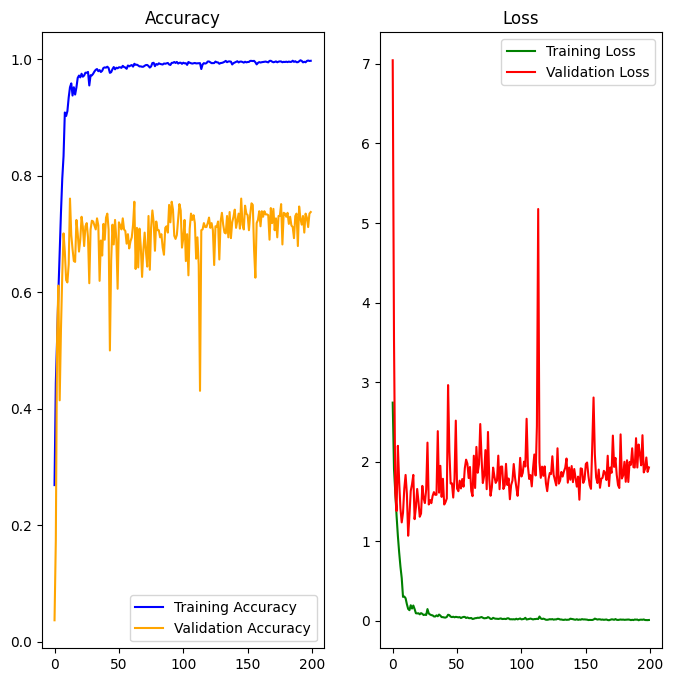

In [50]:
epochs_range = range(epochs_size)
plt.figure(figsize=(8,8))

# 정확도 그래프
plt.subplot(1,2,1)
plt.plot(epochs_range, history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(epochs_range, history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Accuracy')
plt.legend()  # 범례 추가

# 손실 그래프
plt.subplot(1,2,2)
plt.plot(epochs_range, history.history['loss'], label='Training Loss', color='green')
plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss', color='red')
plt.title('Loss')
plt.legend()  # 범례 추가

plt.show()

In [51]:
model.evaluate(test_ds)

 6/24 [======>.......................] - ETA: 0s - loss: 3.3728 - accuracy: 0.5625

2024-02-19 14:13:08.615860: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/24 [==============>...............] - ETA: 0s - loss: 2.2192 - accuracy: 0.7109

2024-02-19 14:13:09.378717: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


24/24 [==============================] - 2s 100ms/step - loss: 1.6919 - accuracy: 0.7649


[1.691870093345642, 0.7648648619651794]

In [52]:
image = 'Apple.jpg'
image = tf.keras.utils.load_img(image, target_size=(img_height,img_width))
img_arr = tf.keras.utils.array_to_img(image)
img_bat=tf.expand_dims(img_arr,0)

In [53]:
predict = model.predict(img_bat)

1/1 [==============================] - 0s 126ms/step


In [54]:
score = tf.nn.softmax(predict)

In [55]:
print('Veg/Fruit in image is {} with accuracy of {:0.2f}'.format(data_class_name[np.argmax(score)],np.max(score)*100))

Veg/Fruit in image is apple with accuracy of 7.02


In [56]:
model.save('Image_classify_3.keras')

In [57]:
model.save('Image_classify_3.h5')

In [ ]:
# model_test = model.load()

In [59]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 90, 90, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 45, 45, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 45, 45, 128)      